# Bias-Aware Clustering
In this notebook, we experiment with the Bias-Aware Clustering algorithm to identify which of the clustering algorithms (K-Means, DBSCAN or MeanShift) perform best in identifying discriminated clusters. The experiment is conducted with the German Credit Risk dataset.

To obtain the appropriate input for the Bias-Aware Clustering algorithm, we have preprocessed the dataset such that:
- It contains the errors obtained from a random forest classifier on the test set.
- The categorical attributes have been one-hot encoded
- We also have the predicted class and true class attributes. If your dataset doesn't contain these columns, please use the "synthetic data" notebook. 

### Init


In [9]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
from scipy import stats
from scipy.stats import ttest_ind
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from pandas.plotting import parallel_coordinates
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

## 1. Importing the Dataset

In [12]:
raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine_final.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
# raw_compas = pd.read_csv(r'..\Preprocessed_datasets\final_preprocessed_compas.csv', index_col=0)
# raw_credit =  pd.read_csv(r'..\Preprocessed_datasets\preprocessed_german_credit.csv', index_col=0)

# Number of errors
# display(len(raw_data.loc[raw_data['errors']==1]))
# # display(len(raw_data.loc[raw_data['errors']==0]))
# display(raw_data)


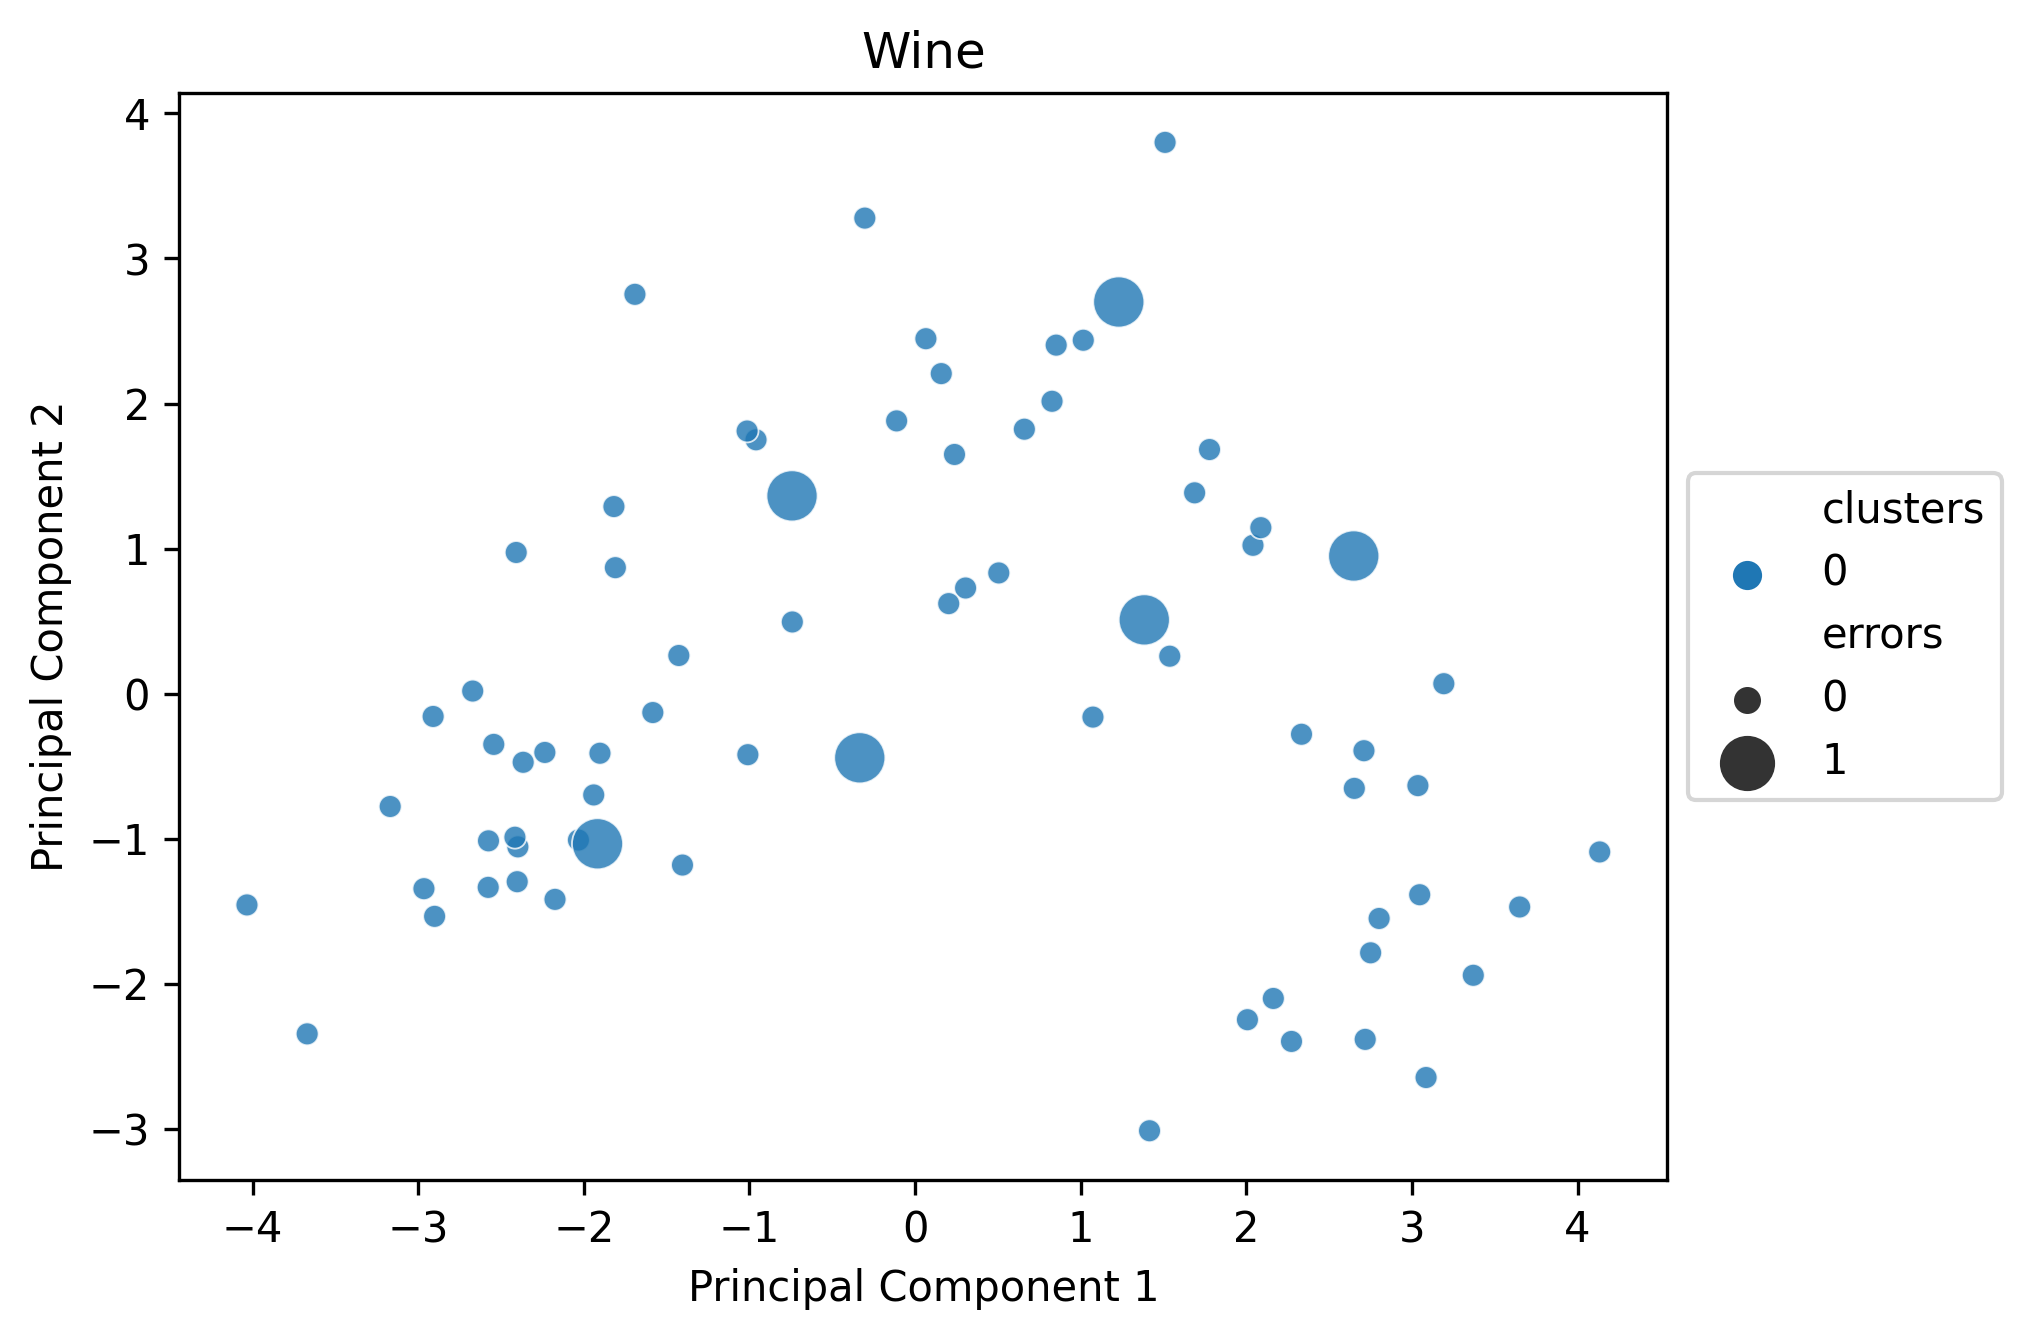

In [13]:
full_data = initialize_dataset(raw_data)
pca_plot(full_data, 'Wine', 0.8)

### Utils
The required functions for Bias-Aware Computing 

In [5]:
def pca_plot(data, title, alpha):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    print('This is the random cluster we have picked:', result)
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. Cluster: ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    print('discriminating bias is:', max_abs_bias)
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    print('cluster with the highest discriminating bias:', best_cluster)
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Bias-Aware KMeans Clustering 

In [25]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 10,
}

In [14]:
full_data = initialize_dataset(raw_data)
full_data.head()


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
118 -0.338510    1.005004 -1.166817          -0.803327  -1.246801   
39   1.505019    1.494574  0.630750          -1.590260   1.470062   
176  0.170050    0.270648  0.155921           0.320862   1.017252   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
118      -0.988536   -0.762724              0.599286        -1.234524   
39        1.074278    0.907054             -1.248791         0.733019   
176      -0.958422   -1.294440              1.402798        -0.242882   

     color_intensity       hue  od280/od315   proline  scaled_errors  \
104        -1.025689  0.361193     1.354564 -0.225753            0.0   
67         -0.239382  0.710266     1.229242 -0.714467            0.0   
118        -0.817815 -1.122366    -0.664518 -1.130778            0.8   
39         -0.049584 -0.293318     1.298865  0.039721            0.0   
176         1.848400 -1.558707    -1.360753  0.281061            0.0   

     predicted_class  true_class  errors  clusters  new_clusters  
104                1           1       0         0            -1  
67                 1           1       0         0            -1  
118                2           1       1         0            -1  
39                 0           0       0         0            -1  
176                2           2       0         0            -1

In [84]:
# #pseudocode notes
# MAX_ITER = 20
# x = 0 # initial cluster number
# initial_bias = 0
# pca_plot(full_data)
# variance_list = []
# average_accuracy = accuracy(full_data)
# minimal_splittable_cluster_size = round(0.05 * len(full_data))
# minimal_acceptable_cluster_size = round(0.03 * len(full_data))
# print("average_accuracy is: ", average_accuracy) 

# for i in range(1, MAX_ITER):
#     if i != 1:
#         variance_list.append(calculate_variance(full_data))
#         print('variance list update:', variance_list)
#     full_data['new_clusters'] = -1
#     candidate_cluster = full_data.loc[full_data['clusters'] == x]

#     if len(candidate_cluster) < minimal_splittable_cluster_size:
#         print("length of candidate cluster size is:", len(candidate_cluster))
#         print('minimal splittable cluster size:', minimal_splittable_cluster_size)
#         x = get_random_cluster(full_data['clusters'])
#         print('candidate cluster size is too small, we picked a cluster randomly ')
#         continue
    
#     # Apply KMeans 
#     kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
#     print("KMeans is applied on cluster")
#     candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
#     full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

#     max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
#     print("Calculating the discriminating bias of the cluster(s?)", max_abs_bias)
#     min_new_size = get_min_cluster_size(full_data)
    
#     if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
#         print('the bias of the new cluster is worse than the initial bias %f since the initial bias is %f', max_abs_bias, initial_bias)
#         # Add new cluster
#         n_cluster = max(full_data['clusters'])
#         full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
#         print('generating the visualisation..')
#         pca_plot(full_data)
#         x = get_next_cluster(full_data)
#         print('the initial bias:', initial_bias)
#         print('will be set to the current discrimination bias of:', max_abs_bias)
#         initial_bias = max_abs_bias
#     else:
#         print('we will select a cluster randomly')
#         x = get_random_cluster(full_data['clusters'])
        
# print('we have reached the end of the loop')        
# print('MAX_ITER')
# print(variance_list)


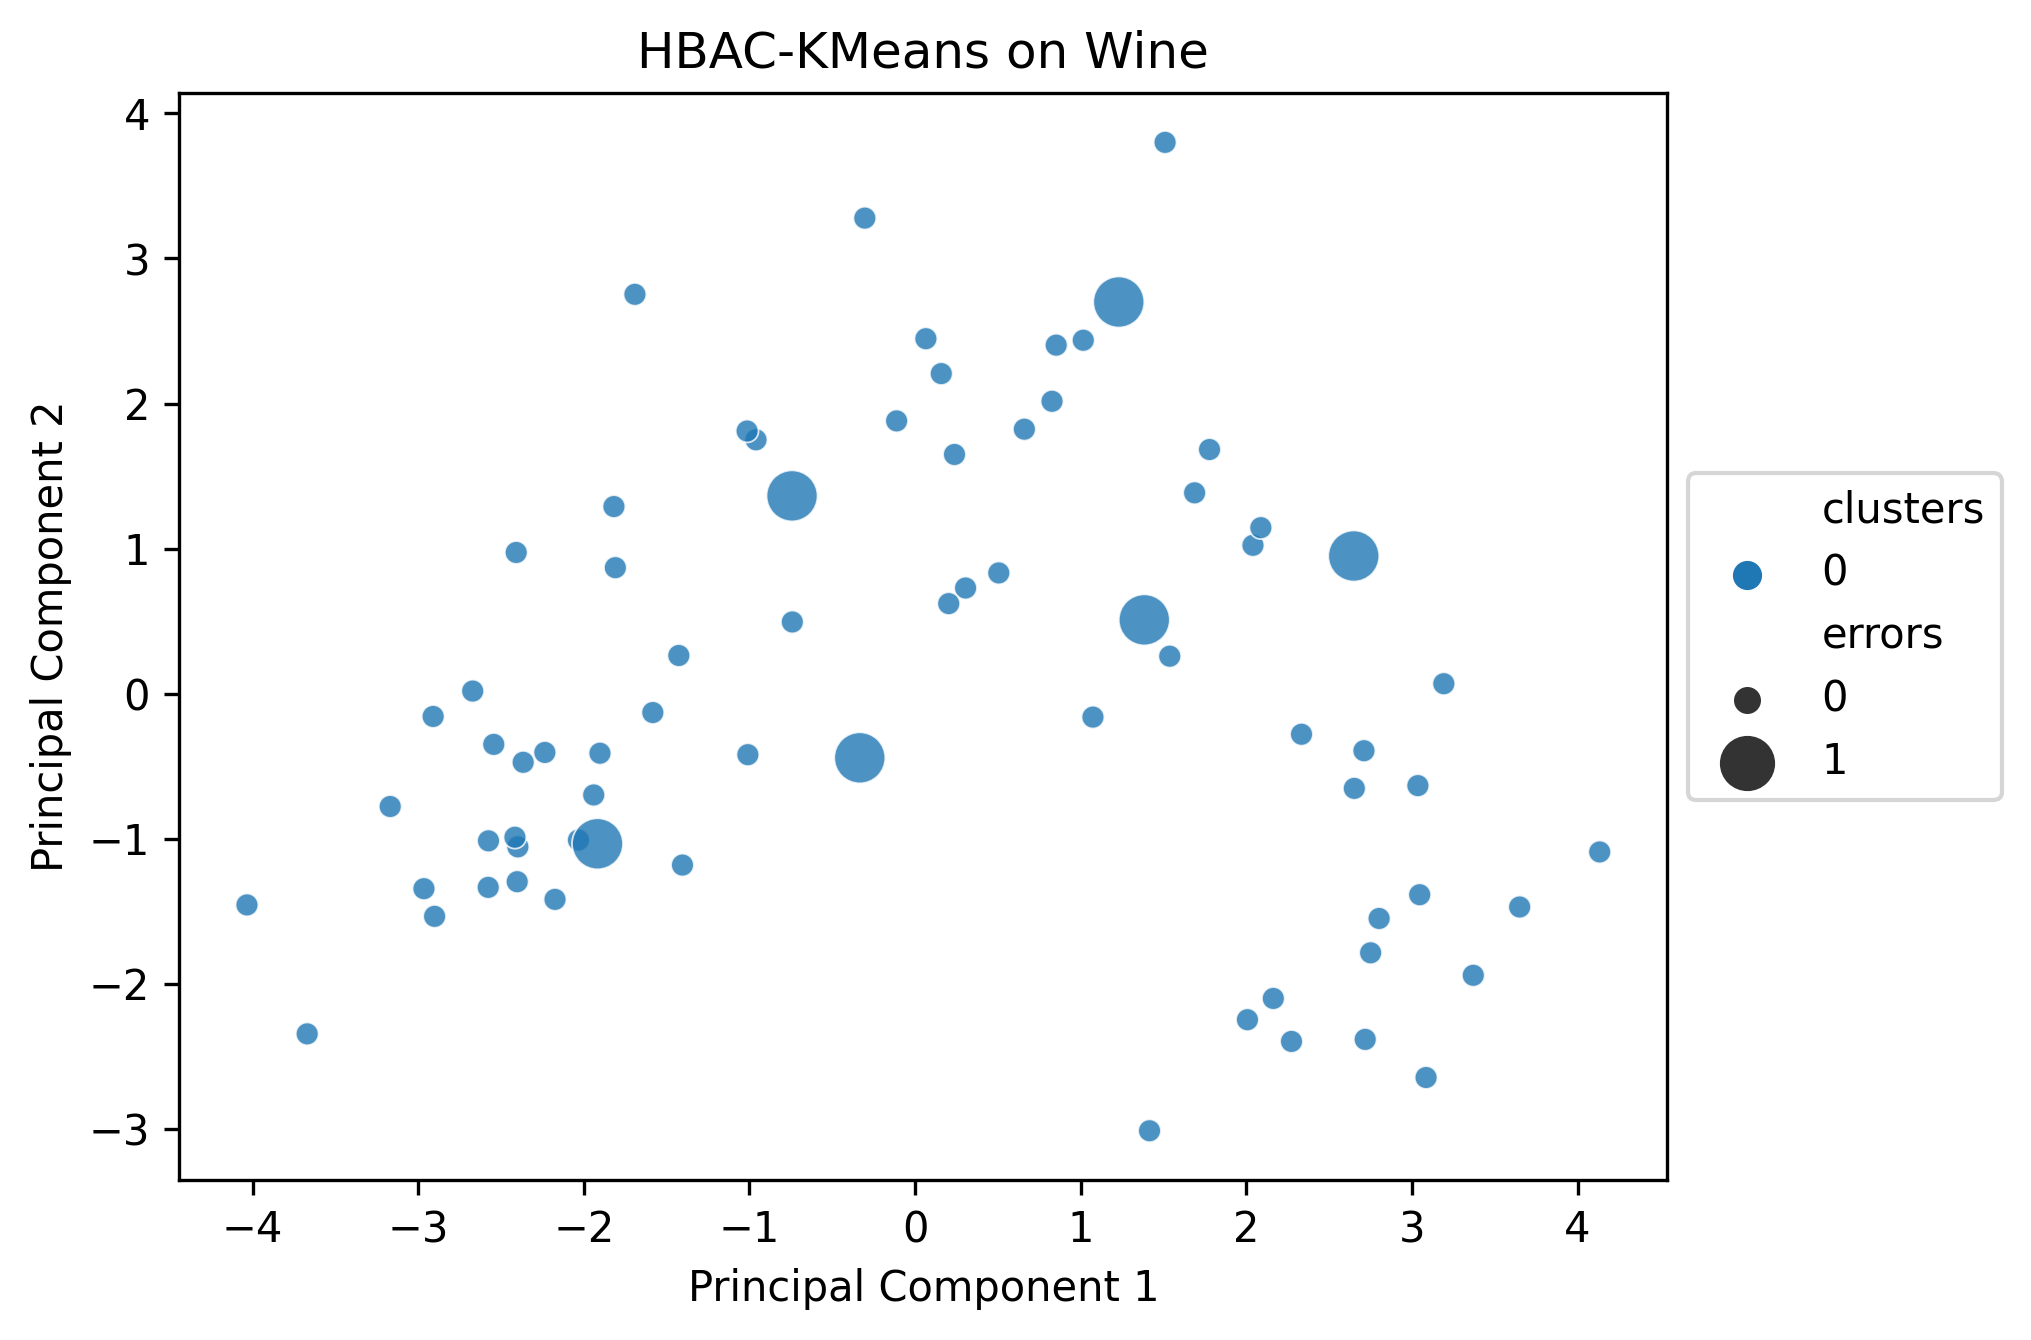

average_accuracy is:  0.9166666666666666
discriminating bias is: -999999


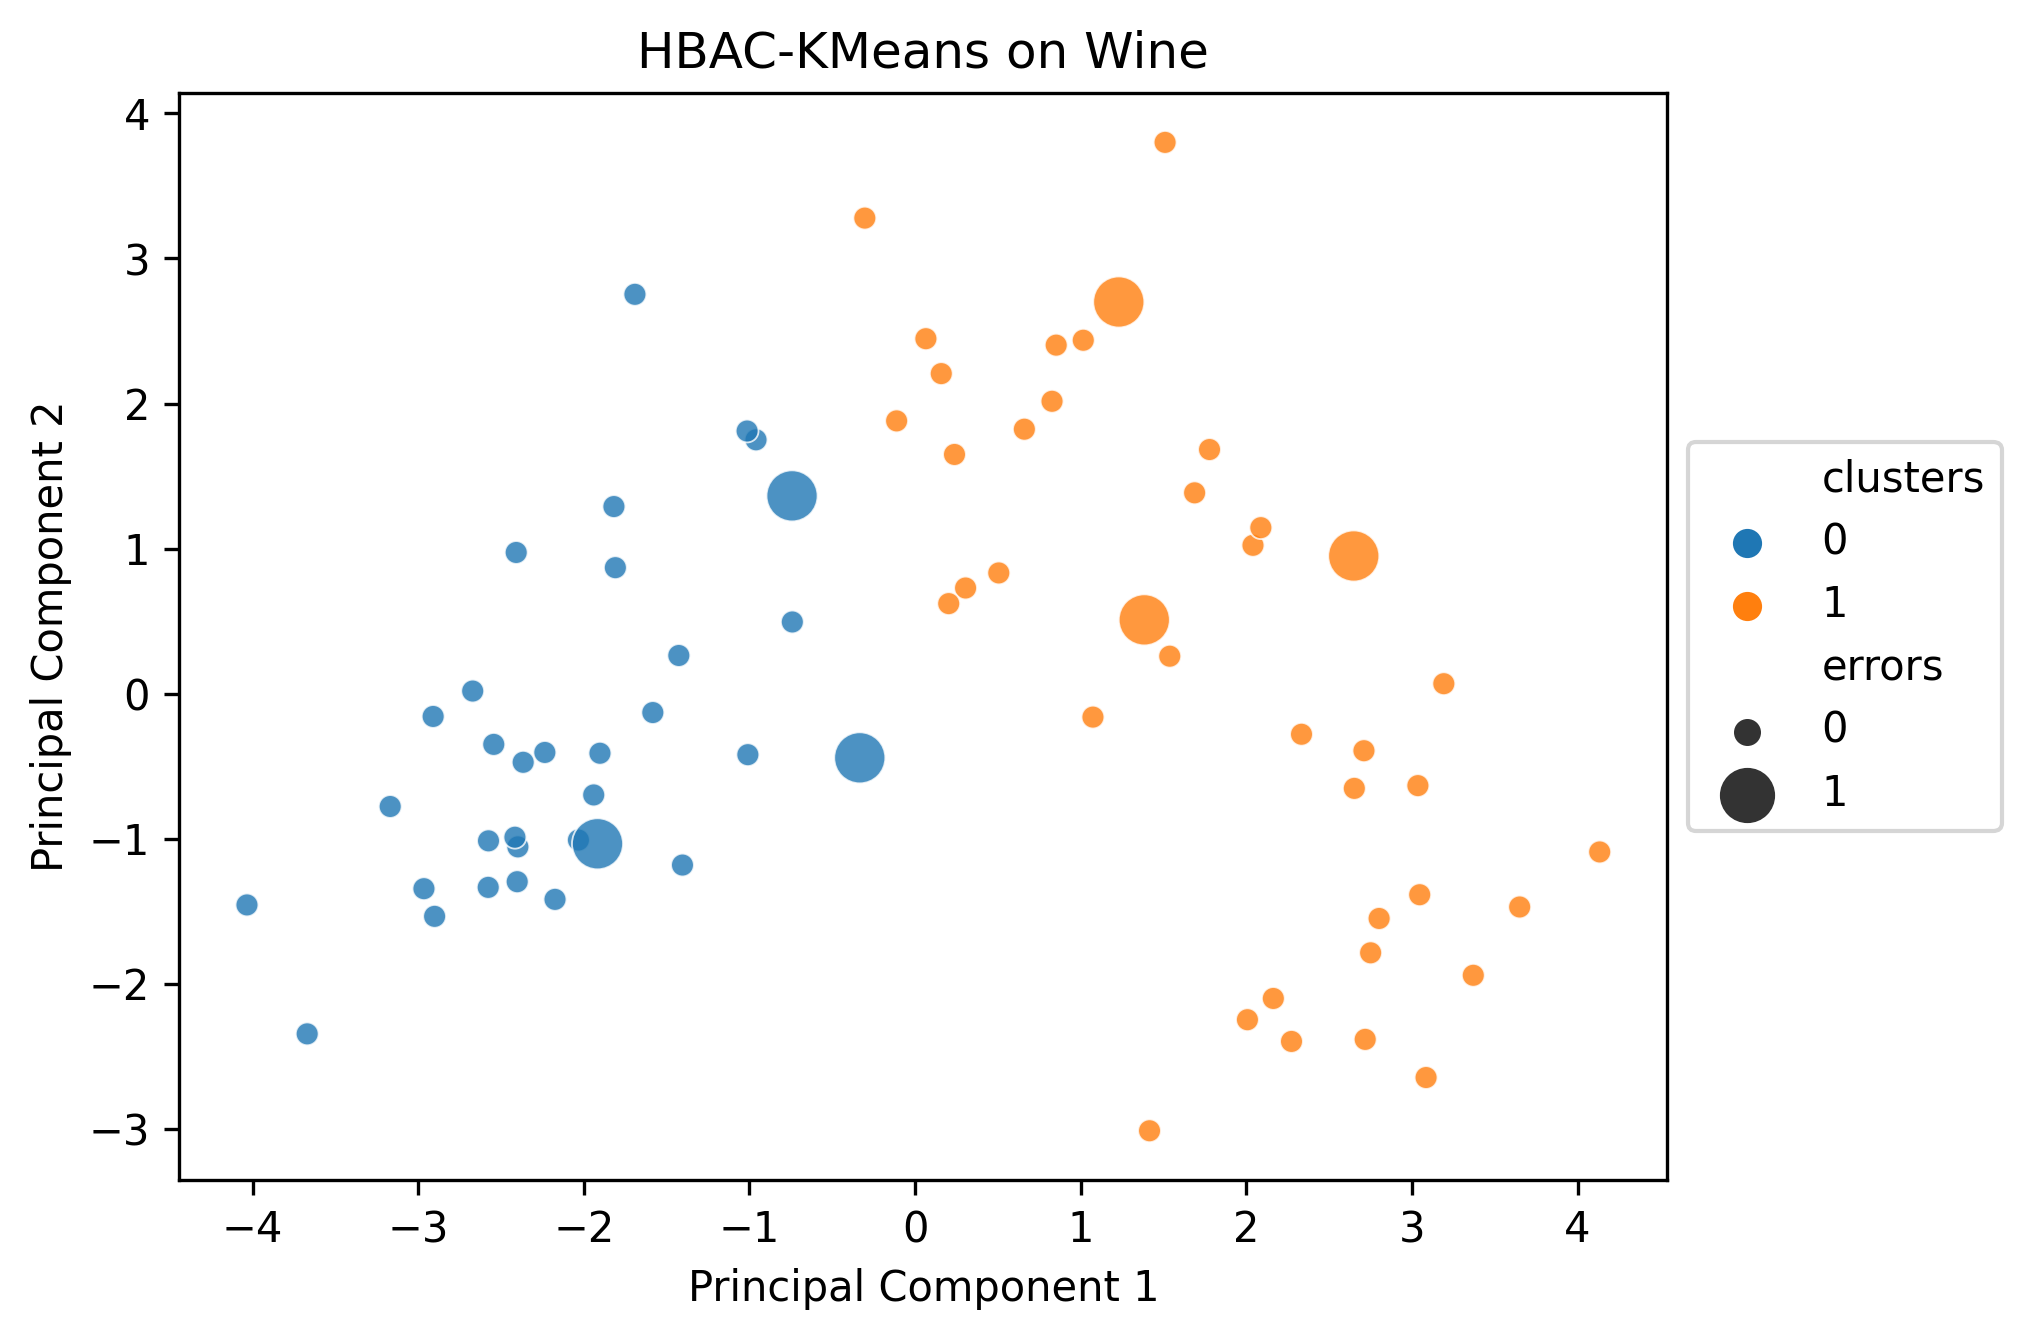

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 0
discriminating bias is: -999999


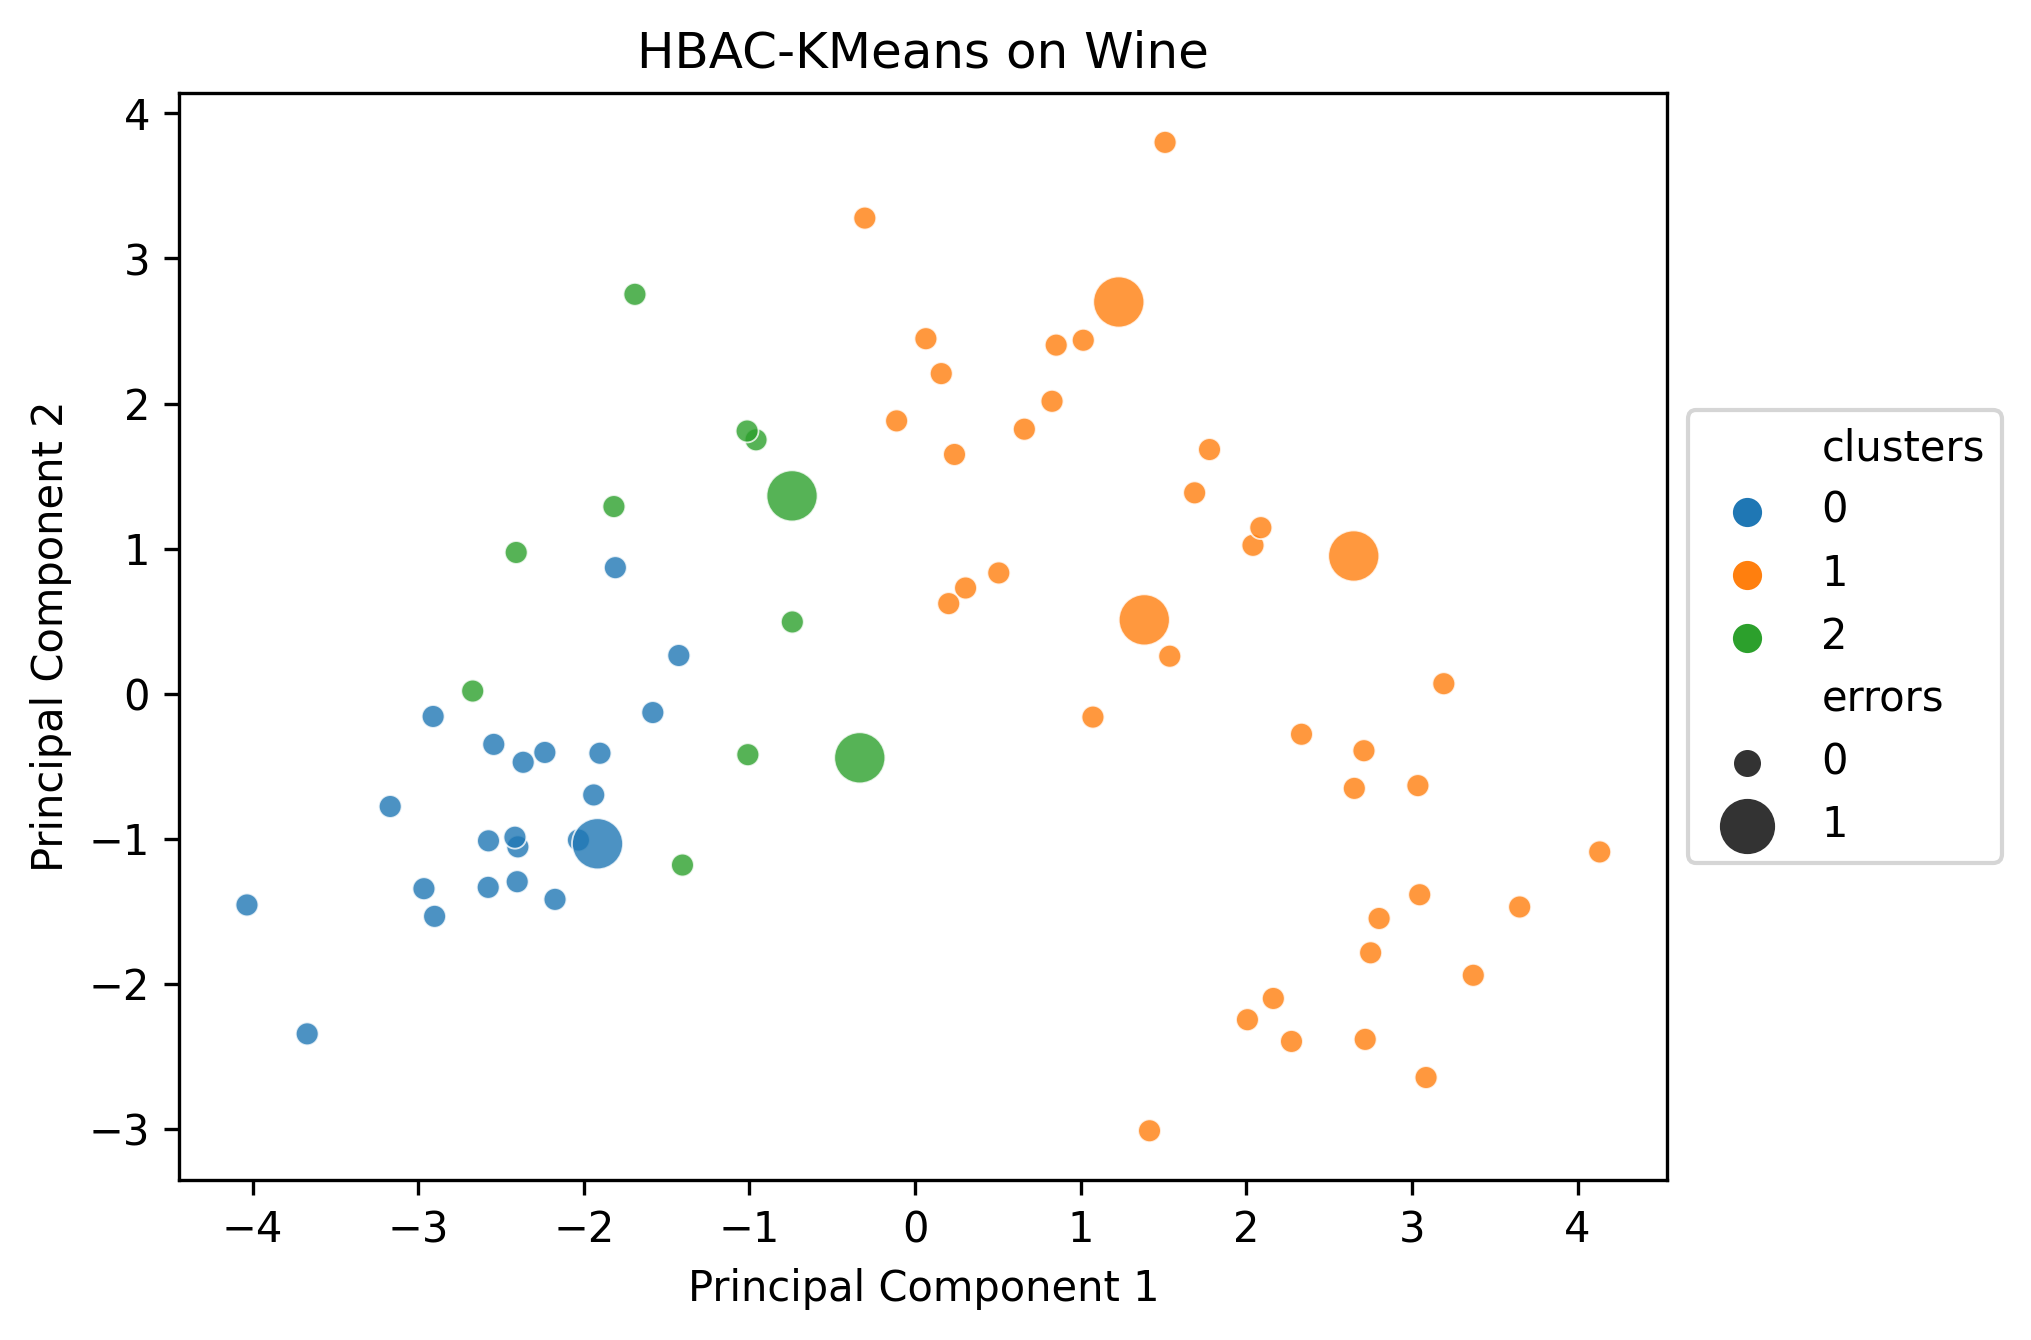

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 2
discriminating bias is: -999999


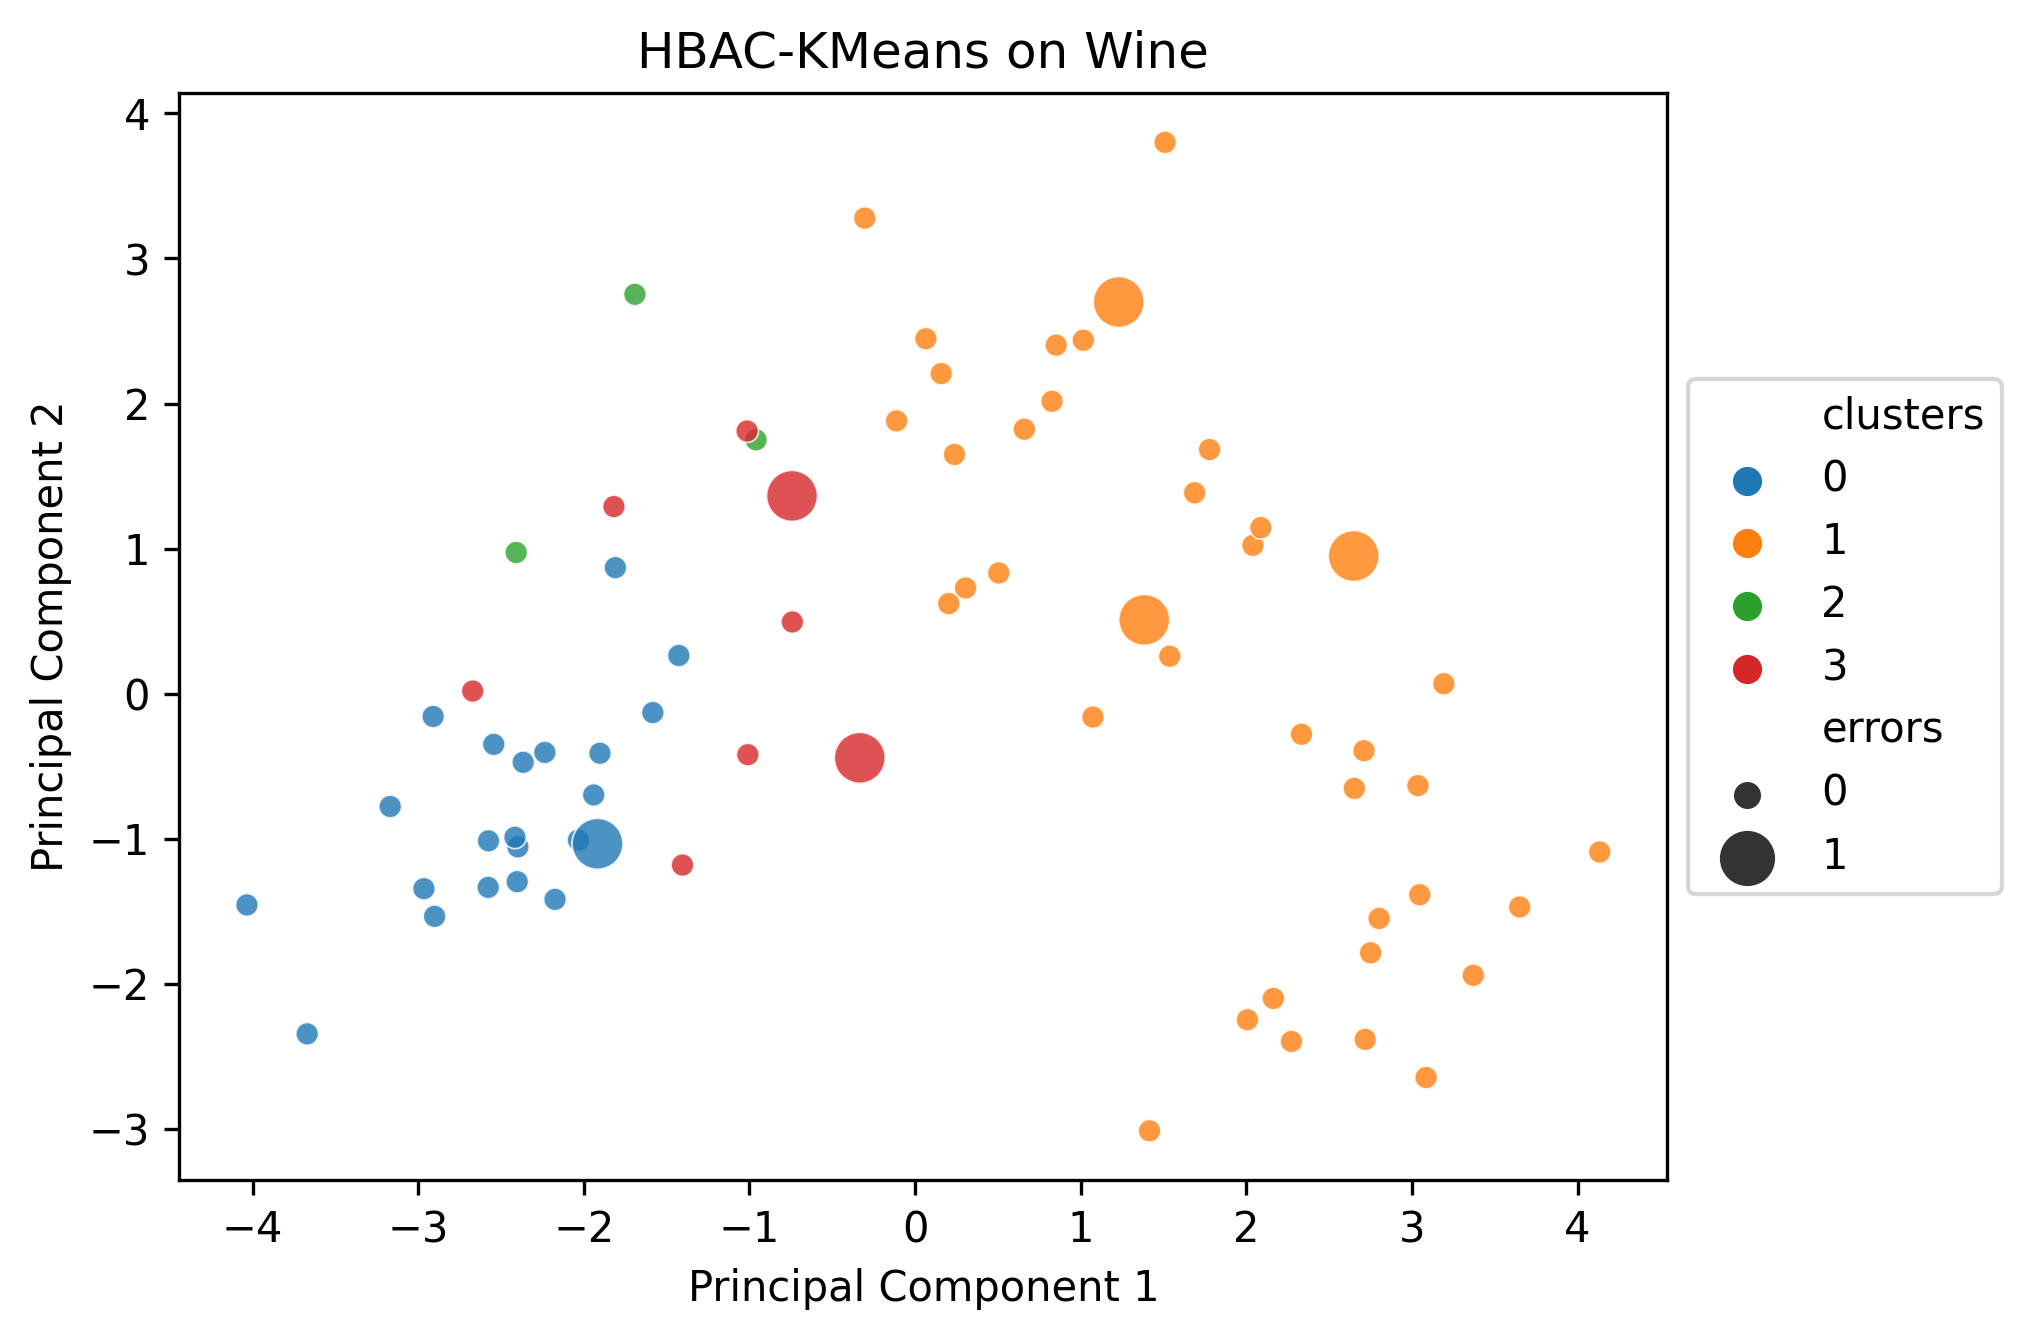

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 3
discriminating bias is: -999999
This is the random cluster we have picked: 0
discriminating bias is: -999999


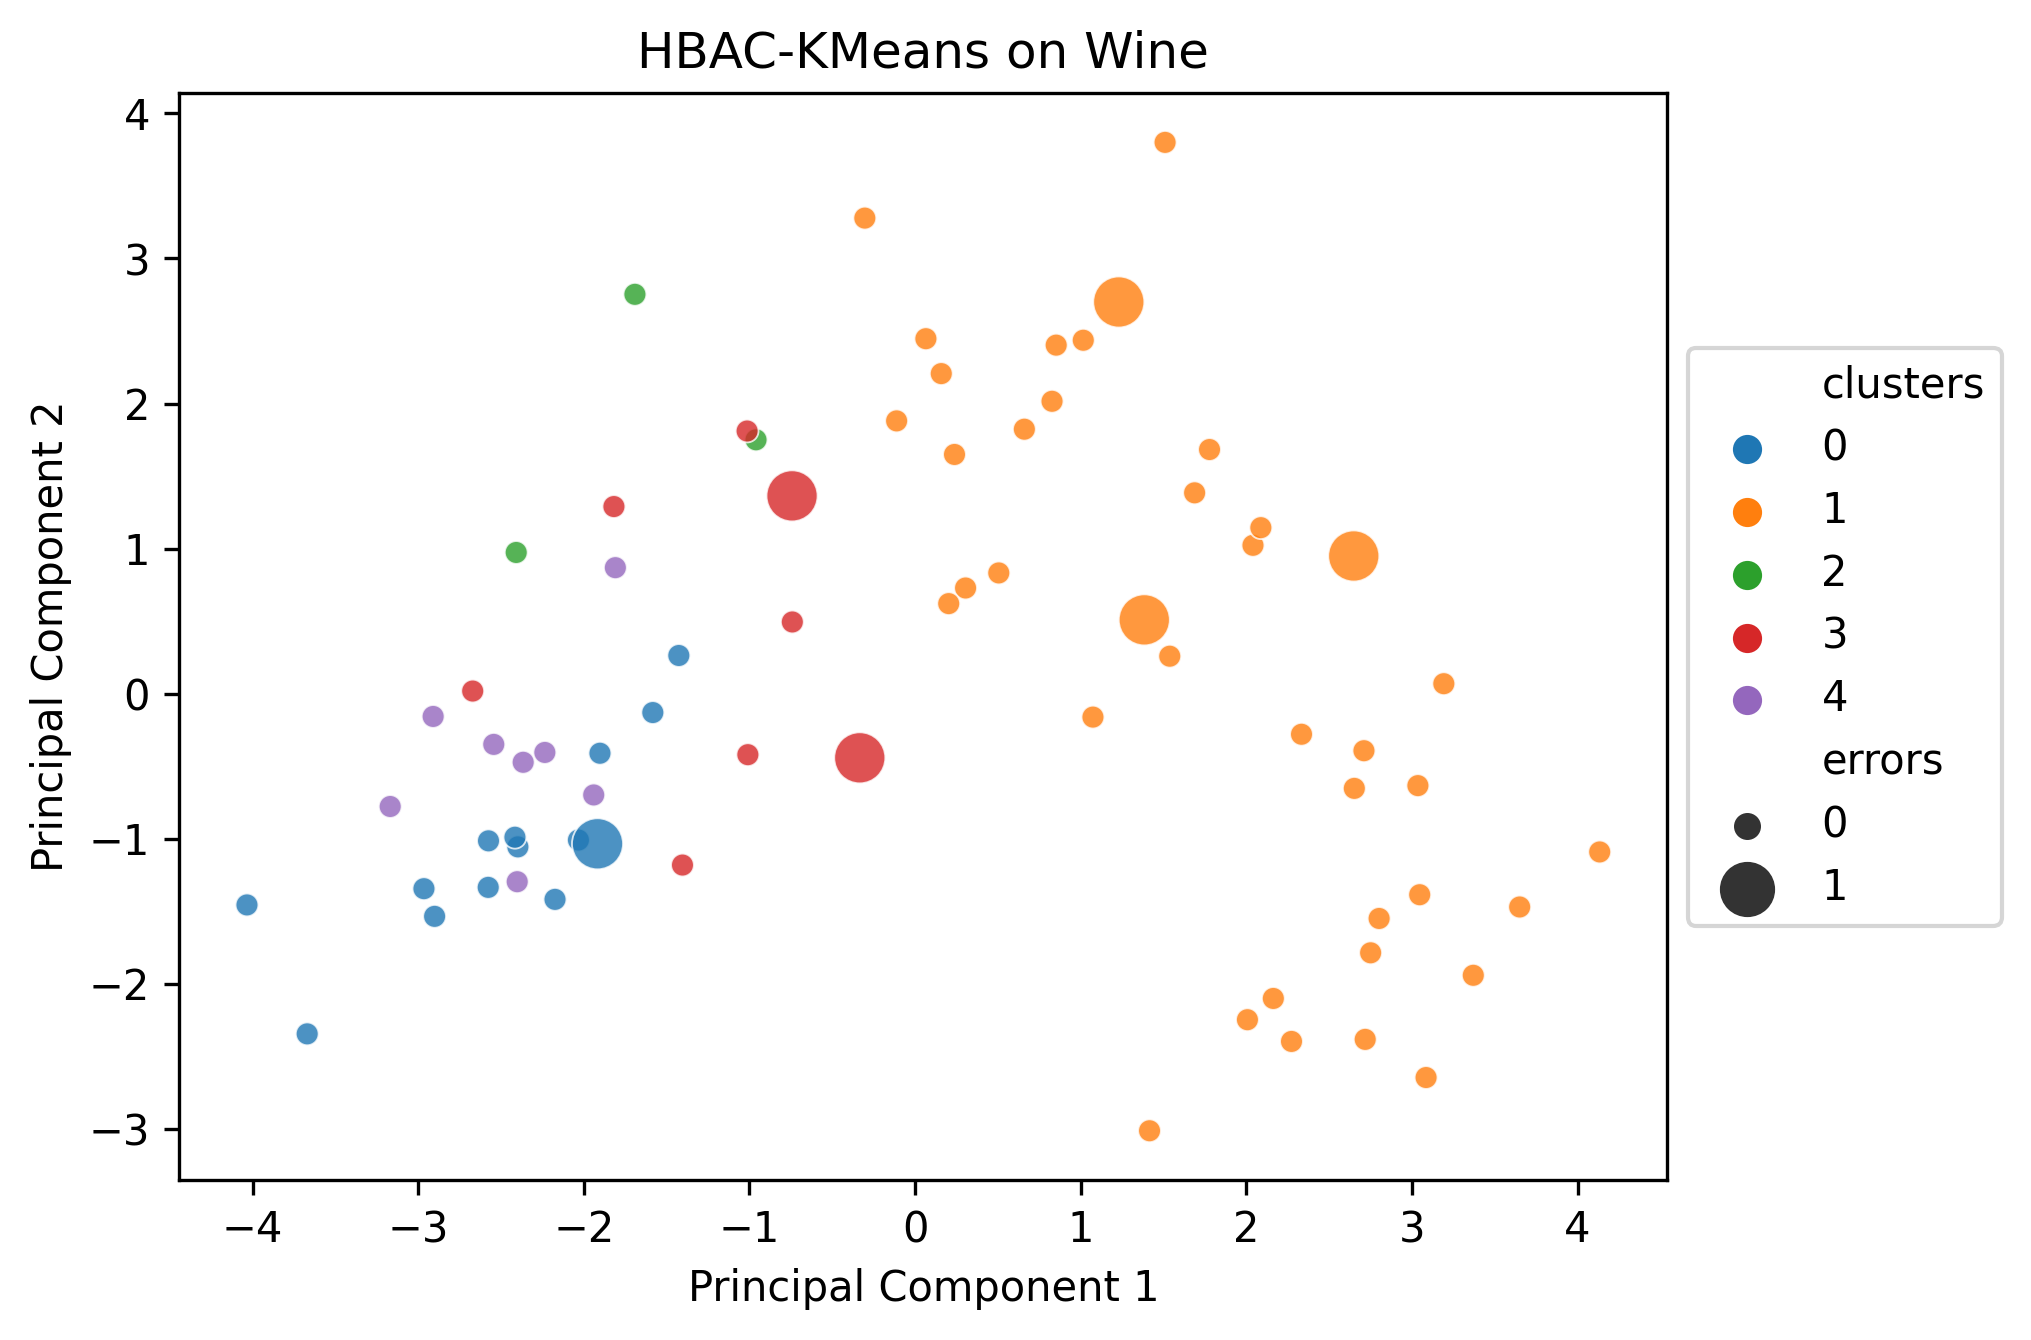

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 3
discriminating bias is: -999999
This is the random cluster we have picked: 0
discriminating bias is: -999999


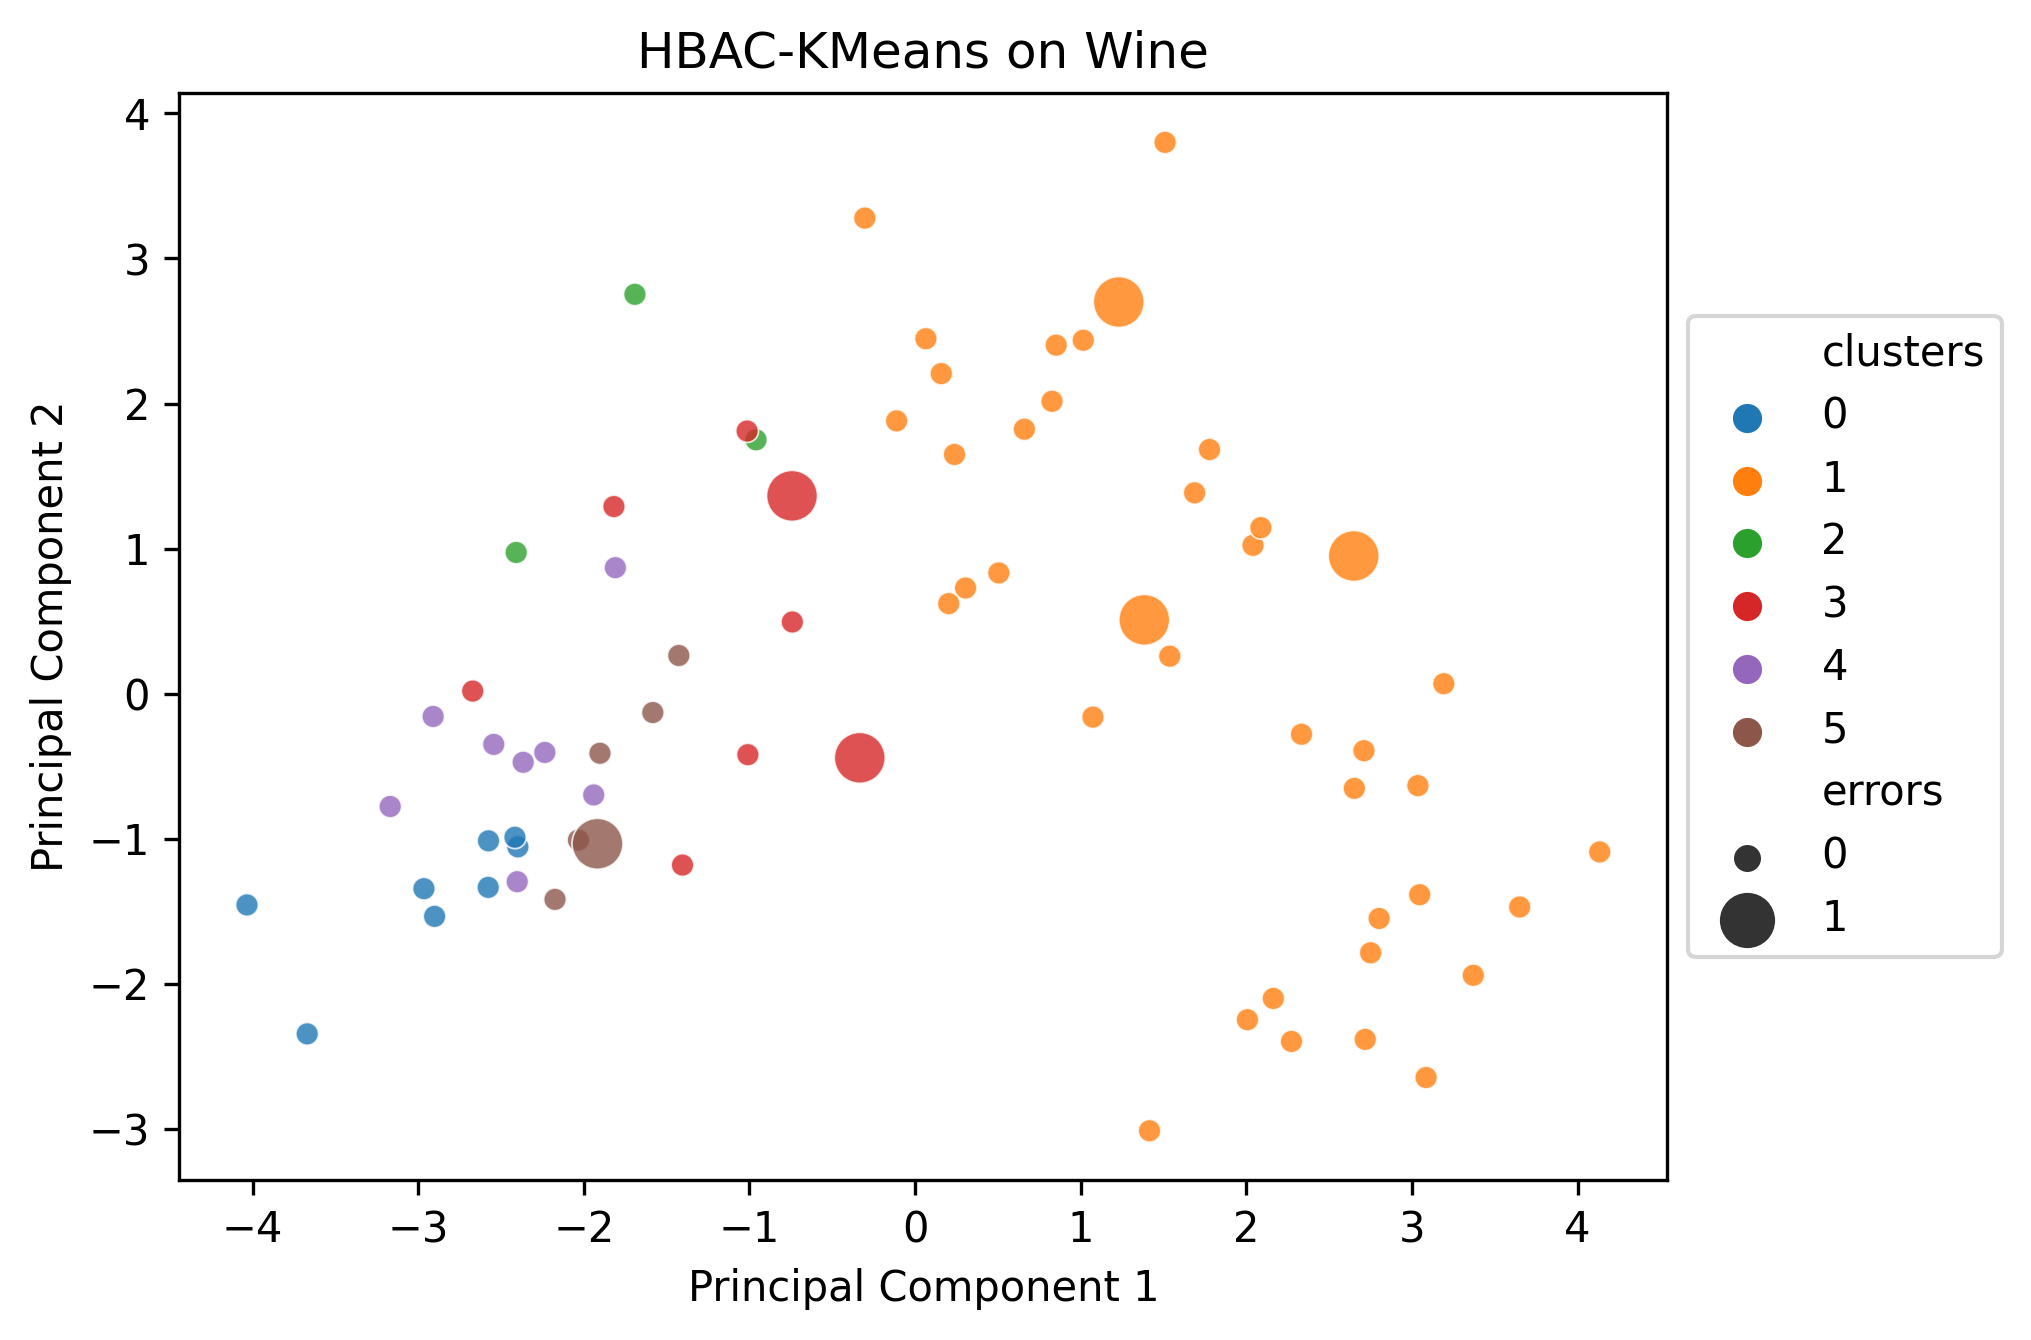

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 3
discriminating bias is: -999999
This is the random cluster we have picked: 2
This is the random cluster we have picked: 1
discriminating bias is: -999999


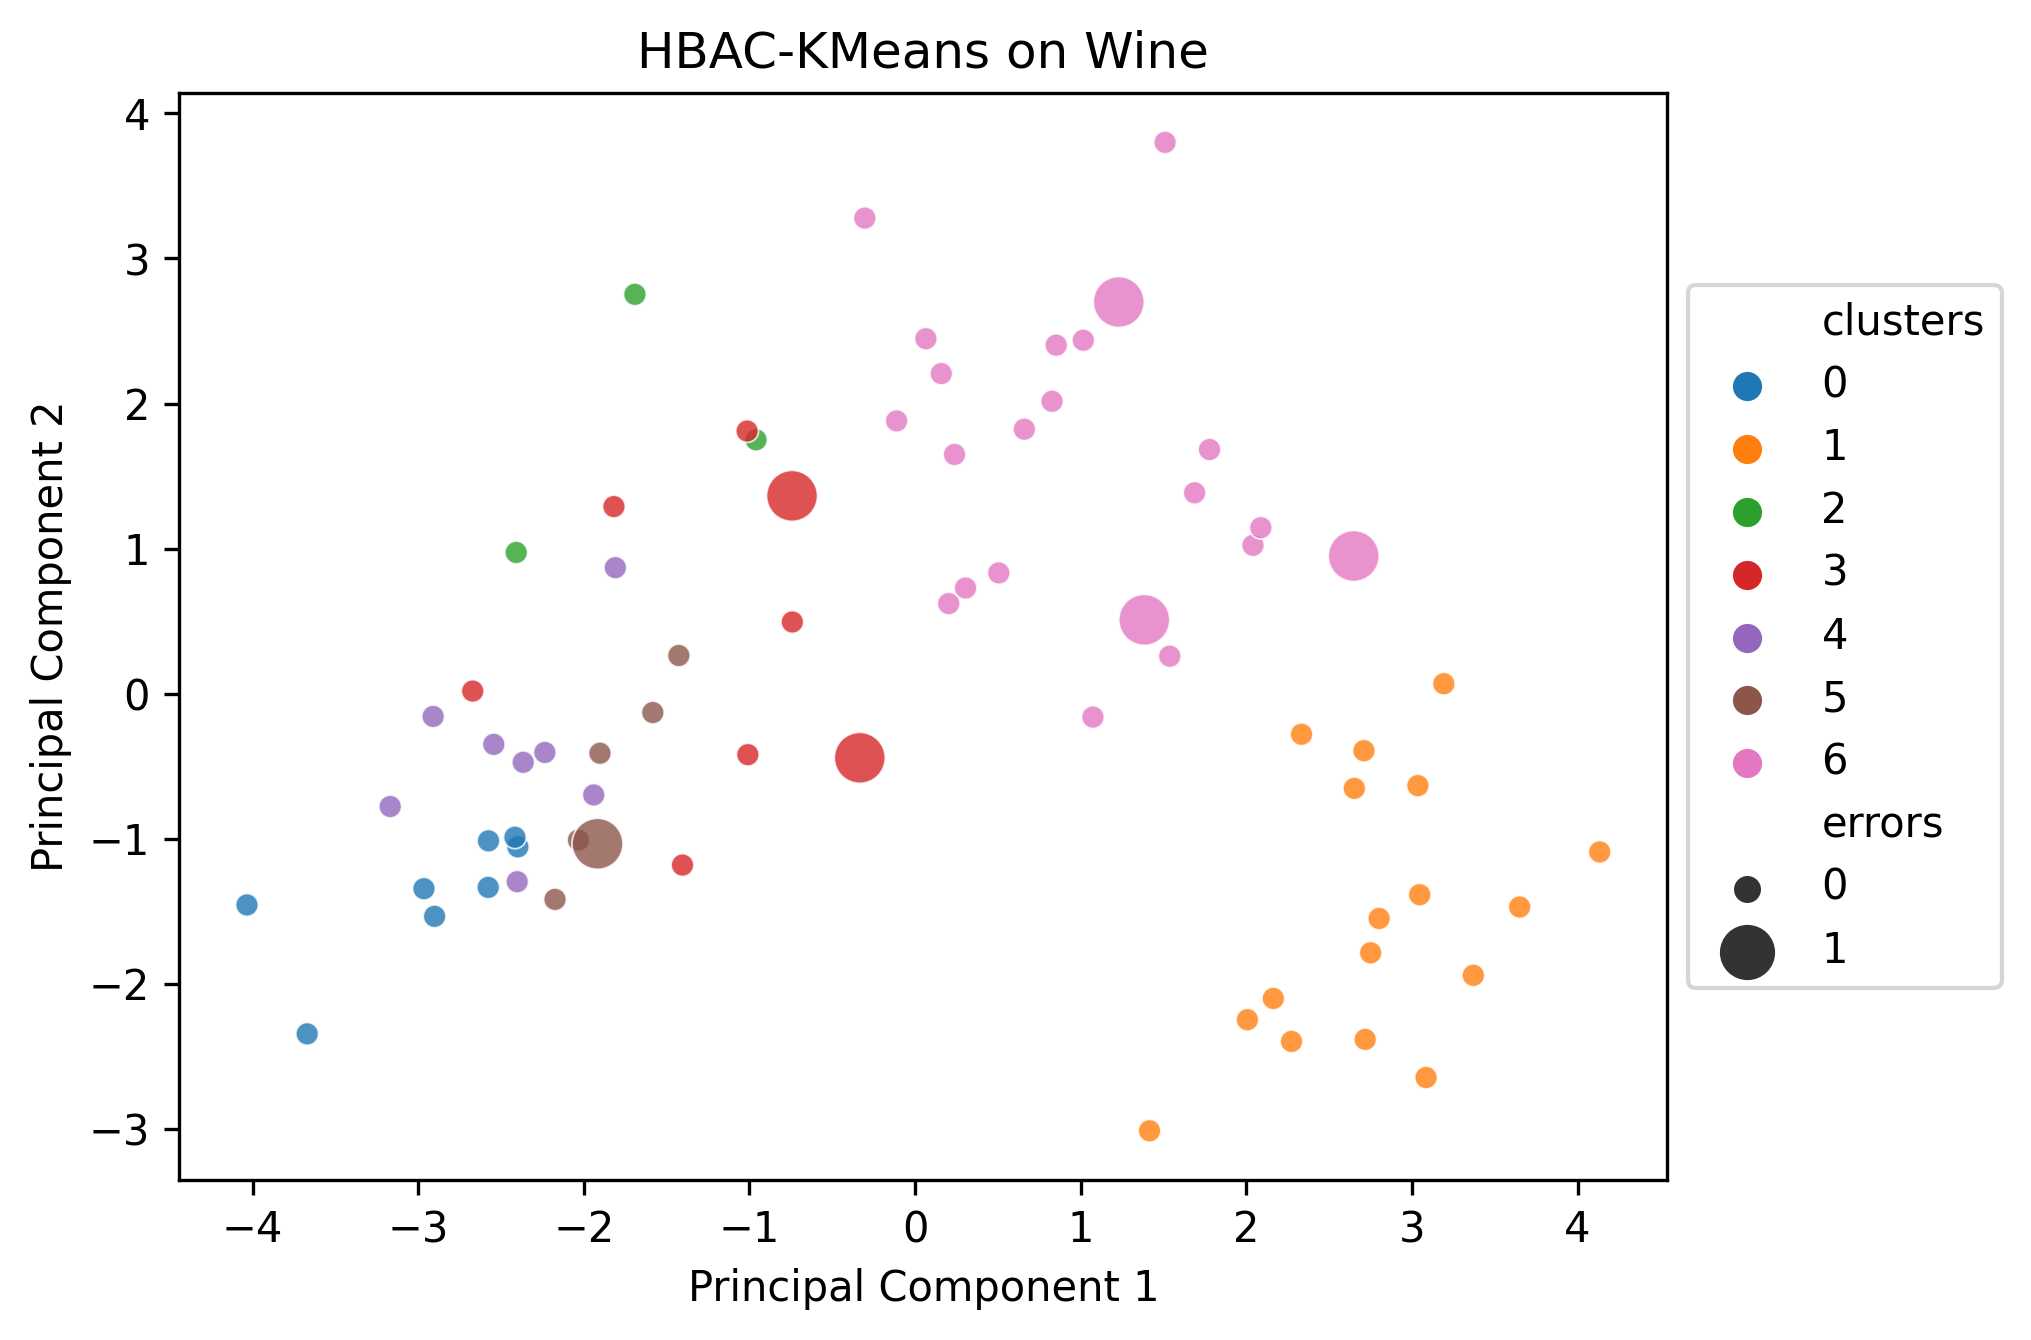

--> Cluster with the highest variance: 6
--> Cluster with the highest variance: 3
discriminating bias is: -999999
This is the random cluster we have picked: 1
discriminating bias is: -999999


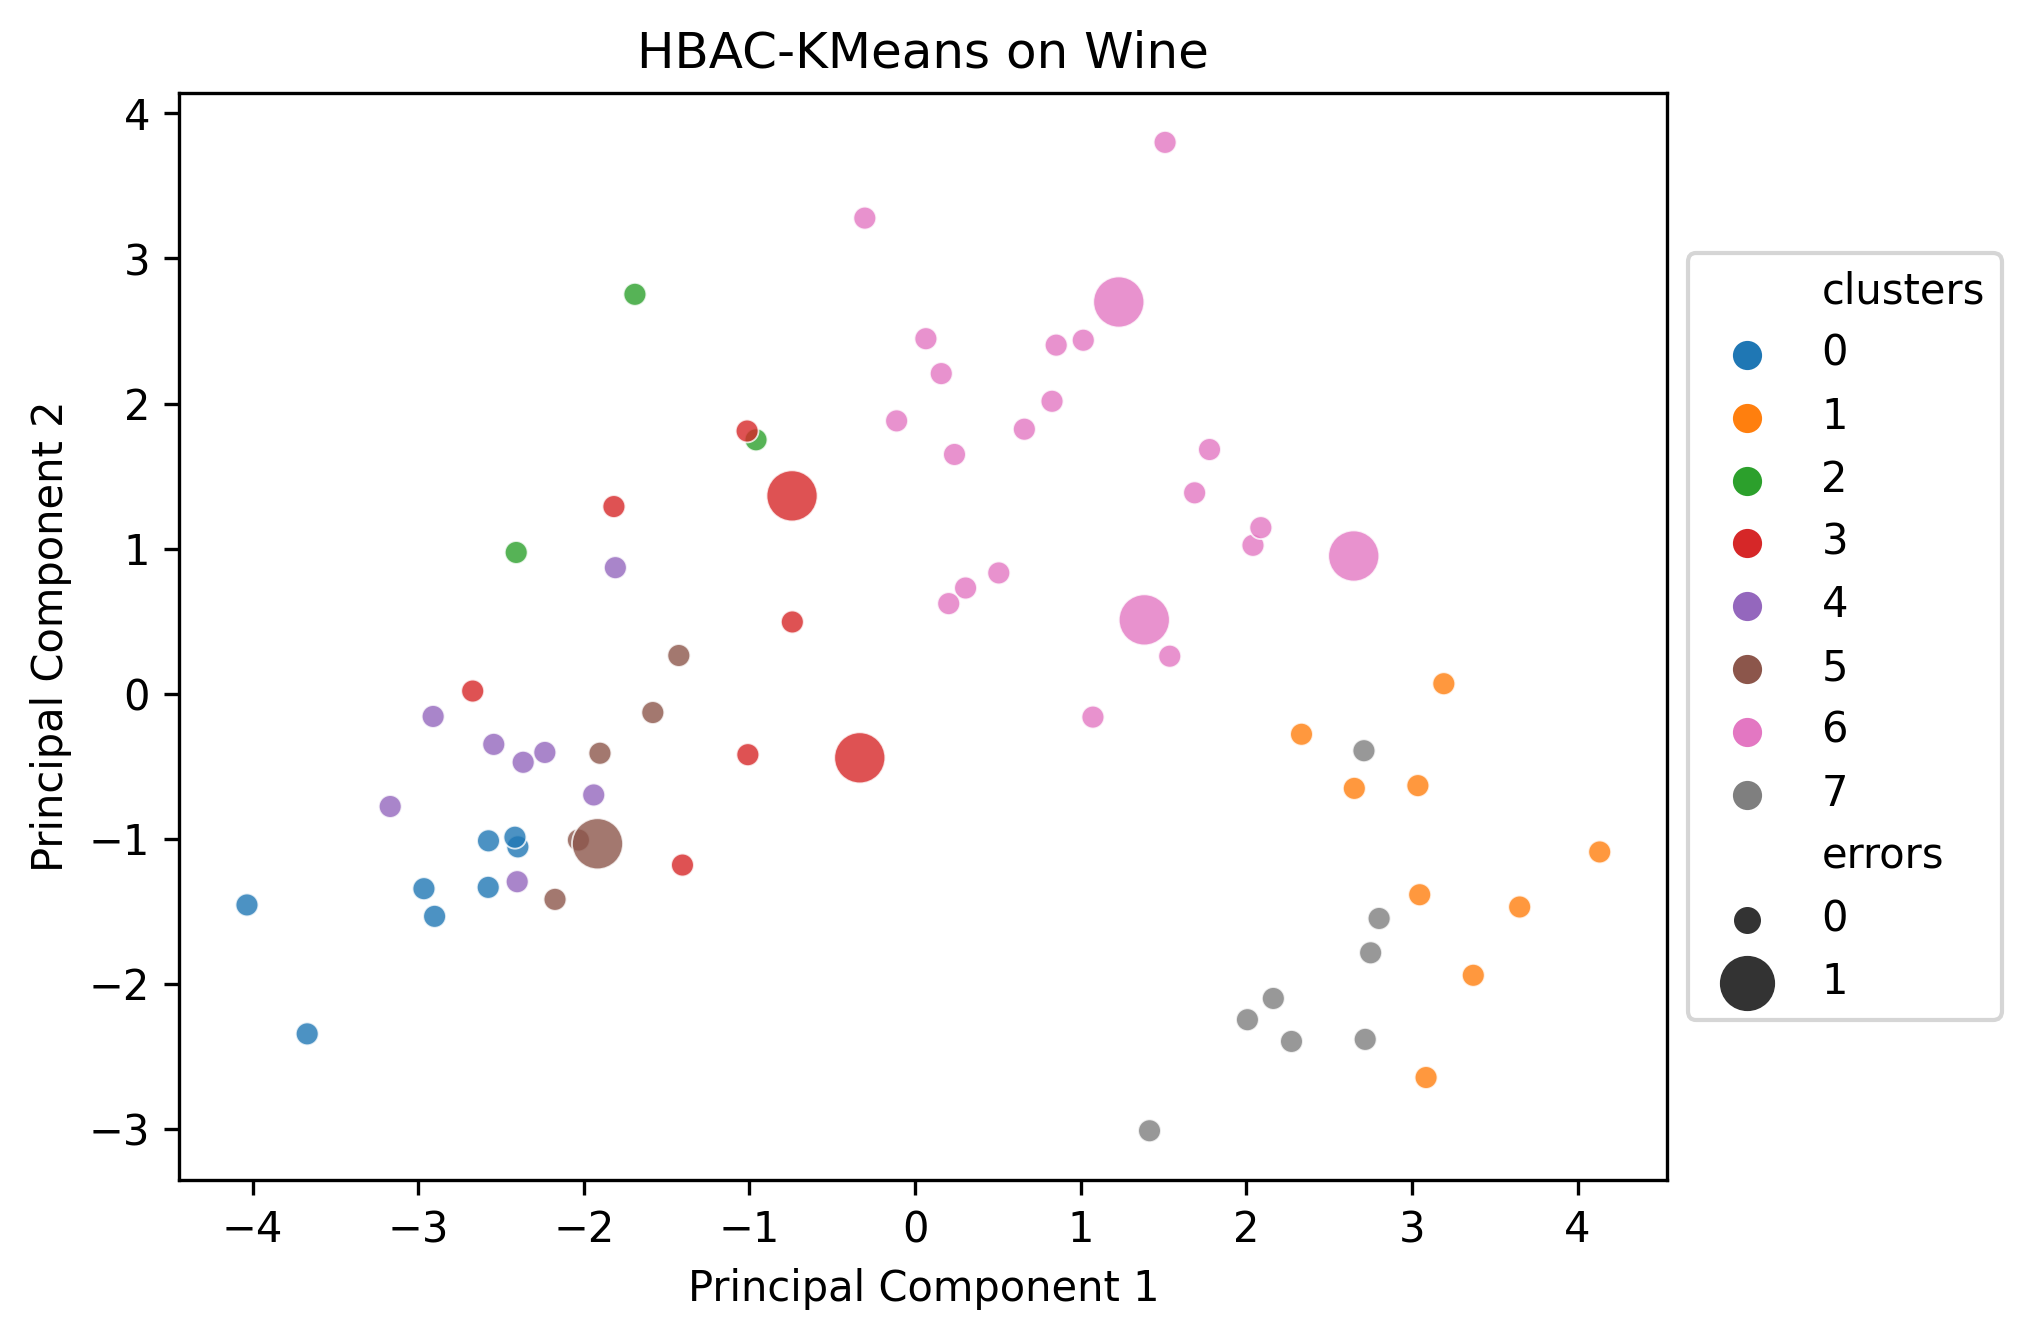

--> Cluster with the highest variance: 6
--> Cluster with the highest variance: 3
discriminating bias is: -999999
This is the random cluster we have picked: 3
discriminating bias is: -999999
This is the random cluster we have picked: 2
This is the random cluster we have picked: 1
discriminating bias is: -999999


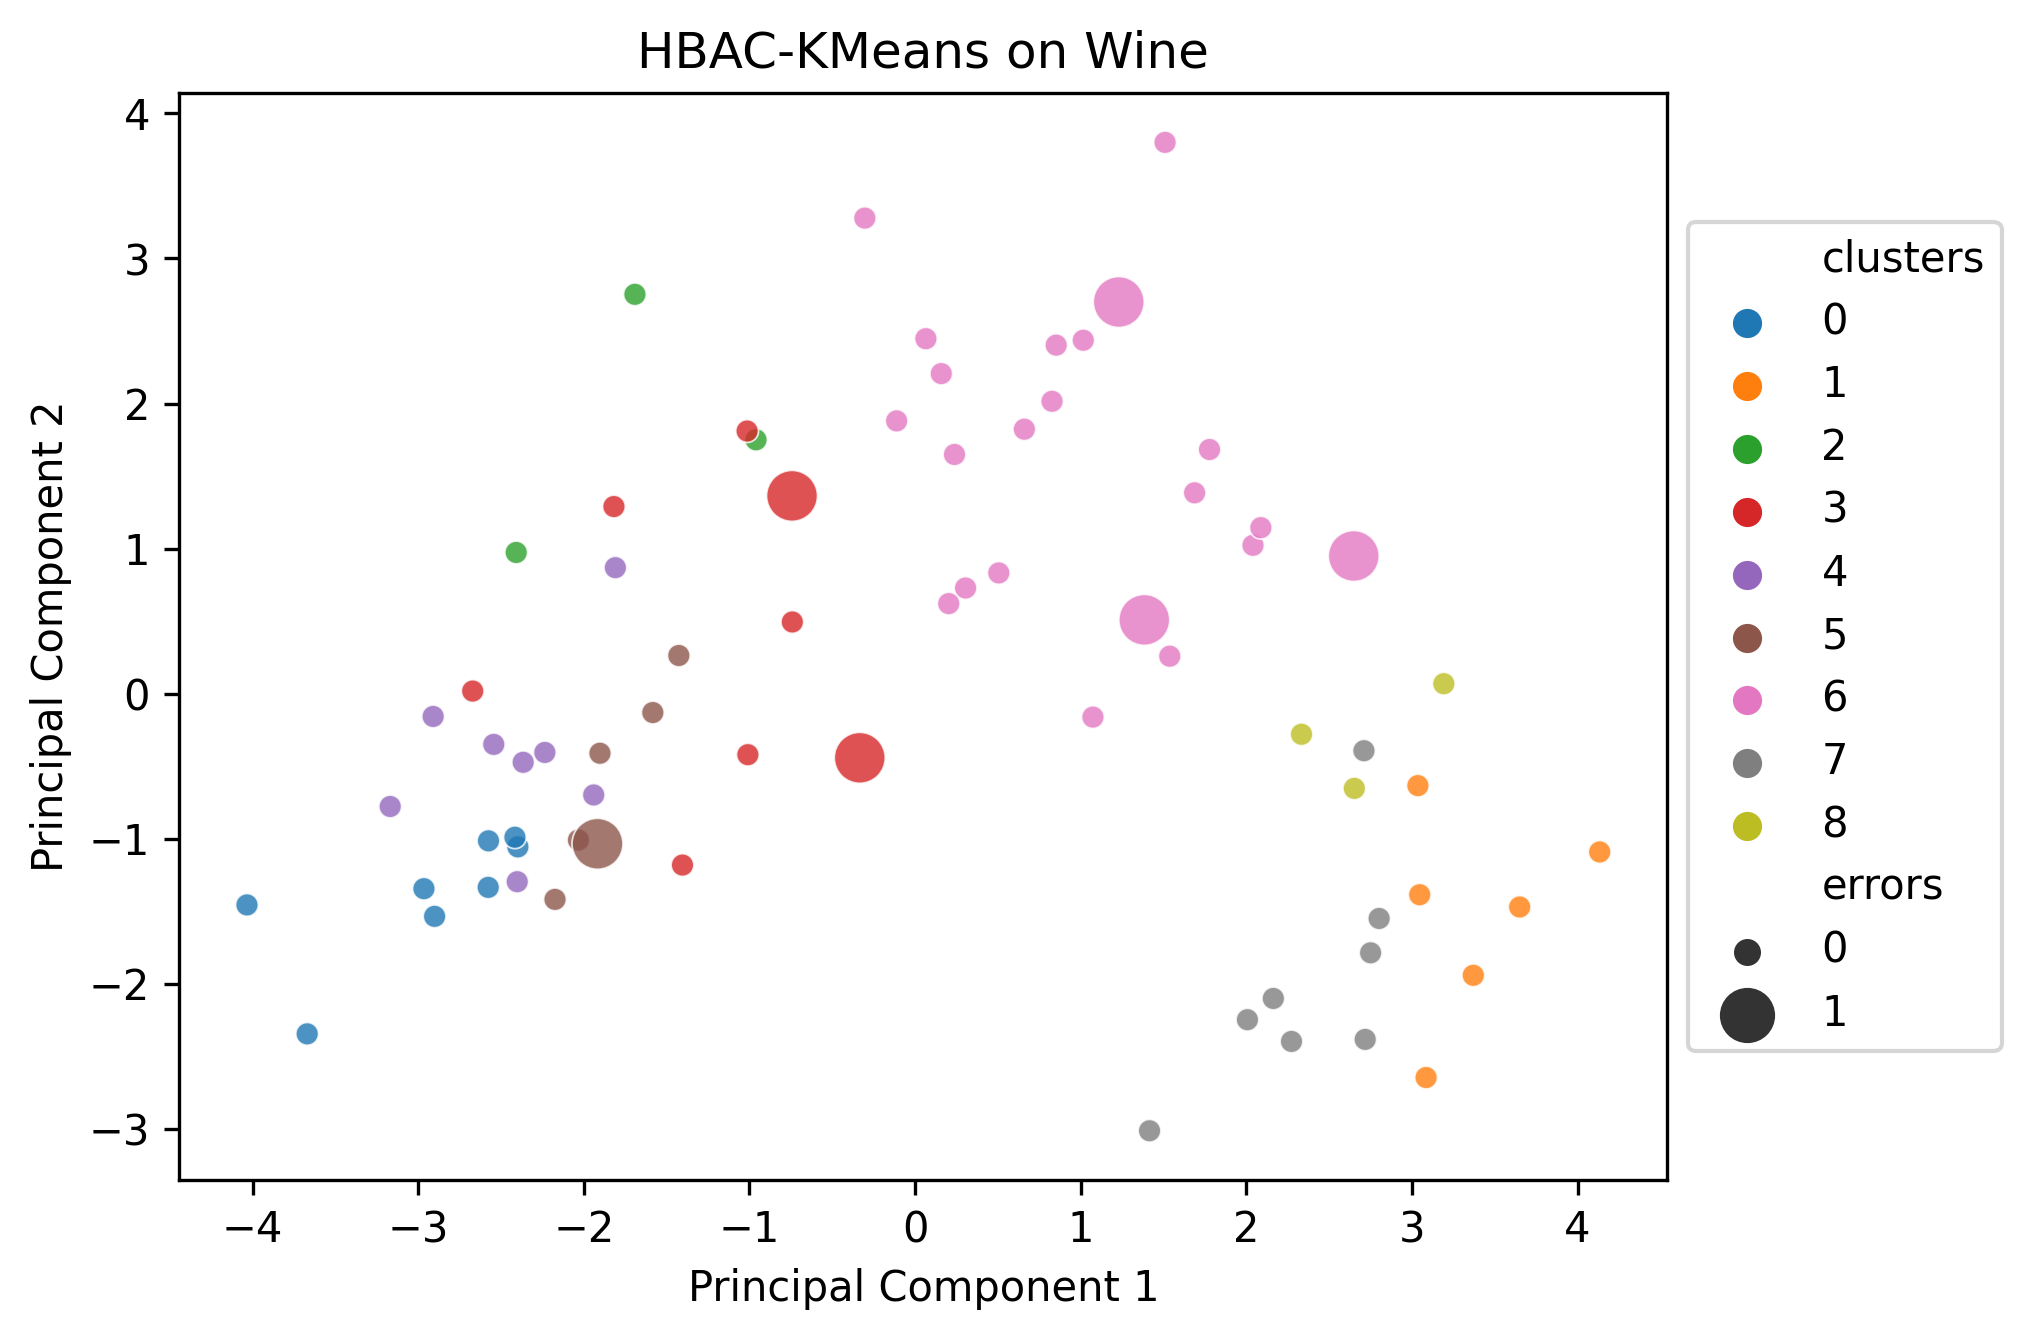

--> Cluster with the highest variance: 6
--> Cluster with the highest variance: 3
discriminating bias is: -999999
This is the random cluster we have picked: 4
discriminating bias is: -999999


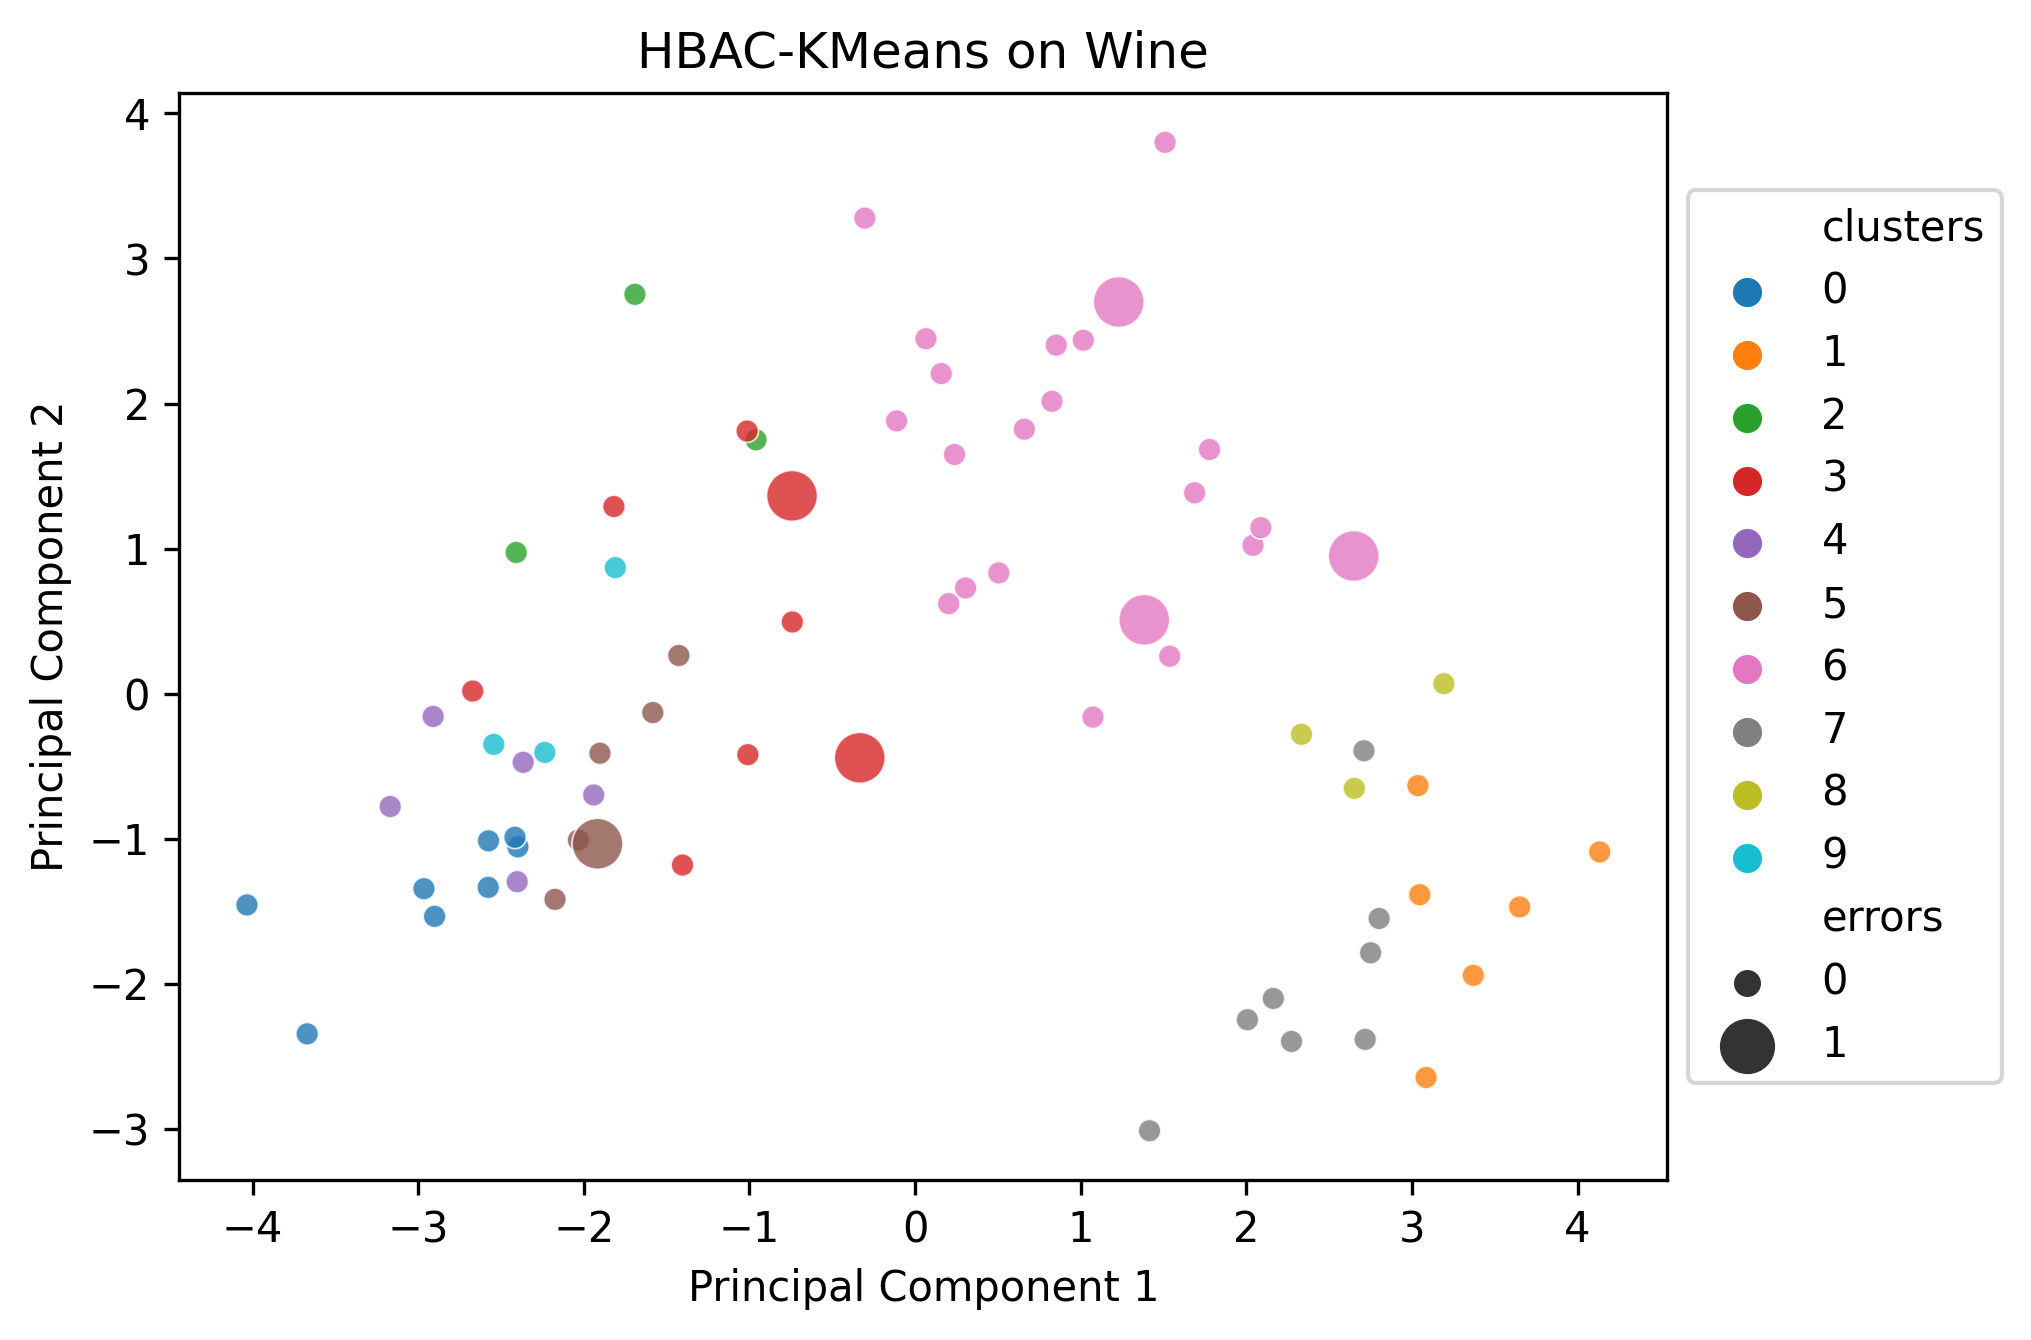

--> Cluster with the highest variance: 6
--> Cluster with the highest variance: 3
discriminating bias is: -999999
This is the random cluster we have picked: 6
MAX_ITER
[0.0001956085872169811, 0.005308245575562243, 0.011408077420006572, 0.011408077420006572, 0.01036484258166948, 0.01036484258166948, 0.011456517455714898, 0.011456517455714898, 0.011456517455714898, 0.012310603217348897, 0.012310603217348897, 0.011346854909331258, 0.011346854909331258, 0.011346854909331258, 0.011346854909331258, 0.010548942094538594, 0.010548942094538594, 0.00982878311464769]


In [27]:
# original code
MAX_ITER = 20
x = 0 # initial cluster number
initial_bias = 0
pca_plot(full_data, 'HBAC-KMeans on Wine', 0.8)
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data))
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x]

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply KMeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data, 'HBAC-KMeans on Wine', 0.8)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(variance_list)

### 1. Analysing the clustering results


In [34]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

6 has bias -0.0763636363636363
4 has bias 0.08955223880597019
7 has bias 0.09375
8 has bias 0.08695652173913049
0 has bias 0.09375
2 has bias 0.08695652173913049
1 has bias 0.09090909090909094
3 has bias -0.1875
9 has bias 0.08695652173913049
5 has bias -0.09090909090909083
cluster with the highest discriminating bias: 3
General accuracy of classifier on this dataset: 0.9166666666666666
cluster 3 has the highest discrimination bias
-0.1875


In [29]:
mean_clusters = pd.DataFrame()


unscaled_discr_plt = unscaled_discriminated.drop(['magnesium', 'proline'], axis=1)
unscaled_remain_plt = unscaled_remaining.drop(['magnesium', 'proline'], axis=1)
mean_clusters['unscaled_discriminated'] = unscaled_discr_plt.mean()
mean_clusters['unscaled_remaining'] = unscaled_remain_plt.mean()
# mean_clusters = mean_clusters.drop('magnesium', axis=1, inplace=True)
# mean_clusters = mean_clusters.drop('proline', axis=1, inplace=True)
# mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
mean_clusters_transpose = mean_clusters.T
# mean_clusters_transpose.rename(columns={'od280':'od280/od315'}, inplace=True)

mean_clusters_transpose['index'] = mean_clusters_transpose.index
mean_clusters_transpose.head()


def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(mean_clusters_transpose, "Parallel Coordinate Plot on Wine with HBAC-KMeans")

NameError: name 'unscaled_discriminated' is not defined

In [35]:
unscaled_wine = pd.DataFrame()
unscaled_wine = raw_data.copy(deep=True)
discriminated_cluster.index
unscaled_wine['discriminated'] = unscaled_wine.loc[discriminated_cluster.index, :]

NameError: name 'discriminated_cluster' is not defined

In [58]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

df = original_preprocessed

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph"),
    html.P("Select Distribution:"),
    dcc.RadioItems(
        id='dist-marginal',
        options=[{'label': x, 'value': x} 
                 for x in ['box', 'violin', 'rug']],
        value='box'
    )
])


@app.callback(
    Output("graph", "figure"), 
    [Input("dist-marginal", "value")])
def display_graph(marginal):
    fig = px.histogram(
        x="alcohol", y="malic_acid", color="discriminating",
        marginal=marginal, range_x=[-5, 60],
        hover_data=df.columns)

    return fig


if __name__ == "__main__":
    app.run_server(debug=False)


Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


In [45]:
original_preprocessed = raw_data.copy(deep=True)
original_preprocessed["discriminating"] = "remain"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

cluster = original_preprocessed.loc[discriminated_cluster.index]
cluster["discriminating"] = "biased"
original_preprocessed["discriminating"] = cluster["discriminating"].combine_first(original_preprocessed['discriminating'])
original_preprocessed

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
104    12.51        1.73  1.98               20.5       85.0           2.20   
67     12.37        1.17  1.92               19.6       78.0           2.11   
118    12.77        3.43  1.98               16.0       80.0           1.63   
39     14.22        3.99  2.51               13.2      128.0           3.00   
176    13.17        2.59  2.37               20.0      120.0           1.65   
..       ...         ...   ...                ...        ...            ...   
12     13.75        1.73  2.41               16.0       89.0           2.60   
47     13.90        1.68  2.12               16.0      101.0           3.10   
8      14.83        1.64  2.17               14.0       97.0           2.80   
124    11.87        4.31  2.39               21.0       82.0           2.86   
172    14.16        2.51  2.48               20.0       91.0           1.68   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
104        1.92                  0.32             1.48             2.94  1.04   
67         2.00                  0.27             1.04             4.68  1.12   
118        1.25                  0.43             0.83             3.40  0.70   
39         3.04                  0.20             2.08             5.10  0.89   
176        0.68                  0.53             1.46             9.30  0.60   
..          ...                   ...              ...              ...   ...   
12         2.76                  0.29             1.81             5.60  1.15   
47         3.39                  0.21             2.14             6.10  0.91   
8          2.98                  0.29             1.98             5.20  1.08   
124        3.03                  0.21             2.91             2.80  0.75   
172        0.70                  0.44             1.24             9.70  0.62   

     od280/od315  proline  predicted_class  true_class  errors discriminating  
104         3.57    672.0                1           1       0         remain  
67          3.48    510.0                1           1       0         remain  
118         2.12    372.0                2           1       1         remain  
39          3.53    760.0                0           0       0         remain  
176         1.62    840.0                2           2       0         remain  
..           ...      ...              ...         ...     ...            ...  
12          2.90   1320.0                0           0       0         remain  
47          3.33    985.0                0           0       0         remain  
8           2.85   1045.0                0           0       0         remain  
124         3.64    380.0                1           1       0         biased  
172         1.71    660.0                2           2       0         remain  

[72 rows x 17 columns]

In [47]:
import plotly.express as px
df = original_preprocessed
fig = px.histogram(df, x="alcohol", y="malic_acid", color="discriminating",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
fig.show()

In [48]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(200)
x2 = np.random.randn(200) + 2

group_labels = ['Group 1', 'Group 2']

colors = ['slategray', 'magenta']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1, x2], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

In [63]:
original_preprocessed

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
104    12.51        1.73  1.98               20.5       85.0           2.20   
67     12.37        1.17  1.92               19.6       78.0           2.11   
118    12.77        3.43  1.98               16.0       80.0           1.63   
39     14.22        3.99  2.51               13.2      128.0           3.00   
176    13.17        2.59  2.37               20.0      120.0           1.65   
..       ...         ...   ...                ...        ...            ...   
12     13.75        1.73  2.41               16.0       89.0           2.60   
47     13.90        1.68  2.12               16.0      101.0           3.10   
8      14.83        1.64  2.17               14.0       97.0           2.80   
124    11.87        4.31  2.39               21.0       82.0           2.86   
172    14.16        2.51  2.48               20.0       91.0           1.68   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
104        1.92                  0.32             1.48             2.94  1.04   
67         2.00                  0.27             1.04             4.68  1.12   
118        1.25                  0.43             0.83             3.40  0.70   
39         3.04                  0.20             2.08             5.10  0.89   
176        0.68                  0.53             1.46             9.30  0.60   
..          ...                   ...              ...              ...   ...   
12         2.76                  0.29             1.81             5.60  1.15   
47         3.39                  0.21             2.14             6.10  0.91   
8          2.98                  0.29             1.98             5.20  1.08   
124        3.03                  0.21             2.91             2.80  0.75   
172        0.70                  0.44             1.24             9.70  0.62   

     od280/od315  proline  predicted_class  true_class  errors discriminating  
104         3.57    672.0                1           1       0         remain  
67          3.48    510.0                1           1       0         remain  
118         2.12    372.0                2           1       1         remain  
39          3.53    760.0                0           0       0         remain  
176         1.62    840.0                2           2       0         remain  
..           ...      ...              ...         ...     ...            ...  
12          2.90   1320.0                0           0       0         remain  
47          3.33    985.0                0           0       0         remain  
8           2.85   1045.0                0           0       0         remain  
124         3.64    380.0                1           1       0         biased  
172         1.71    660.0                2           2       0         remain  

[72 rows x 17 columns]

In [62]:
import plotly.figure_factory as ff
import numpy as np
import pandas as pd

df = original_preprocessed
#df = pd.DataFrame({'2012': np.random.randn(200),
                #    '2013': np.random.randn(200)+1})
fig = ff.create_distplot([df[c] for c in df.columns], df.columns, bin_size=.25)
fig.show()


TypeError: can't multiply sequence by non-int of type 'float'

In [31]:
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

unscaled_wine = pd.DataFrame()
unscaled_wine = unscaled_discriminated.append(unscaled_discriminated)
unscaled_wine.info()

NameError: name 'discriminated_cluster' is not defined

In [36]:
discriminated_cluster = full_data[full_data['clusters']==c]

unscaled_discriminated = raw_wine.loc[discriminated_cluster.index, :]
# results 

print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)
# unscaling the discriminated cluster
unscaled_discriminated = raw_wine.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


research_dbscan = pd.DataFrame()
research_dbscan['unscaled_discriminated'] = unscaled_discriminated.mean()
research_dbscan['unscaled_remaining'] = unscaled_remaining.mean()
research_dbscan['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()

display(research_dbscan)


mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
# mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
mean_clusters_transpose = mean_clusters.T
# mean_clusters_transpose.rename(columns={'od280':'od280/od315'}, inplace=True)

mean_clusters_transpose['index'] = mean_clusters_transpose.index
mean_clusters_transpose.head()


# def create_parallel_coord_plot(copy_research_transpose, title):
#     disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
#     plt.xticks(rotation=90)
#     plt.legend(loc="upper left")
#     plt.xlabel("Features")
#     plt.ylabel("Values")
#     plt.grid(linewidth=0.2)
#     plt.title(title)
#     plt.show()

# create_parallel_coord_plot(mean_clusters_transpose, "Parallel Coordinate Plot on COMPAS with HBAC-KMeans")

Number of instances in discriminated cluster: 8
Number of errors in discriminated clusters:  2
found discriminated cluster:


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
99  -0.948782    0.777703 -0.386741          -0.241232  -0.793991   
121 -1.876903   -0.201438  3.072728           2.709765   0.960650   
98  -0.847070   -1.058186 -0.759821          -0.100709  -0.793991   
81  -0.402080   -0.411254 -0.420657          -0.016394  -0.907193   
21  -0.135086    1.328470  1.105579          -0.072604  -0.001572   
43   0.259048    1.485832 -0.115410          -0.381756   0.055029   
73  -0.058802   -0.533646  0.935997           3.131336   2.092677   
124 -1.482769    1.774329  0.223754           0.601910  -1.133599   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
99        0.848422    0.860412              0.759988         1.882064   
121       1.345304    2.810041              0.920691         0.402472   
98        1.857243    1.569368             -0.927387         0.528395   
81       -0.130285    0.431307             -0.766684         0.245068   
21        0.185913    0.319367             -0.847035         0.575616   
43        0.532224    0.524591             -0.284577         0.071925   
73        1.525989    0.767129             -1.168440         0.544135   
124       0.863479    0.897726             -1.168440         2.039468   

     color_intensity       hue  od280/od315   proline  scaled_errors  \
99         -1.314906  2.019289     0.324136 -1.028209            0.0   
121         0.357127 -0.118782     1.521661 -0.850221            0.0   
98         -0.320724  0.361193     0.240588 -0.261954            0.0   
81         -0.591864  0.884802     0.755802 -0.099050            0.8   
21         -0.320724  0.317559     1.284941  0.069888            0.0   
43         -0.383990 -0.598757     0.560856 -0.201619            0.8   
73         -0.840410  1.539314     1.257091  0.718489            0.0   
124        -1.088955 -0.904195     1.452037 -1.106644            0.0   

     predicted_class  true_class  errors  clusters  new_clusters  
99                 1           1       0         3           0.0  
121                1           1       0         3           1.0  
98                 1           1       0         3           0.0  
81                 0           1       1         3           0.0  
21                 0           0       0         3           0.0  
43                 1           0       1         3           0.0  
73                 1           1       0         3           1.0  
124                1           1       0         3           0.0

alcohol
this is the t-statistic -2.6641717441708916
this is the p-value: 0.0227101400202362
malic_acid
this is the t-statistic 1.111678007204041
this is the p-value: 0.29648195124075016
ash
this is the t-statistic 1.1265181924810592
this is the p-value: 0.2922158773267053
alcalinity_of_ash
this is the t-statistic 1.5552171165188697
this is the p-value: 0.15957688531649755
magnesium
this is the t-statistic -0.17803782224518103
this is the p-value: 0.8628695162595327
total_phenols
this is the t-statistic 3.6650863791357695
this is the p-value: 0.0036387147073124685
flavanoids
this is the t-statistic 3.6713789946978337
this is the p-value: 0.004633814465702954
nonflavanoid_phenols
this is the t-statistic -1.5220939741679107
this is the p-value: 0.1595547958646598
proanthocyanins
this is the t-statistic 3.0335143940150657
this is the p-value: 0.012056572841137913
color_intensity
this is the t-statistic -2.808049656617349
this is the p-value: 0.013185152416840913
hue
this is the t-statistic

unscaled_discriminated  unscaled_remaining  difference
alcohol                             12.49625           13.103750   -0.607500
malic_acid                           2.73250            2.223906    0.508594
ash                                  2.45875            2.307188    0.151562
alcalinity_of_ash                   21.36250           18.545313    2.817187
magnesium                          100.87500          102.171875   -1.296875
total_phenols                        2.87000            2.213594    0.656406
flavanoids                           3.16375            1.930625    1.233125
nonflavanoid_phenols                 0.30125            0.362187   -0.060937
proanthocyanins                      2.11375            1.551875    0.561875
color_intensity                      3.96375            5.365469   -1.401719
hue                                  1.05750            0.944687    0.112813
od280/od315                          3.26125            2.514219    0.747031
proline                            632.50000          761.125000 -128.625000
predicted_class                      0.75000            0.968750   -0.218750
true_class                           0.75000            0.937500   -0.187500
errors                               0.25000            0.062500    0.187500

alcohol  malic_acid       ash  alcalinity_of_ash  \
unscaled_discriminated  12.49625    2.732500  2.458750          21.362500   
unscaled_remaining      13.10375    2.223906  2.307188          18.545313   

                         magnesium  total_phenols  flavanoids  \
unscaled_discriminated  100.875000       2.870000    3.163750   
unscaled_remaining      102.171875       2.213594    1.930625   

                        nonflavanoid_phenols  proanthocyanins  \
unscaled_discriminated              0.301250         2.113750   
unscaled_remaining                  0.362187         1.551875   

                        color_intensity       hue  od280/od315  proline  \
unscaled_discriminated         3.963750  1.057500     3.261250  632.500   
unscaled_remaining             5.365469  0.944687     2.514219  761.125   

                        predicted_class  true_class  errors  \
unscaled_discriminated          0.75000      0.7500  0.2500   
unscaled_remaining              0.96875      0.9375  0.0625   

                                         index  
unscaled_discriminated  unscaled_discriminated  
unscaled_remaining          unscaled_remaining

In [43]:
unscaled_remaining = raw_data.drop(discriminated_cluster.index)
unscaled_discriminated

# display(unscaled_wine)

unscaled_wine = unscaled_wine.loc[discriminated_cluster.index]
unscaled_wine['discriminated'] = "biased_cluster"
unscaled_wine = unscaled_discriminated.append(unscaled_remaining)
# unscaled_wine.drop(['undiscriminated'], axis=0)
unscaled_wine
# cluster = original_preprocessed.loc[bias_index]
# cluster["analysis_plot"] = "biased"

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
99     12.29        3.17  2.21               18.0       88.0           2.85   
121    11.56        2.05  3.23               28.5      119.0           3.18   
98     12.37        1.07  2.10               18.5       88.0           3.52   
81     12.72        1.81  2.20               18.8       86.0           2.20   
21     12.93        3.80  2.65               18.6      102.0           2.41   
..       ...         ...   ...                ...        ...            ...   
31     13.58        1.66  2.36               19.1      106.0           2.86   
12     13.75        1.73  2.41               16.0       89.0           2.60   
47     13.90        1.68  2.12               16.0      101.0           3.10   
8      14.83        1.64  2.17               14.0       97.0           2.80   
172    14.16        2.51  2.48               20.0       91.0           1.68   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
99         2.99                  0.45             2.81              2.3  1.42   
121        5.08                  0.47             1.87              6.0  0.93   
98         3.75                  0.24             1.95              4.5  1.04   
81         2.53                  0.26             1.77              3.9  1.16   
21         2.41                  0.25             1.98              4.5  1.03   
..          ...                   ...              ...              ...   ...   
31         3.19                  0.22             1.95              6.9  1.09   
12         2.76                  0.29             1.81              5.6  1.15   
47         3.39                  0.21             2.14              6.1  0.91   
8          2.98                  0.29             1.98              5.2  1.08   
172        0.70                  0.44             1.24              9.7  0.62   

     od280/od315  proline  predicted_class  true_class  errors  
99          2.83    406.0                1           1       0  
121         3.69    465.0                1           1       0  
98          2.77    660.0                1           1       0  
81          3.14    714.0                0           1       1  
21          3.52    770.0                0           0       0  
..           ...      ...              ...         ...     ...  
31          2.88   1515.0                0           0       0  
12          2.90   1320.0                0           0       0  
47          3.33    985.0                0           0       0  
8           2.85   1045.0                0           0       0  
172         1.71    660.0                2           2       0  

[72 rows x 16 columns]

In [44]:
# results 
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)
# unscaling the discriminated cluster
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


research_dbscan = pd.DataFrame()
research_dbscan['unscaled_discriminated'] = unscaled_discriminated.mean()
research_dbscan['unscaled_remaining'] = unscaled_remaining.mean()
research_dbscan['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()

display(research_dbscan)


mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
# mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
mean_clusters_transpose = mean_clusters.T
# mean_clusters_transpose.rename(columns={'od280':'od280/od315'}, inplace=True)

mean_clusters_transpose['index'] = mean_clusters_transpose.index
mean_clusters_transpose.head()


# def create_parallel_coord_plot(copy_research_transpose, title):
#     disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
#     plt.xticks(rotation=90)
#     plt.legend(loc="upper left")
#     plt.xlabel("Features")
#     plt.ylabel("Values")
#     plt.grid(linewidth=0.2)
#     plt.title(title)
#     plt.show()

# create_parallel_coord_plot(mean_clusters_transpose, "Parallel Coordinate Plot on COMPAS with HBAC-KMeans")

Number of instances in discriminated cluster: 8
Number of errors in discriminated clusters:  2
found discriminated cluster:


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
99  -0.948782    0.777703 -0.386741          -0.241232  -0.793991   
121 -1.876903   -0.201438  3.072728           2.709765   0.960650   
98  -0.847070   -1.058186 -0.759821          -0.100709  -0.793991   
81  -0.402080   -0.411254 -0.420657          -0.016394  -0.907193   
21  -0.135086    1.328470  1.105579          -0.072604  -0.001572   
43   0.259048    1.485832 -0.115410          -0.381756   0.055029   
73  -0.058802   -0.533646  0.935997           3.131336   2.092677   
124 -1.482769    1.774329  0.223754           0.601910  -1.133599   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
99        0.848422    0.860412              0.759988         1.882064   
121       1.345304    2.810041              0.920691         0.402472   
98        1.857243    1.569368             -0.927387         0.528395   
81       -0.130285    0.431307             -0.766684         0.245068   
21        0.185913    0.319367             -0.847035         0.575616   
43        0.532224    0.524591             -0.284577         0.071925   
73        1.525989    0.767129             -1.168440         0.544135   
124       0.863479    0.897726             -1.168440         2.039468   

     color_intensity       hue  od280/od315   proline  scaled_errors  \
99         -1.314906  2.019289     0.324136 -1.028209            0.0   
121         0.357127 -0.118782     1.521661 -0.850221            0.0   
98         -0.320724  0.361193     0.240588 -0.261954            0.0   
81         -0.591864  0.884802     0.755802 -0.099050            0.8   
21         -0.320724  0.317559     1.284941  0.069888            0.0   
43         -0.383990 -0.598757     0.560856 -0.201619            0.8   
73         -0.840410  1.539314     1.257091  0.718489            0.0   
124        -1.088955 -0.904195     1.452037 -1.106644            0.0   

     predicted_class  true_class  errors  clusters  new_clusters  
99                 1           1       0         3          -1.0  
121                1           1       0         3          -1.0  
98                 1           1       0         3          -1.0  
81                 0           1       1         3          -1.0  
21                 0           0       0         3          -1.0  
43                 1           0       1         3          -1.0  
73                 1           1       0         3          -1.0  
124                1           1       0         3          -1.0

alcohol
this is the t-statistic -2.6641717441708916
this is the p-value: 0.0227101400202362
malic_acid
this is the t-statistic 1.111678007204041
this is the p-value: 0.29648195124075016
ash
this is the t-statistic 1.1265181924810592
this is the p-value: 0.2922158773267053
alcalinity_of_ash
this is the t-statistic 1.5552171165188697
this is the p-value: 0.15957688531649755
magnesium
this is the t-statistic -0.17803782224518103
this is the p-value: 0.8628695162595327
total_phenols
this is the t-statistic 3.6650863791357695
this is the p-value: 0.0036387147073124685
flavanoids
this is the t-statistic 3.6713789946978337
this is the p-value: 0.004633814465702954
nonflavanoid_phenols
this is the t-statistic -1.5220939741679107
this is the p-value: 0.1595547958646598
proanthocyanins
this is the t-statistic 3.0335143940150657
this is the p-value: 0.012056572841137913
color_intensity
this is the t-statistic -2.808049656617349
this is the p-value: 0.013185152416840913
hue
this is the t-statistic

unscaled_discriminated  unscaled_remaining  difference
alcohol                             12.49625           13.103750   -0.607500
malic_acid                           2.73250            2.223906    0.508594
ash                                  2.45875            2.307188    0.151562
alcalinity_of_ash                   21.36250           18.545313    2.817187
magnesium                          100.87500          102.171875   -1.296875
total_phenols                        2.87000            2.213594    0.656406
flavanoids                           3.16375            1.930625    1.233125
nonflavanoid_phenols                 0.30125            0.362187   -0.060937
proanthocyanins                      2.11375            1.551875    0.561875
color_intensity                      3.96375            5.365469   -1.401719
hue                                  1.05750            0.944687    0.112813
od280/od315                          3.26125            2.514219    0.747031
proline                            632.50000          761.125000 -128.625000
predicted_class                      0.75000            0.968750   -0.218750
true_class                           0.75000            0.937500   -0.187500
errors                               0.25000            0.062500    0.187500

alcohol  malic_acid       ash  alcalinity_of_ash  \
unscaled_discriminated  12.49625    2.732500  2.458750          21.362500   
unscaled_remaining      13.10375    2.223906  2.307188          18.545313   

                         magnesium  total_phenols  flavanoids  \
unscaled_discriminated  100.875000       2.870000    3.163750   
unscaled_remaining      102.171875       2.213594    1.930625   

                        nonflavanoid_phenols  proanthocyanins  \
unscaled_discriminated              0.301250         2.113750   
unscaled_remaining                  0.362187         1.551875   

                        color_intensity       hue  od280/od315  proline  \
unscaled_discriminated         3.963750  1.057500     3.261250  632.500   
unscaled_remaining             5.365469  0.944687     2.514219  761.125   

                        predicted_class  true_class  errors  \
unscaled_discriminated          0.75000      0.7500  0.2500   
unscaled_remaining              0.96875      0.9375  0.0625   

                                         index  
unscaled_discriminated  unscaled_discriminated  
unscaled_remaining          unscaled_remaining

In [209]:
# ridge plot
# column_names = unscaled_discriminated.iloc[: , : ].columns
column_names = unscaled_remaining.iloc[: , : ].columns
# full_data.iloc[: , : 24]
column_names

# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example

# column_names = discriminated_cluster.iloc[: , : 14].columns
df = unscaled_discriminated[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="HBAC-KMeans on Wine: Remaining Clusters distribution",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

In [119]:
unscaled_discriminated.rename(columns={'od280/od315_of_diluted_wines':'od280/od315'}, inplace=True)
unscaled_remaining.rename(columns={'od280/od315_of_diluted_wines':'od280/od315'}, inplace=True)

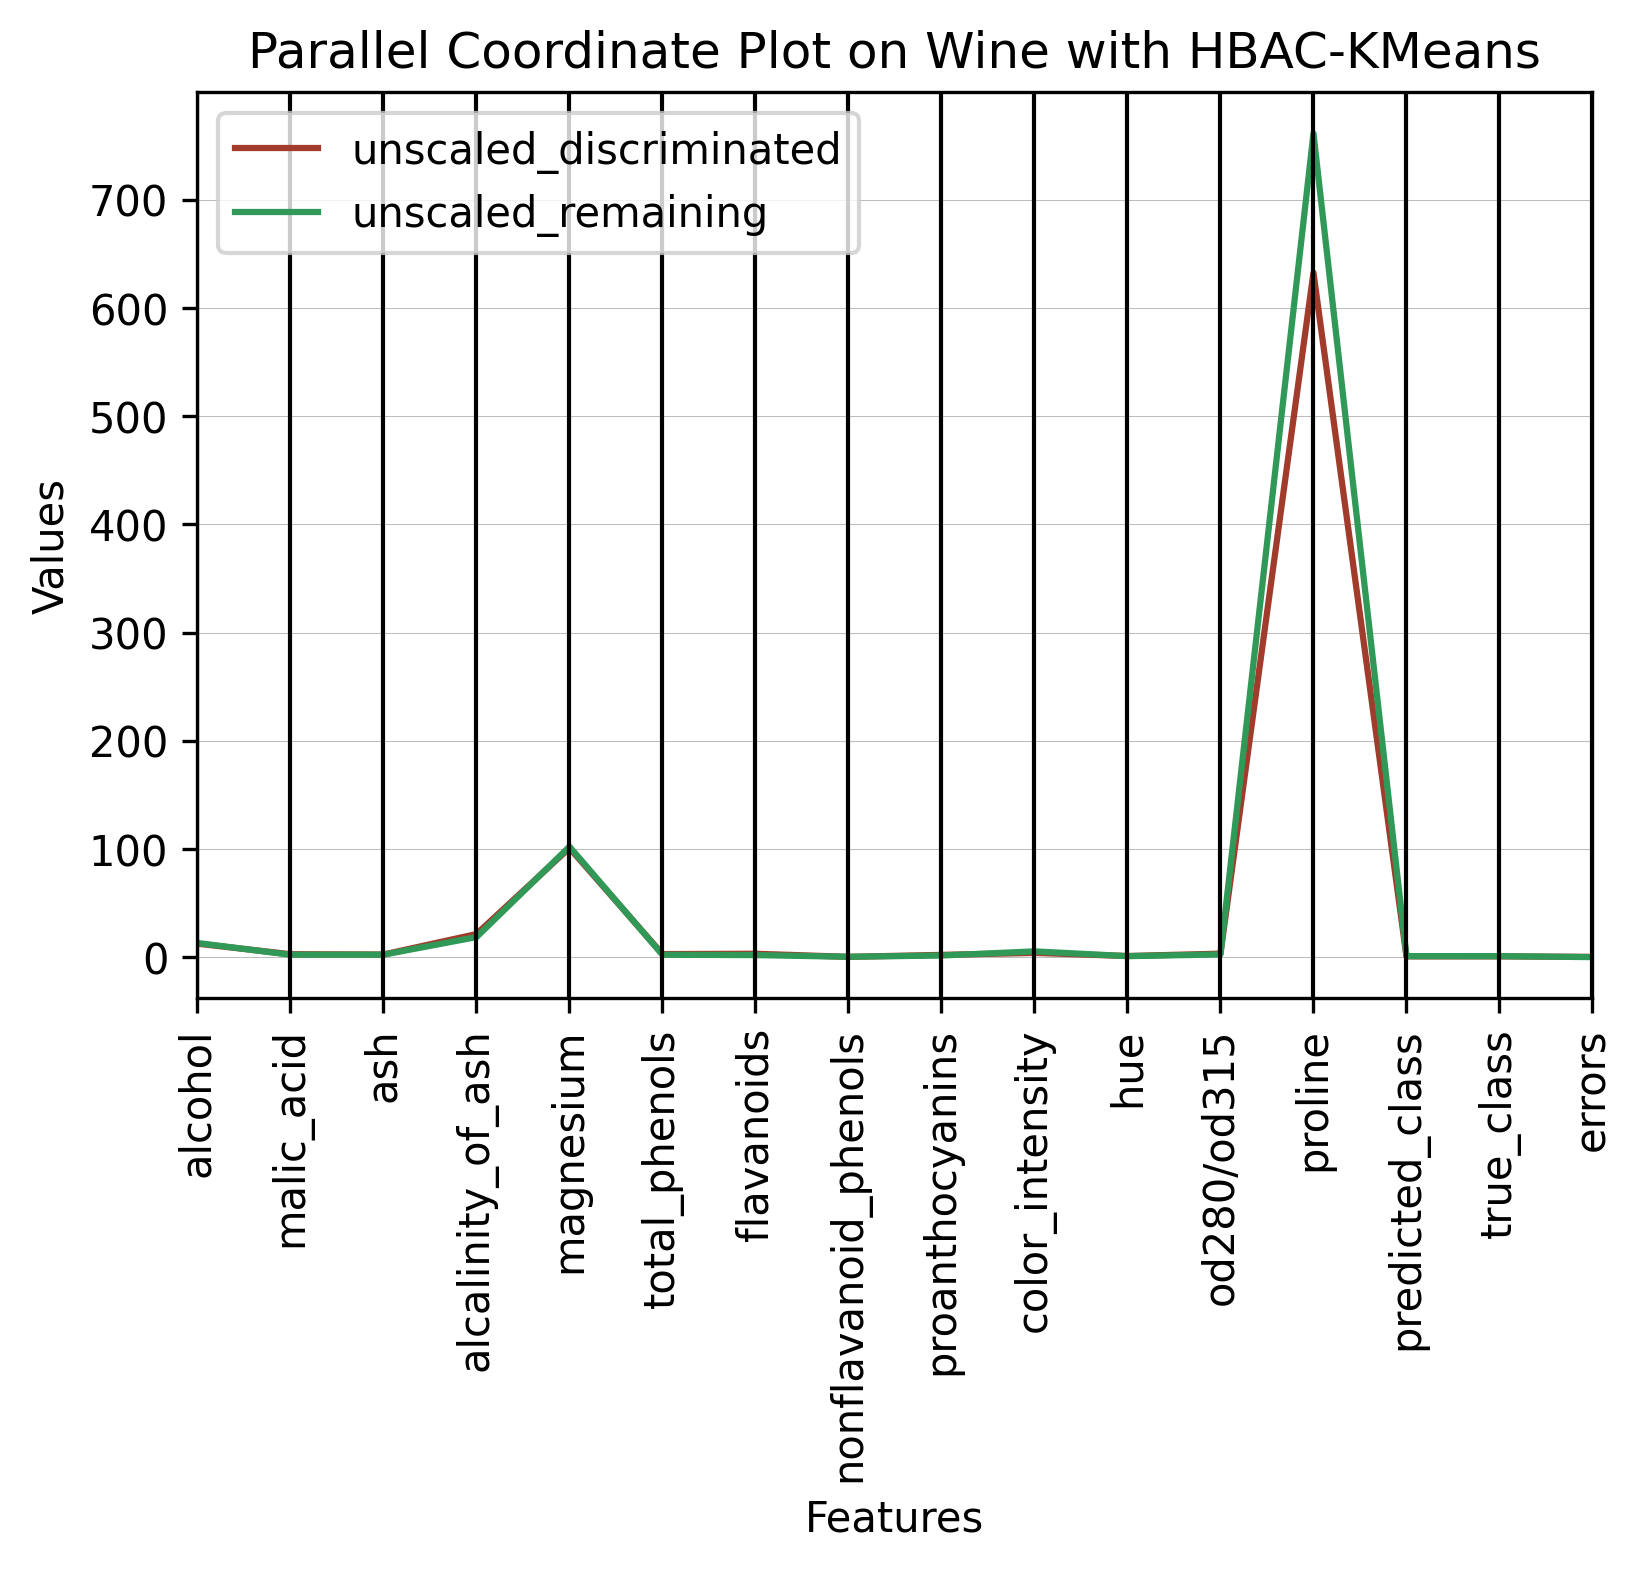

In [123]:

mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
# mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
mean_clusters_transpose = mean_clusters.T
# mean_clusters_transpose.rename(columns={'od280':'od280/od315'}, inplace=True)

mean_clusters_transpose['index'] = mean_clusters_transpose.index
mean_clusters_transpose.head(



def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(mean_clusters_transpose, "Parallel Coordinate Plot on Wine with HBAC-KMeans")

In [20]:
import scipy.stats as stats

In [34]:
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the p-value:', welch_i.pvalue)

alcohol
this is the p-value: 0.0227101400202362
malic_acid
this is the p-value: 0.29648195124075016
ash
this is the p-value: 0.2922158773267053
alcalinity_of_ash
this is the p-value: 0.15957688531649755
magnesium
this is the p-value: 0.8628695162595327
total_phenols
this is the p-value: 0.0036387147073124685
flavanoids
this is the p-value: 0.004633814465702954
nonflavanoid_phenols
this is the p-value: 0.1595547958646598
proanthocyanins
this is the p-value: 0.012056572841137913
color_intensity
this is the p-value: 0.013185152416840913
hue
this is the p-value: 0.22570305810934377
od280/od315_of_diluted_wines
this is the p-value: 0.0002957445162112846
proline
this is the p-value: 0.15271974289061202
predicted_class
this is the p-value: 0.27414644282584116
true_class
this is the p-value: 0.3453441500388015
errors
this is the p-value: 0.29482855868283164


In [206]:
research = pd.DataFrame()
research['unscaled_discriminated'] = unscaled_discriminated.mean()
research['unscaled_remaining'] = unscaled_remaining.mean()
research['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()

research

unscaled_discriminated  unscaled_remaining  difference
Number_of_Priors                    0.937500            3.357383   -2.419883
score_factor                        0.078125            0.454139   -0.376014
Age_Above_FourtyFive                0.000000            0.205817   -0.205817
Age_Below_TwentyFive                0.250000            0.215884    0.034116
African_American                    0.000000            0.534116   -0.534116
Asian                               0.000000            0.004474   -0.004474
Hispanic                            0.000000            0.087248   -0.087248
Native_American                     0.000000            0.001678   -0.001678
Other                               1.000000            0.016779    0.983221
Female                              0.156250            0.186242   -0.029992
Misdemeanor                         0.421875            0.358501    0.063374
predicted_class                     0.140625            0.423937   -0.283312
true_class                          0.375000            0.458054   -0.083054
errors                              0.390625            0.324944    0.065681

# RidgePlot HBAC - KMeans


In [128]:
# ridge plot
column_names = unscaled_discriminated.iloc[: , : ].columns
# full_data.iloc[: , : 24]
column_names

# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example

# column_names = discriminated_cluster.iloc[: , : 14].columns
df = unscaled_discriminated[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="HBAC-KMeans on Wine: Remaining Clusters distribution",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue', 'od280/od315', 'proline',
       'predicted_class', 'true_class', 'errors'],
      dtype='object')

Text(0.5, 1.0, 'Variance of Instances during Iterations')

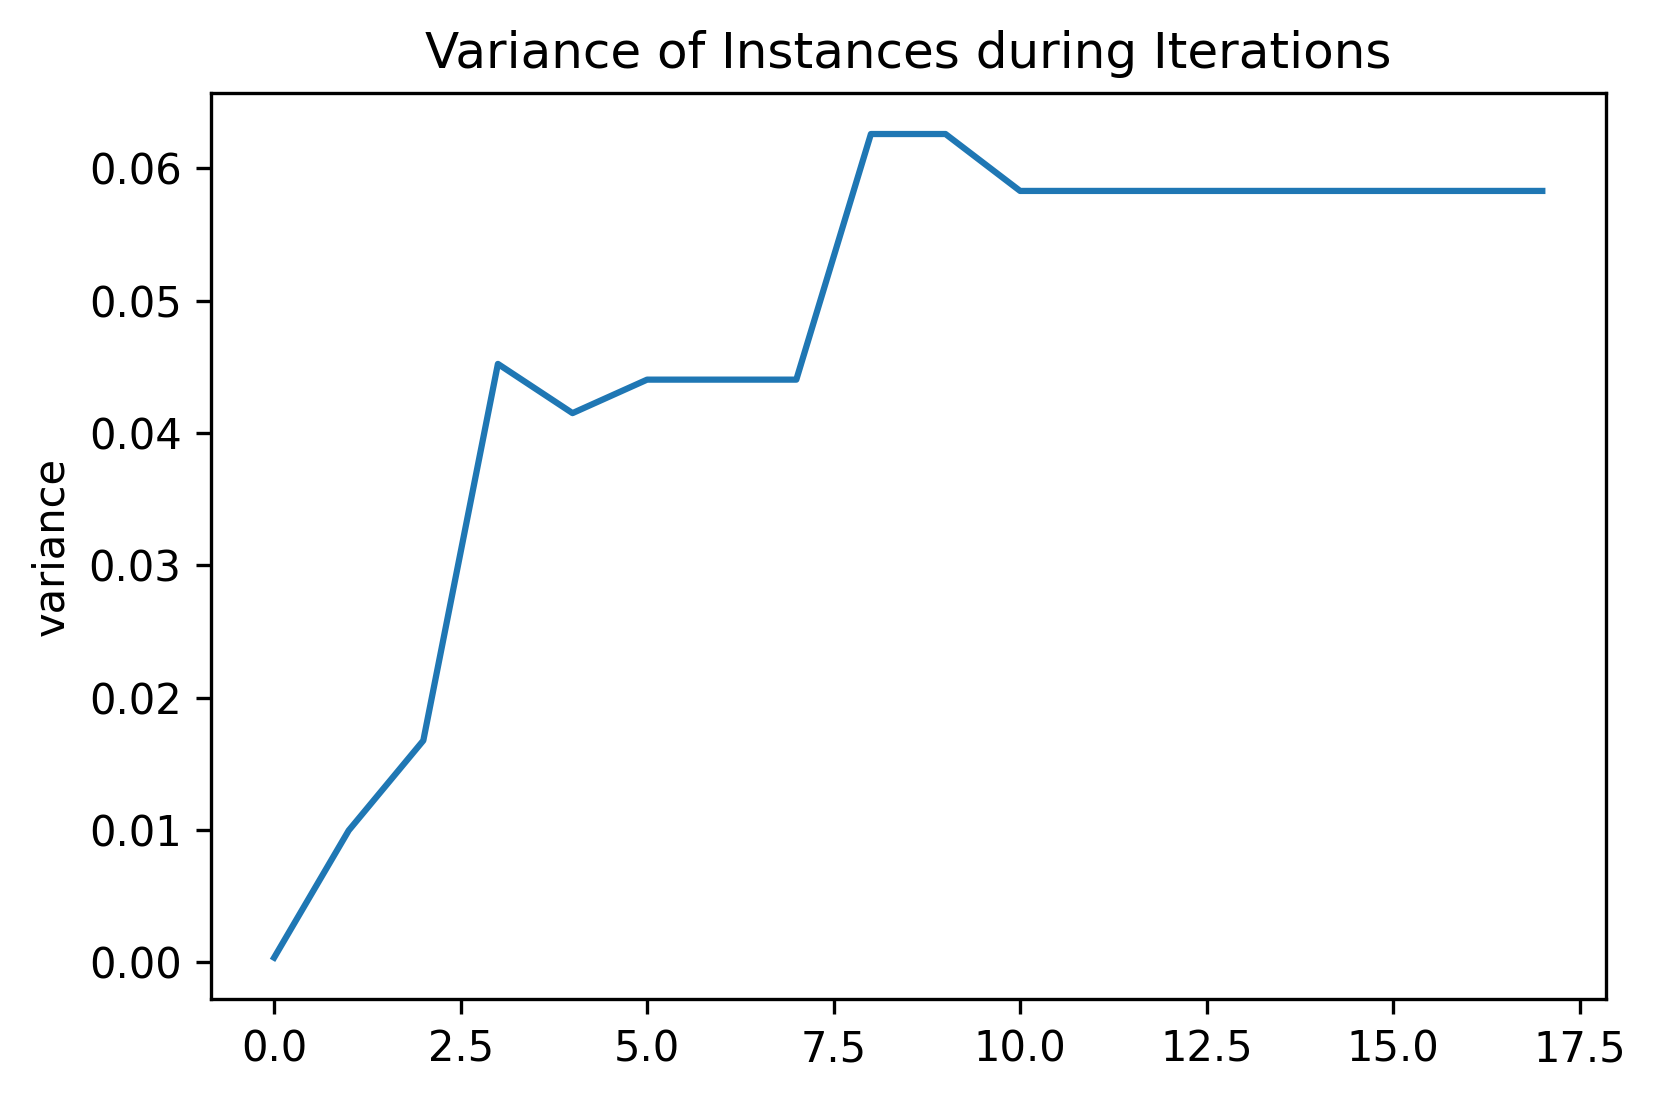

In [47]:
variance_df_kmeans = pd.DataFrame(variance_list).rename(columns={0:"variance"})
sns.lineplot(data=variance_df_kmeans, x=variance_df_kmeans.index,y="variance").set_title('Variance of Instances during Iterations')

## Baseline KMeans

In [ ]:
full_data = initialize_dataset(raw_data)
full_data.head()

In [ ]:
# Same number of clusters as the found clusters by the bias-aware clustering algorithm?
baseline_kmeans = KMeans(n_clusters=11, init="k-means++", n_init=10, max_iter=300, random_state=2).fit(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))

full_data['clusters'] = pd.DataFrame(baseline_kmeans.predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',
                    'errors'], axis=1)),index=full_data.index) 


In [ ]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinekm = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found discrimination bias:', most_biased_cluster_baselinekm)

In [ ]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

In [ ]:
# Full dataset ridgeplot

df = raw_data
column_names = raw_data.iloc[: , : 12].columns

df = df[column_names]
df.head()

In [ ]:
# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example
# column_names = ["x", "y", "scaled_errors", "errors"]
# column_names = discriminated_cluster.iloc[: , : 14].columns
# df = df[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="What is the distribution of the highly discriminated cluster?",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

# 2. Bias-Aware DBSCAN

In [230]:
full_data = initialize_dataset(raw_data)
full_data.head()


Number_of_Priors  score_factor  Age_Above_FourtyFive  \
4590         -0.672808      1.125535             -0.497974   
2482          0.560285      1.125535             -0.497974   
4092         -0.672808     -0.888466              2.008136   
165          -0.672808     -0.888466             -0.497974   
1109          1.587862      1.125535             -0.497974   

      Age_Below_TwentyFive  African_American     Asian  Hispanic  \
4590              1.899201          0.969158 -0.065866 -0.303284   
2482              1.899201         -1.031824 -0.065866 -0.303284   
4092             -0.526537         -1.031824 -0.065866 -0.303284   
165               1.899201          0.969158 -0.065866 -0.303284   
1109             -0.526537         -1.031824 -0.065866  3.297240   

      Native_American     Other    Female  Misdemeanor  scaled_errors  \
4590         -0.04028 -0.231235 -0.476763     1.331336            0.8   
2482         -0.04028 -0.231235 -0.476763    -0.751125            0.8   
4092         -0.04028  4.324596  2.097479    -0.751125            0.8   
165          -0.04028 -0.231235 -0.476763    -0.751125            0.8   
1109         -0.04028 -0.231235 -0.476763     1.331336            0.8   

      predicted_class  true_class  errors  clusters  new_clusters  
4590                0           1       1         0            -1  
2482                1           0       1         0            -1  
4092                0           1       1         0            -1  
165                 0           1       1         0            -1  
1109                1           0       1         0            -1

## Determining epsilon

Text(0.5, 1.0, 'Optimal Value of Epsilon for COMPAS')

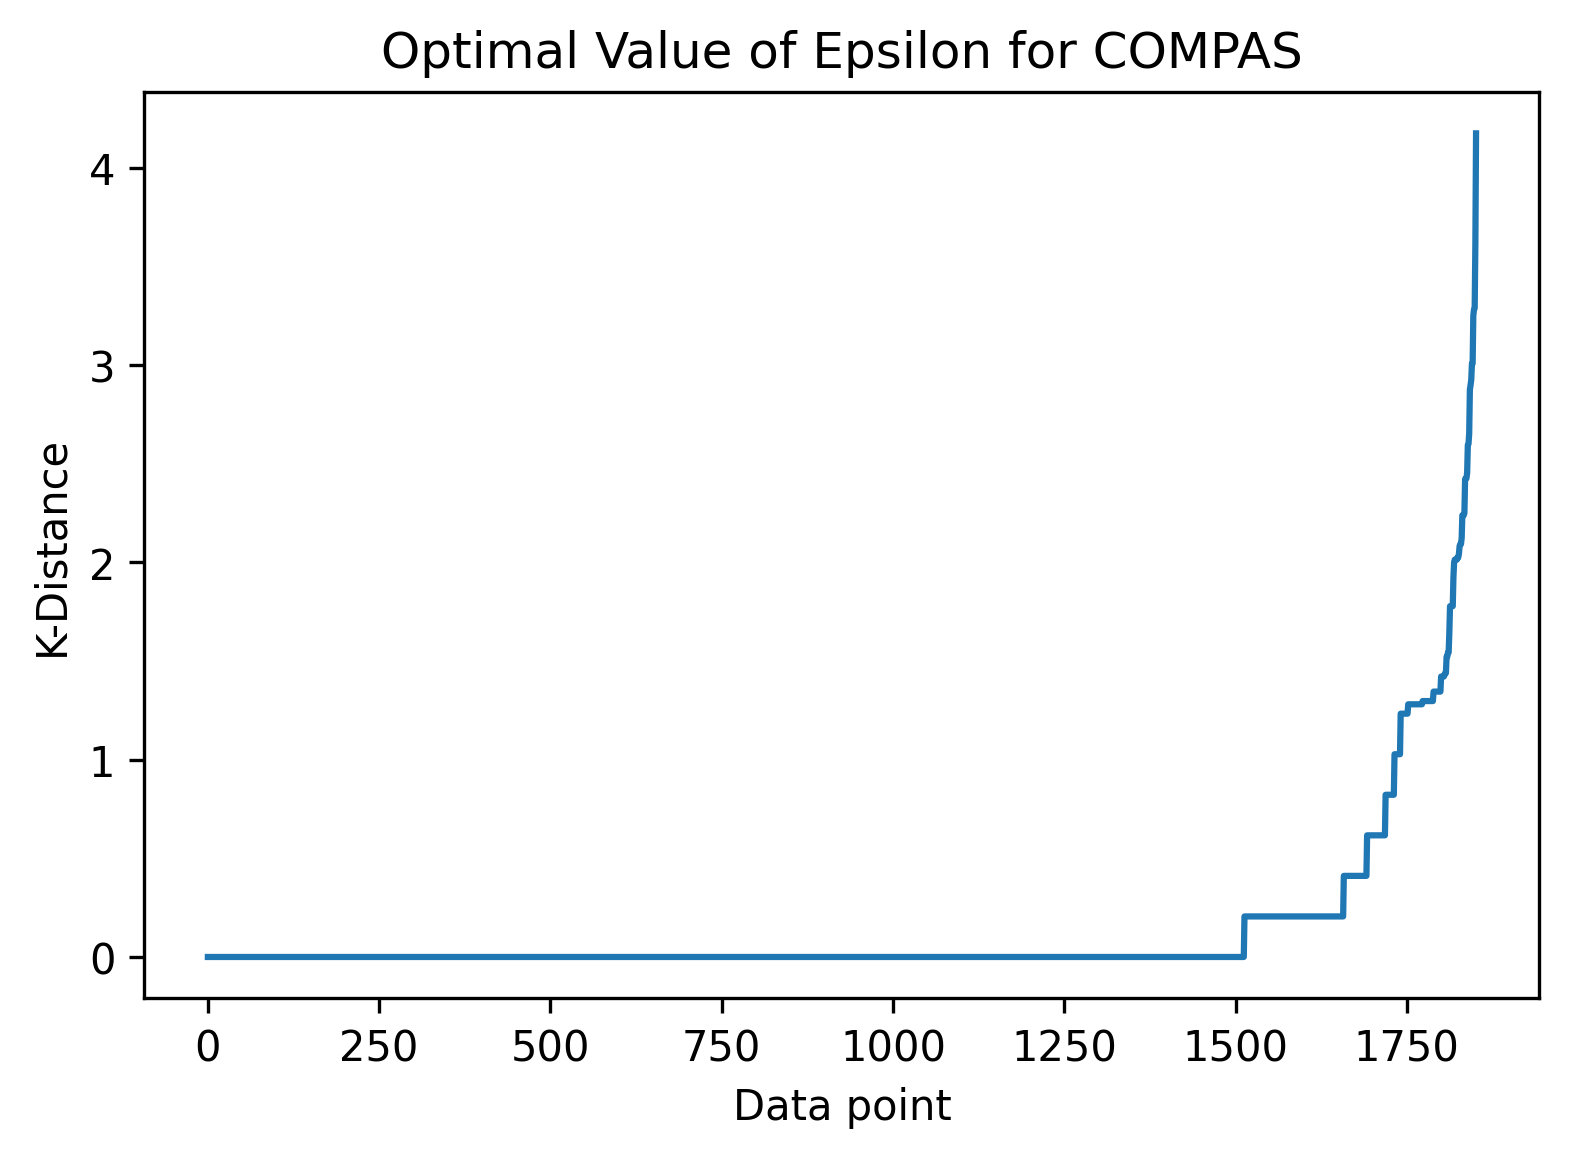

In [221]:
# determining epsilon
from sklearn.neighbors import NearestNeighbors

#for wine dataset
# nn_features = full_data.iloc[: , : 14] #wine + including scaled errors
# for german credit:
# nn_features = full_data.iloc[: , : 25]

# for compas:
nn_features = full_data.iloc[: , : 14]

neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-Distance')
plt.title('Optimal Value of Epsilon for COMPAS')

# plt.savefig('dbscan_wine_epsilon.png', dpi=300)

In [ ]:
round(0.05 * len(full_data))

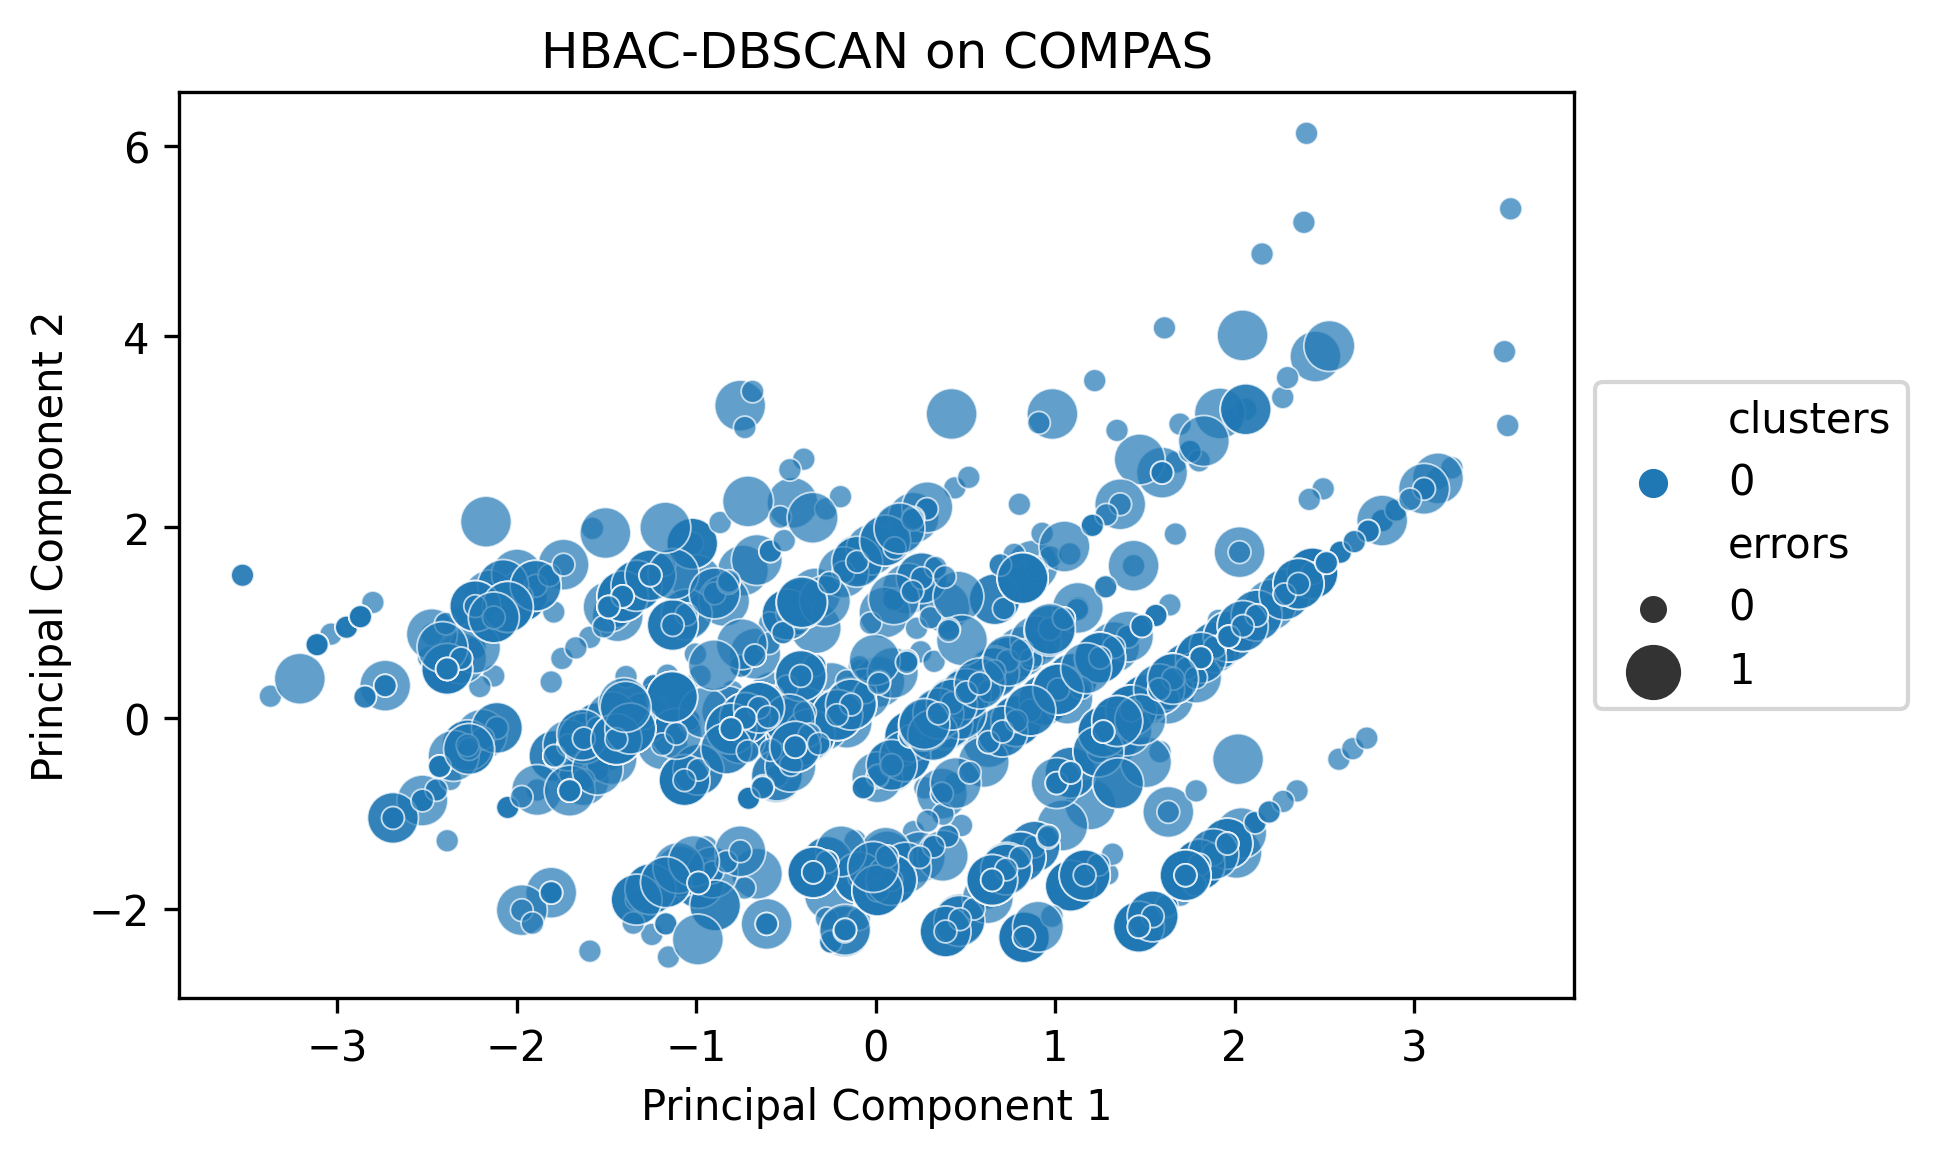

this is the current cluster:  0
discriminating bias is: -999999
smallest cluster:  3
This is the random cluster we have picked: 0
this is the current cluster:  0
discriminating bias is: -999999
smallest cluster:  3
This is the random cluster we have picked: 1
this is the current cluster:  1
This is the random cluster we have picked: 0
this is the current cluster:  0
discriminating bias is: -999999
smallest cluster:  3
This is the random cluster we have picked: 0
this is the current cluster:  0
discriminating bias is: -999999
smallest cluster:  3
This is the random cluster we have picked: 0
this is the current cluster:  0
discriminating bias is: -999999
smallest cluster:  3
This is the random cluster we have picked: 1
this is the current cluster:  1
This is the random cluster we have picked: 0
this is the current cluster:  0
discriminating bias is: -999999
smallest cluster:  3
This is the random cluster we have picked: 1
this is the current cluster:  1
This is the random cluster we have

In [231]:
MAX_ITER = 30
epsilon =  0.5
minimum_samples = 3 # round(0.02 * len(full_data)) # 2*dim?
x = 0 # cluster number
initial_bias = 0
pca_plot(full_data, 'HBAC-DBSCAN on COMPAS', 0.7)
variance_list = []
minimal_splittable_cluster_size = round(0.03 * len(full_data))
minimal_acceptable_cluster_size = round(0.01 * len(full_data))
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    print('this is the current cluster: ', x)
    epsilon = epsilon + 0.001
    if len(full_data['clusters'].unique()) != 1:
        variance_list.append(calculate_variance(full_data))

    full_data['new_clusters'] = -2
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    
    if (len(full_data['new_clusters'].unique()) <= 2): # to check whether a new cluster is found
        continue

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster: ", min_new_size)
    
    if (max_neg_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #>
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        # print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif (clstr == -2):
                continue
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1

        pca_plot(full_data, 'HBAC-DBSCAN on COMPAS', 0.7)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(average_accuracy)
print(variance_list)

## 2. DBSCAN Results

In [226]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data) #shouldn't this be max_neg_bias_cluster
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_dbscan_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_dbscan_aware)

This cluster is the entire dataset. Cluster:  0
You are calculating the accuracy on a empty cluster


ZeroDivisionError: division by zero

In [143]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster



Number of instances in discriminated cluster: 18
Number of errors in discriminated clusters:  2


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
118 -0.338510    1.005004 -1.166817          -0.803327  -1.246801   
176  0.170050    0.270648  0.155921           0.320862   1.017252   
131 -0.198656    0.620341  0.257670           0.320862   0.111630   
164  0.945603    0.419268 -0.081493           0.882957  -0.680788   
154 -0.580076   -0.865855 -0.759821           0.320862   0.055029   
137 -0.643646    2.823409  1.071663           1.726099  -0.341180   
160 -0.859784    1.354697  0.189837           0.601910  -0.793991   
156  1.021887    1.608225  0.189837           0.180339  -0.737389   
173  0.856605    2.945801  0.427252           0.461386  -0.397782   
140 -0.135086    0.462979  1.275161           0.601910  -0.341180   
150  0.589611    0.733992  1.003830           1.445052   1.187056   
147 -0.211370    2.036599  0.529001           0.742434  -0.907193   
167 -0.274940    0.952550 -0.081493           0.180339  -0.793991   
146  1.072743    2.412519 -0.318908           0.320862  -1.246801   
170 -1.063208    0.655311 -0.013661           0.039815  -0.341180   
130 -0.224084   -0.813401 -0.013661          -0.241232   1.130454   
138  0.576897    1.144881 -0.454573           0.180339  -0.793991   
172  1.428735    0.200709  0.529001           0.320862  -0.624187   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
118      -0.988536   -0.762724              0.599286        -1.234524   
176      -0.958422   -1.294440              1.402798        -0.242882   
131      -1.485418   -0.790709             -0.927387        -1.234524   
164      -1.410133   -1.294440              0.438584        -0.919717   
154      -1.214392   -1.387724              1.402798        -0.337324   
137      -0.747624   -1.369067              2.206310        -0.809535   
160       0.020285   -1.070560              1.161744        -0.903977   
156      -0.732567   -1.154515              1.001042        -0.085479   
173      -0.913251   -1.359739              1.322447        -0.872496   
140      -1.124049   -1.462351              1.402798        -1.360447   
150      -1.334848   -0.464216             -1.088089        -0.573429   
147      -0.883137   -1.322426              0.920691        -1.187303   
167      -1.214392   -1.313097              0.358232        -1.014159   
146      -1.967243   -1.611605              0.358232        -1.470629   
170      -1.560703   -1.471679              0.358232        -1.391927   
130      -1.169221   -0.762724             -1.168440        -1.061380   
138      -1.003593   -1.481008              1.804554        -1.155822   
172      -0.913251   -1.275784              0.679637        -0.589170   

     color_intensity       hue  od280/od315   proline  scaled_errors  \
118        -0.817815 -1.122366    -0.664518 -1.130778            0.8   
176         1.848400 -1.558707    -1.360753  0.281061            0.0   
131         0.085987 -0.947829    -1.639247 -0.654132            0.0   
164         1.974932 -1.122366    -1.277205 -0.397708            0.0   
154         1.080168 -1.645975    -1.458226 -0.322289            0.0   
137        -0.094774 -0.598757    -1.263280 -0.699383            0.0   
160         1.102763 -1.733243    -1.416452 -0.684299            0.0   
156         1.717348 -1.689609    -1.332904 -0.804969            0.0   
173         1.125358 -1.384170    -1.193657 -0.020614            0.0   
140        -0.275534 -0.816927    -0.399948 -0.442959            0.0   
150         1.532069 -1.602341    -1.806344 -0.744634            0.0   
147         1.102763 -1.820511    -1.026560 -0.367541            0.0   
167         2.282224 -1.035098    -1.179732 -0.186536            0.0   
146        -0.139964 -1.645975    -1.764569 -1.001058            0.0   
170         0.131177 -1.296902    -1.068334 -0.714467            0.0   
130        -0.501484 -0.860561    -1.820268 -0.352457            0.8   
138         0.221557 -0.642391    -1.082259 -0.503294            0.0   
172       

In [146]:
# unscaling the discriminated cluster
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the p-value:', welch_i.pvalue)

alcohol
this is the p-value: 0.49271418094747566
malic_acid
this is the p-value: 6.433429575684592e-05
ash
this is the p-value: 0.3379924888860276
alcalinity_of_ash
this is the p-value: 0.0063928782175902655
magnesium
this is the p-value: 0.07018899724907823
total_phenols
this is the p-value: 1.780618211467411e-13
flavanoids
this is the p-value: 1.5085257892102029e-18
nonflavanoid_phenols
this is the p-value: 0.001489253615879301
proanthocyanins
this is the p-value: 2.06044912126522e-10
color_intensity
this is the p-value: 0.00034507674955884353
hue
this is the p-value: 1.2237969035264383e-17
od280/od315
this is the p-value: 1.4640861869960701e-18
proline
this is the p-value: 0.00020367499783990783
predicted_class
this is the p-value: 1.3427945293073223e-21
true_class
this is the p-value: 1.2003951434711045e-22
errors
this is the p-value: 0.6641220248660773


In [145]:


research_dbscan = pd.DataFrame()
research_dbscan['unscaled_discriminated'] = unscaled_discriminated.mean()
research_dbscan['unscaled_remaining'] = unscaled_remaining.mean()
research_dbscan['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()

research_dbscan

unscaled_discriminated  unscaled_remaining  difference
alcohol                            13.129444           13.005185    0.124259
malic_acid                          3.422222            1.899815    1.522407
ash                                 2.368889            2.309074    0.059815
alcalinity_of_ash                  20.361111           18.357407    2.003704
magnesium                          96.388889          103.907407   -7.518519
total_phenols                       1.563333            2.527593   -0.964259
flavanoids                          0.778333            2.497407   -1.719074
nonflavanoid_phenols                0.440000            0.327222    0.112778
proanthocyanins                     1.033889            1.807778   -0.773889
color_intensity                     6.980556            4.619444    2.361111
hue                                 0.664444            1.054815   -0.390370
od280/od315                         1.680000            2.902963   -1.222963
proline                           580.944444          802.129630 -221.185185
predicted_class                     1.944444            0.611111    1.333333
true_class                          1.944444            0.574074    1.370370
errors                              0.111111            0.074074    0.037037

## Parallel Coordinate Plot

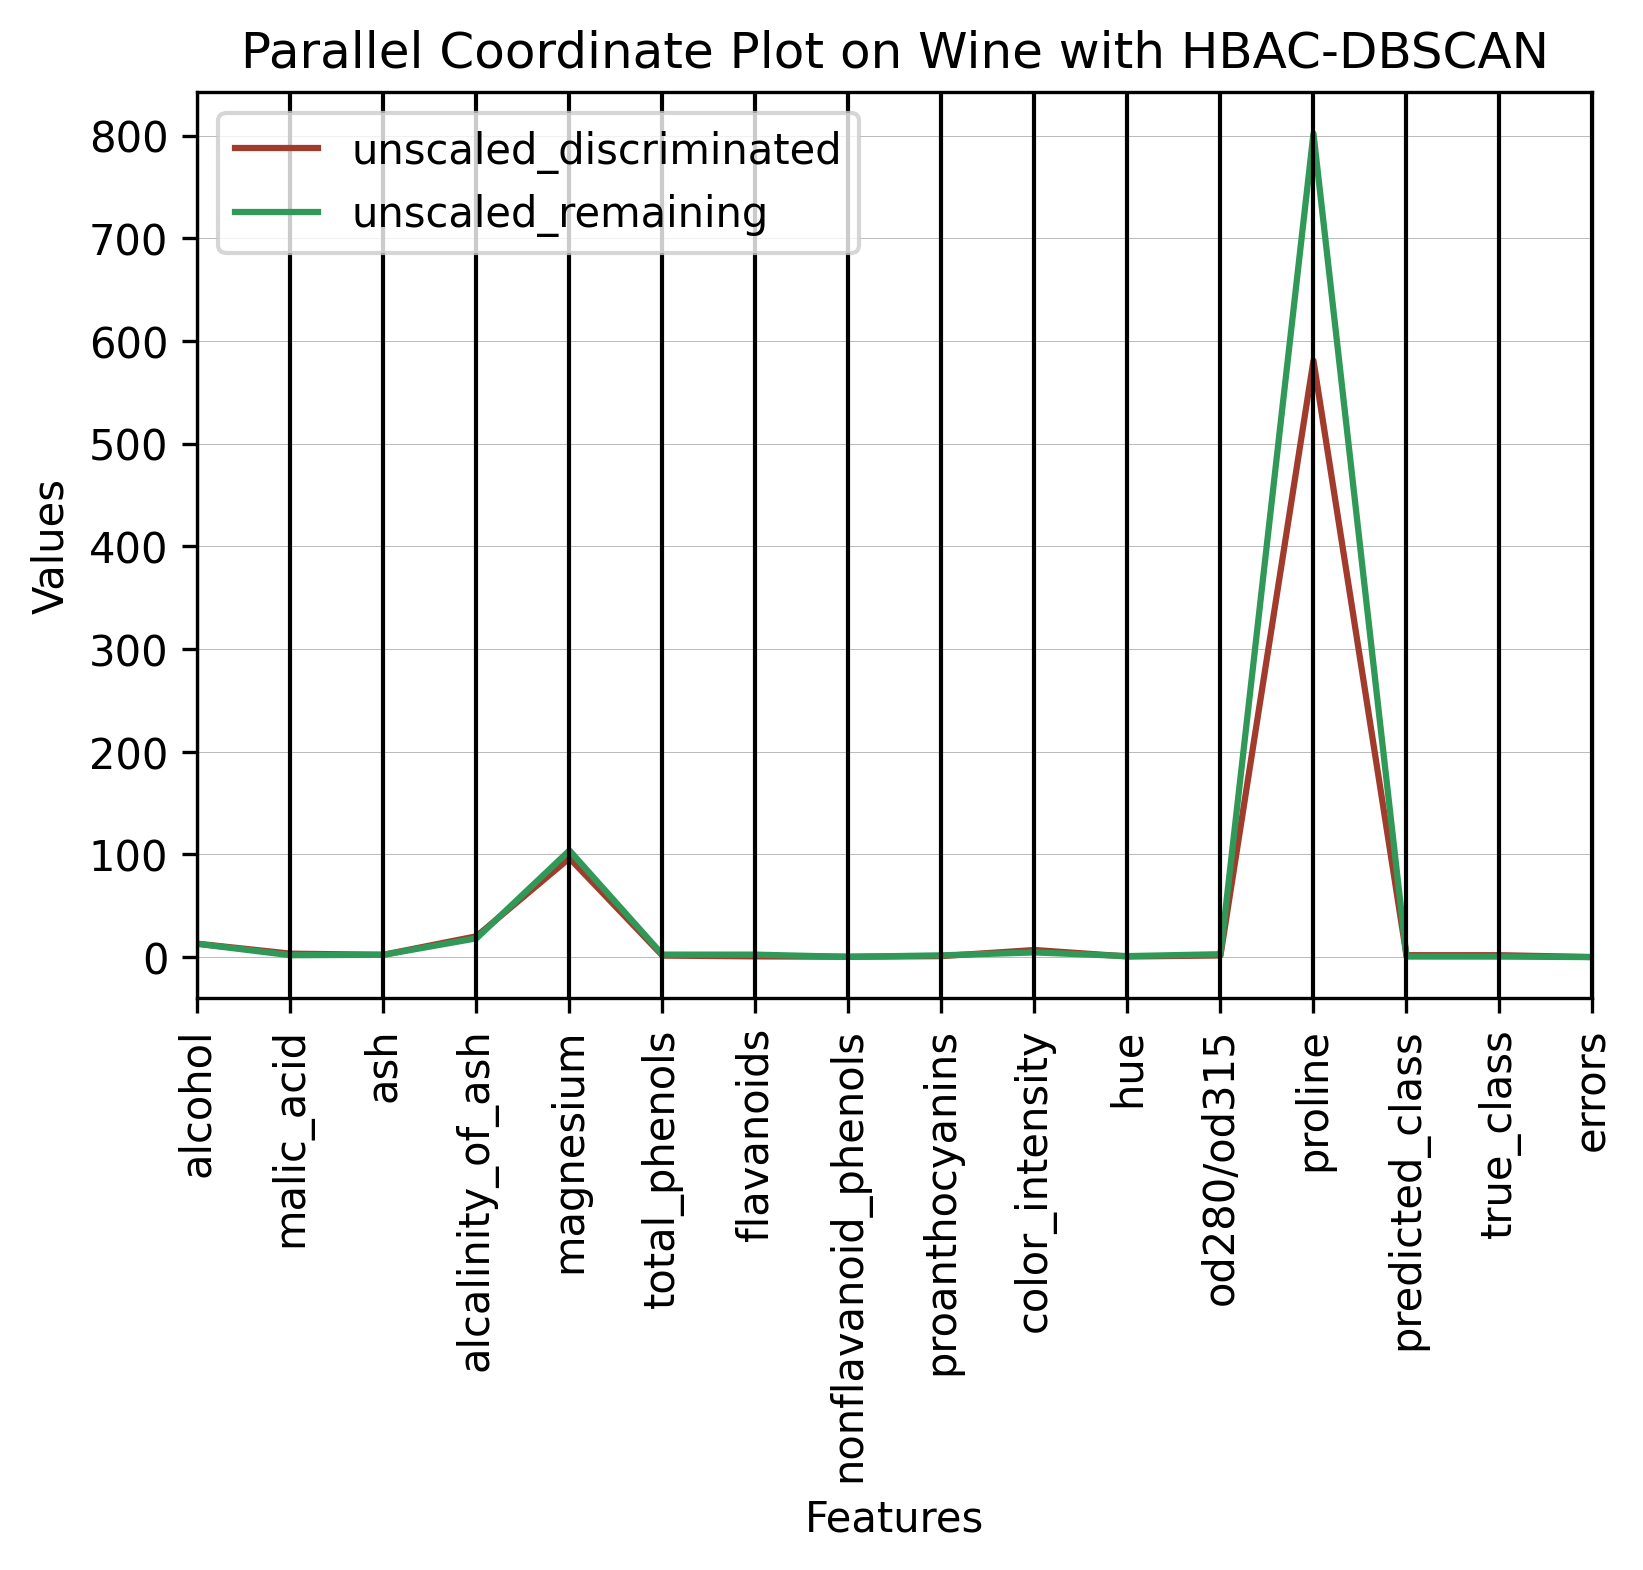

In [148]:
# unscaling the discriminated cluster
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the p-value:', welch_i.pvalue)

research_dbscan = pd.DataFrame()
research_dbscan['unscaled_discriminated'] = unscaled_discriminated.mean()
research_dbscan['unscaled_remaining'] = unscaled_remaining.mean()
research_dbscan['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()

display(research_dbscan.describe())


# unscaling the discriminated cluster
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the p-value:', welch_i.pvalue)

research_dbscan = pd.DataFrame()
research_dbscan['unscaled_discriminated'] = unscaled_discriminated.mean()
research_dbscan['unscaled_remaining'] = unscaled_remaining.mean()
research_dbscan['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()

research_dbscan

mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
# mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
mean_clusters_transpose = mean_clusters.T
# mean_clusters_transpose.rename(columns={'od280':'od280/od315'}, inplace=True)

mean_clusters_transpose['index'] = mean_clusters_transpose.index
mean_clusters_transpose.head()



def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(mean_clusters_transpose, "Parallel Coordinate Plot on Wine with HBAC-DBSCAN")

In [236]:
full_data = initialize_dataset(raw_data)

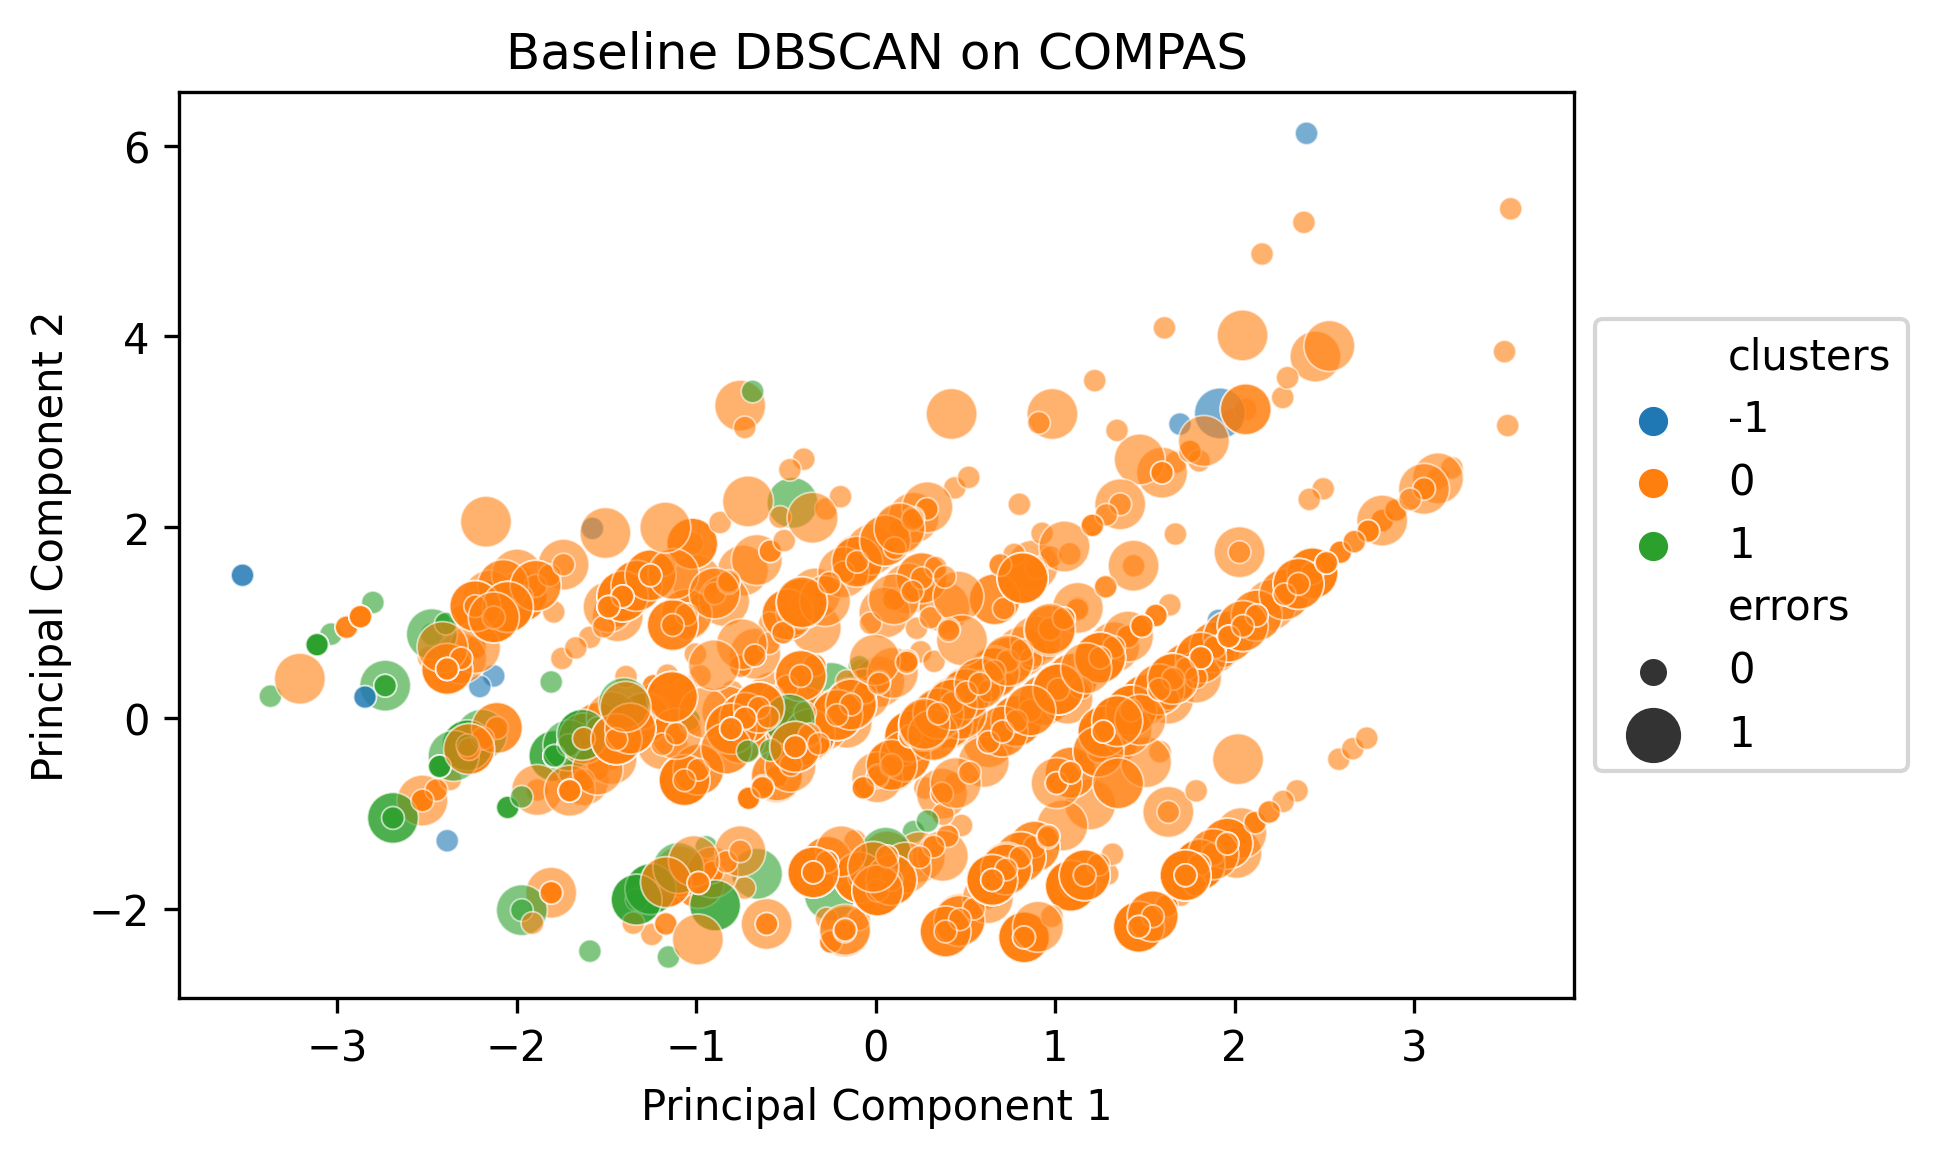

In [237]:
# Baseline DBSCAN

epsilon = 4
min_samples = 20
full_data['clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=20).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=full_data.index)

pca_plot(full_data, 'Baseline DBSCAN on COMPAS', 0.6)

In [ ]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_dbscan_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_dbscan_aware)

In [ ]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster



# 3. Bias-Aware Mean Shift 


The estimate_bandwidth function to estimate the bandwidth parameter of Mean Shift is significantly better than manually selecting a bandwidth value.

In [259]:
full_data = initialize_dataset(raw_data)
bandwidth_features = full_data.iloc[: , : 14]
# bandwidth_features = full_data.iloc[: , : 25]
bandwidth_features.head()
estimate_bandwidth(bandwidth_features)

3.801201373811504

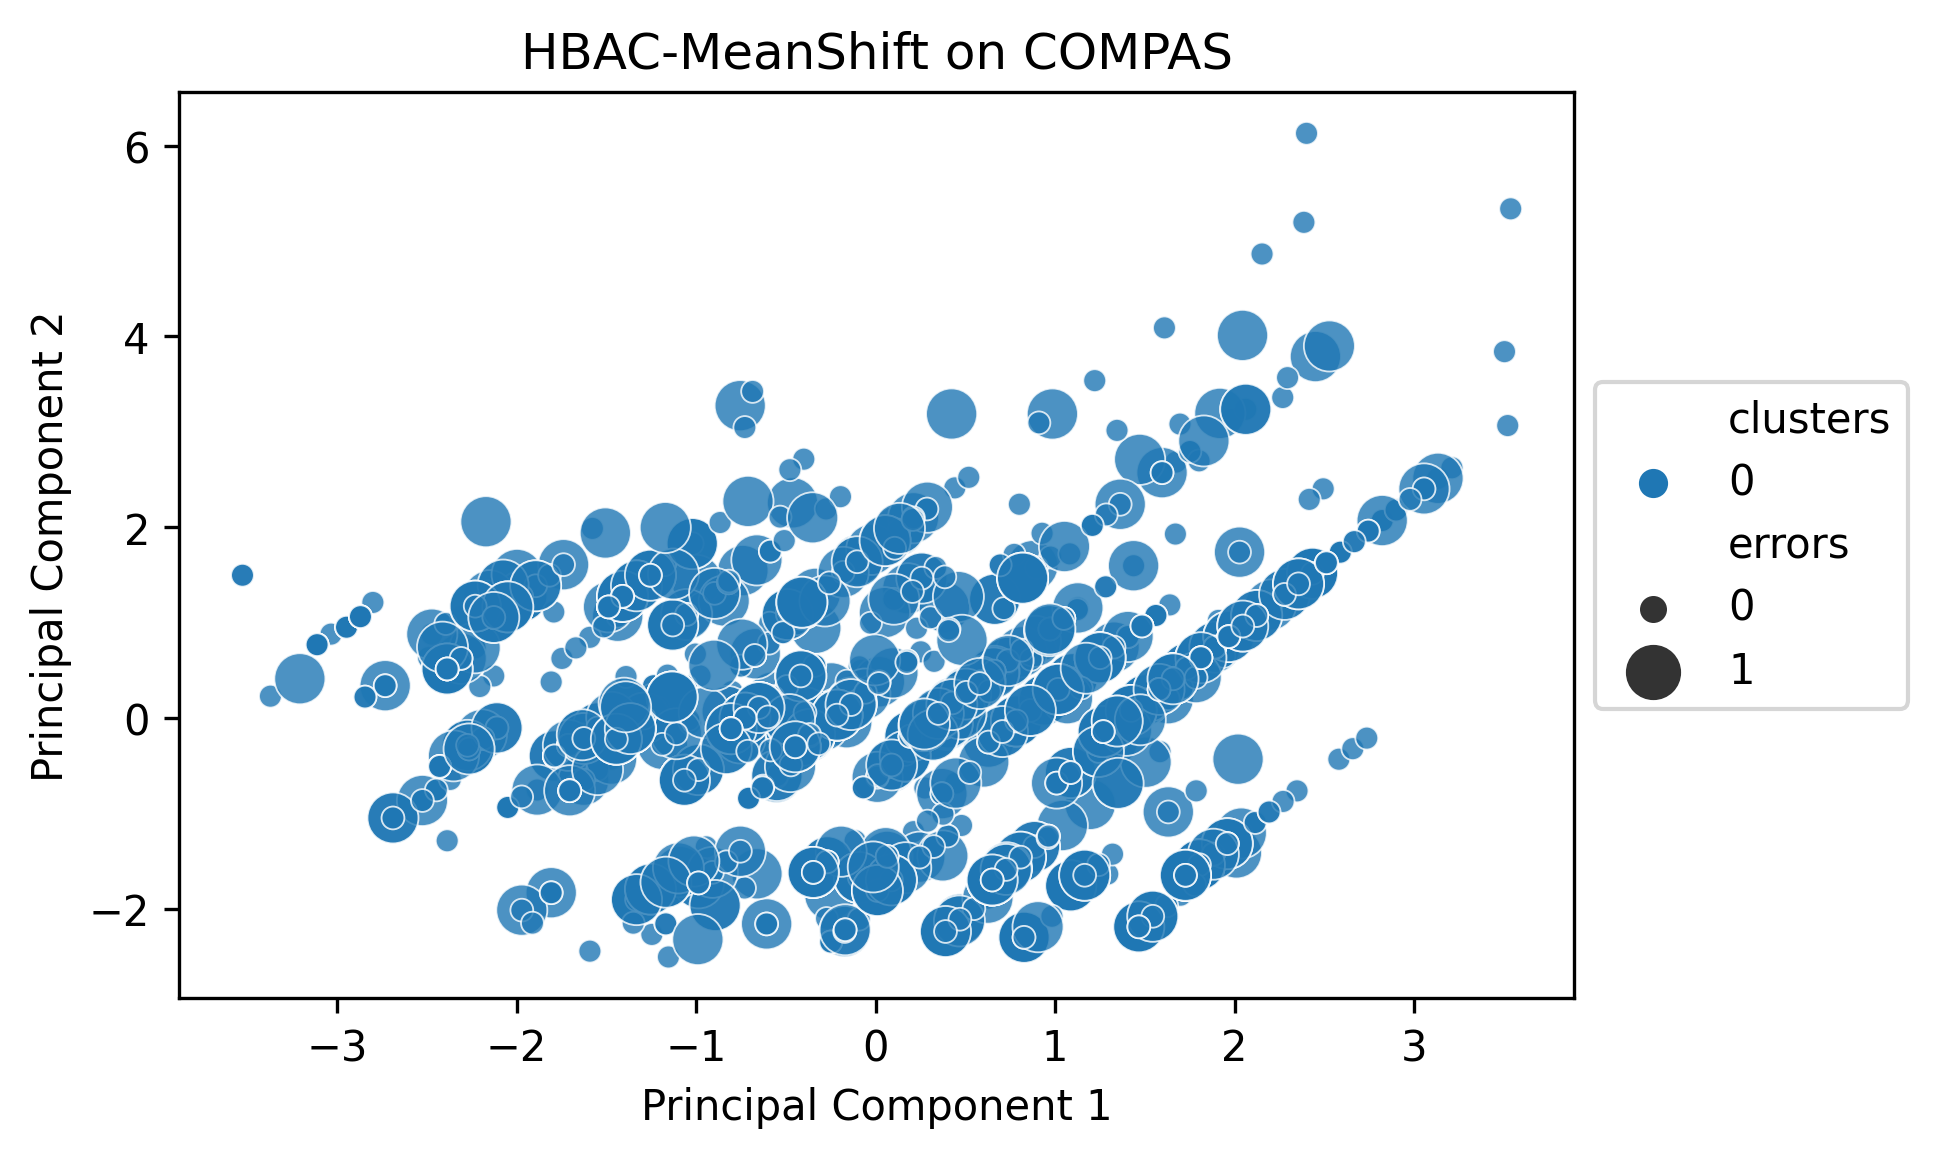

average_accuracy is:  0.6727861771058316
This is the current cluster:  0
discriminating bias is: -999999
smallest cluster: 1
This is the random cluster we have picked: 1
This is the current cluster:  1
This cluster is the entire dataset. Cluster:  0
You are calculating the accuracy on a empty cluster


ZeroDivisionError: division by zero

In [260]:
MAX_ITER = 30
x = 0 # cluster number
initial_bias = 0
bw1 = 1
# bw1 = estimate_bandwidth(bandwidth_features)
# print('estimated bandwidth: ', bw1)
pca_plot(full_data, 'HBAC-MeanShift on COMPAS', 0.8)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = round(0.01 * len(full_data))
minimal_acceptable_cluster_size = round(0.01 * len(full_data))
print("average_accuracy is: ", average_accuracy) 


for i in range(1, MAX_ITER):
    print('This is the current cluster: ', x)
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply MeanShift
    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class','true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters']) 

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster:",min_new_size)
    if (max_neg_bias <= initial_bias) & (min_new_size >= minimal_acceptable_cluster_size): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data, 'HBAC-MeanShift on COMPAS', 0.8)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 3. Mean-Shift Results

In [183]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_meanshift_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_meanshift_aware)

0 has bias -0.08571428571428574
1 has bias 0.08571428571428574
cluster with the highest discriminating bias: 0
cluster 0 has the highest negative bias
[0 1]
Overall accuracy: 0.9166666666666666
Highest found negative bias: -0.08571428571428574


In [184]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

Number of instances in discriminated cluster: 70
Number of errors in discriminated clusters:  6


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
118 -0.338510    1.005004 -1.166817          -0.803327  -1.246801   
39   1.505019    1.494574  0.630750          -1.590260   1.470062   
176  0.170050    0.270648  0.155921           0.320862   1.017252   
..        ...         ...       ...                ...        ...   
12   0.907461   -0.481192  0.291586          -0.803327  -0.737389   
47   1.098171   -0.524904 -0.691988          -0.803327  -0.058174   
8    2.280572   -0.559873 -0.522406          -1.365422  -0.284579   
124 -1.482769    1.774329  0.223754           0.601910  -1.133599   
172  1.428735    0.200709  0.529001           0.320862  -0.624187   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
118      -0.988536   -0.762724              0.599286        -1.234524   
39        1.074278    0.907054             -1.248791         0.733019   
176      -0.958422   -1.294440              1.402798        -0.242882   
..             ...         ...                   ...              ...   
12        0.471996    0.645860             -0.525631         0.308030   
47        1.224848    1.233547             -1.168440         0.827461   
8         0.773137    0.851084             -0.525631         0.575616   
124       0.863479    0.897726             -1.168440         2.039468   
172      -0.913251   -1.275784              0.679637        -0.589170   

     color_intensity       hue  od280/od315   proline  scaled_errors  \
104        -1.025689  0.361193     1.354564 -0.225753            0.0   
67         -0.239382  0.710266     1.229242 -0.714467            0.0   
118        -0.817815 -1.122366    -0.664518 -1.130778            0.8   
39         -0.049584 -0.293318     1.298865  0.039721            0.0   
176         1.848400 -1.558707    -1.360753  0.281061            0.0   
..               ...       ...          ...       ...            ...   
12          0.176367  0.841168     0.421609  1.729100            0.0   
47          0.402317 -0.206050     1.020371  0.718489            0.0   
8          -0.004393  0.535730     0.351986  0.899494            0.0   
124        -1.088955 -0.904195     1.452037 -1.106644            0.0   
172         2.029160 -1.471438    -1.235431 -0.261954            0.0   

     predicted_class  true_class  errors  clusters  new_clusters  
104                1           1       0         0           0.0  
67                 1           1       0         0           0.0  
118                2           1       1         0           0.0  
39                 0           0       0         0           0.0  
176                2           2       0         0           0.0  
..               ...         ...     ...       ...           ...  
12                 0           0       0         0           0.0  
47                 0           0       0         0           0.0  
8                  0           0       0         0           0.0  
124                1           1       0         0           0.0  
172                2           2       0         0           0.0  

[70 rows x 19 columns]

alcohol
this is the p-value: 0.46904143645226426
malic_acid
this is the p-value: 0.18843100896535317
ash
this is the p-value: 0.30159350274725427
alcalinity_of_ash
this is the p-value: 0.01431163768417537
magnesium
this is the p-value: 0.2079986461380798
total_phenols
this is the p-value: 2.0866482782896116e-05
flavanoids
this is the p-value: 0.3197059960376143
nonflavanoid_phenols
this is the p-value: 0.9228373259996556
proanthocyanins
this is the p-value: 0.003896719780358091
color_intensity
this is the p-value: 0.7498299282487466
hue
this is the p-value: 0.538594689645457
od280/od315
this is the p-value: 0.0030667149364055875
proline
this is the p-value: 0.9452972777465678
predicted_class
this is the p-value: 0.5409302339423507
true_class
this is the p-value: 0.3582603990240084
errors
this is the p-value: 0.013223724107615667


unscaled_discriminated  unscaled_remaining  difference
alcohol                            13.058000              12.275    0.783000
malic_acid                          2.292429               1.860    0.432429
ash                                 2.307143               2.915   -0.607857
alcalinity_of_ash                  18.561429              29.250  -10.688571
magnesium                         101.257143             129.000  -27.742857
total_phenols                       2.259286               3.240   -0.980714
flavanoids                          2.012857               3.985   -1.972143
nonflavanoid_phenols                0.355857               0.340    0.015857
proanthocyanins                     1.605714               1.915   -0.309286
color_intensity                     5.225000               4.675    0.550000
hue                                 0.952571               1.120   -0.167429
od280/od315                         2.568714               3.595   -1.026286
proline                           747.457143             725.000   22.457143
predicted_class                     0.942857               1.000   -0.057143
true_class                          0.914286               1.000   -0.085714
errors                              0.085714               0.000    0.085714

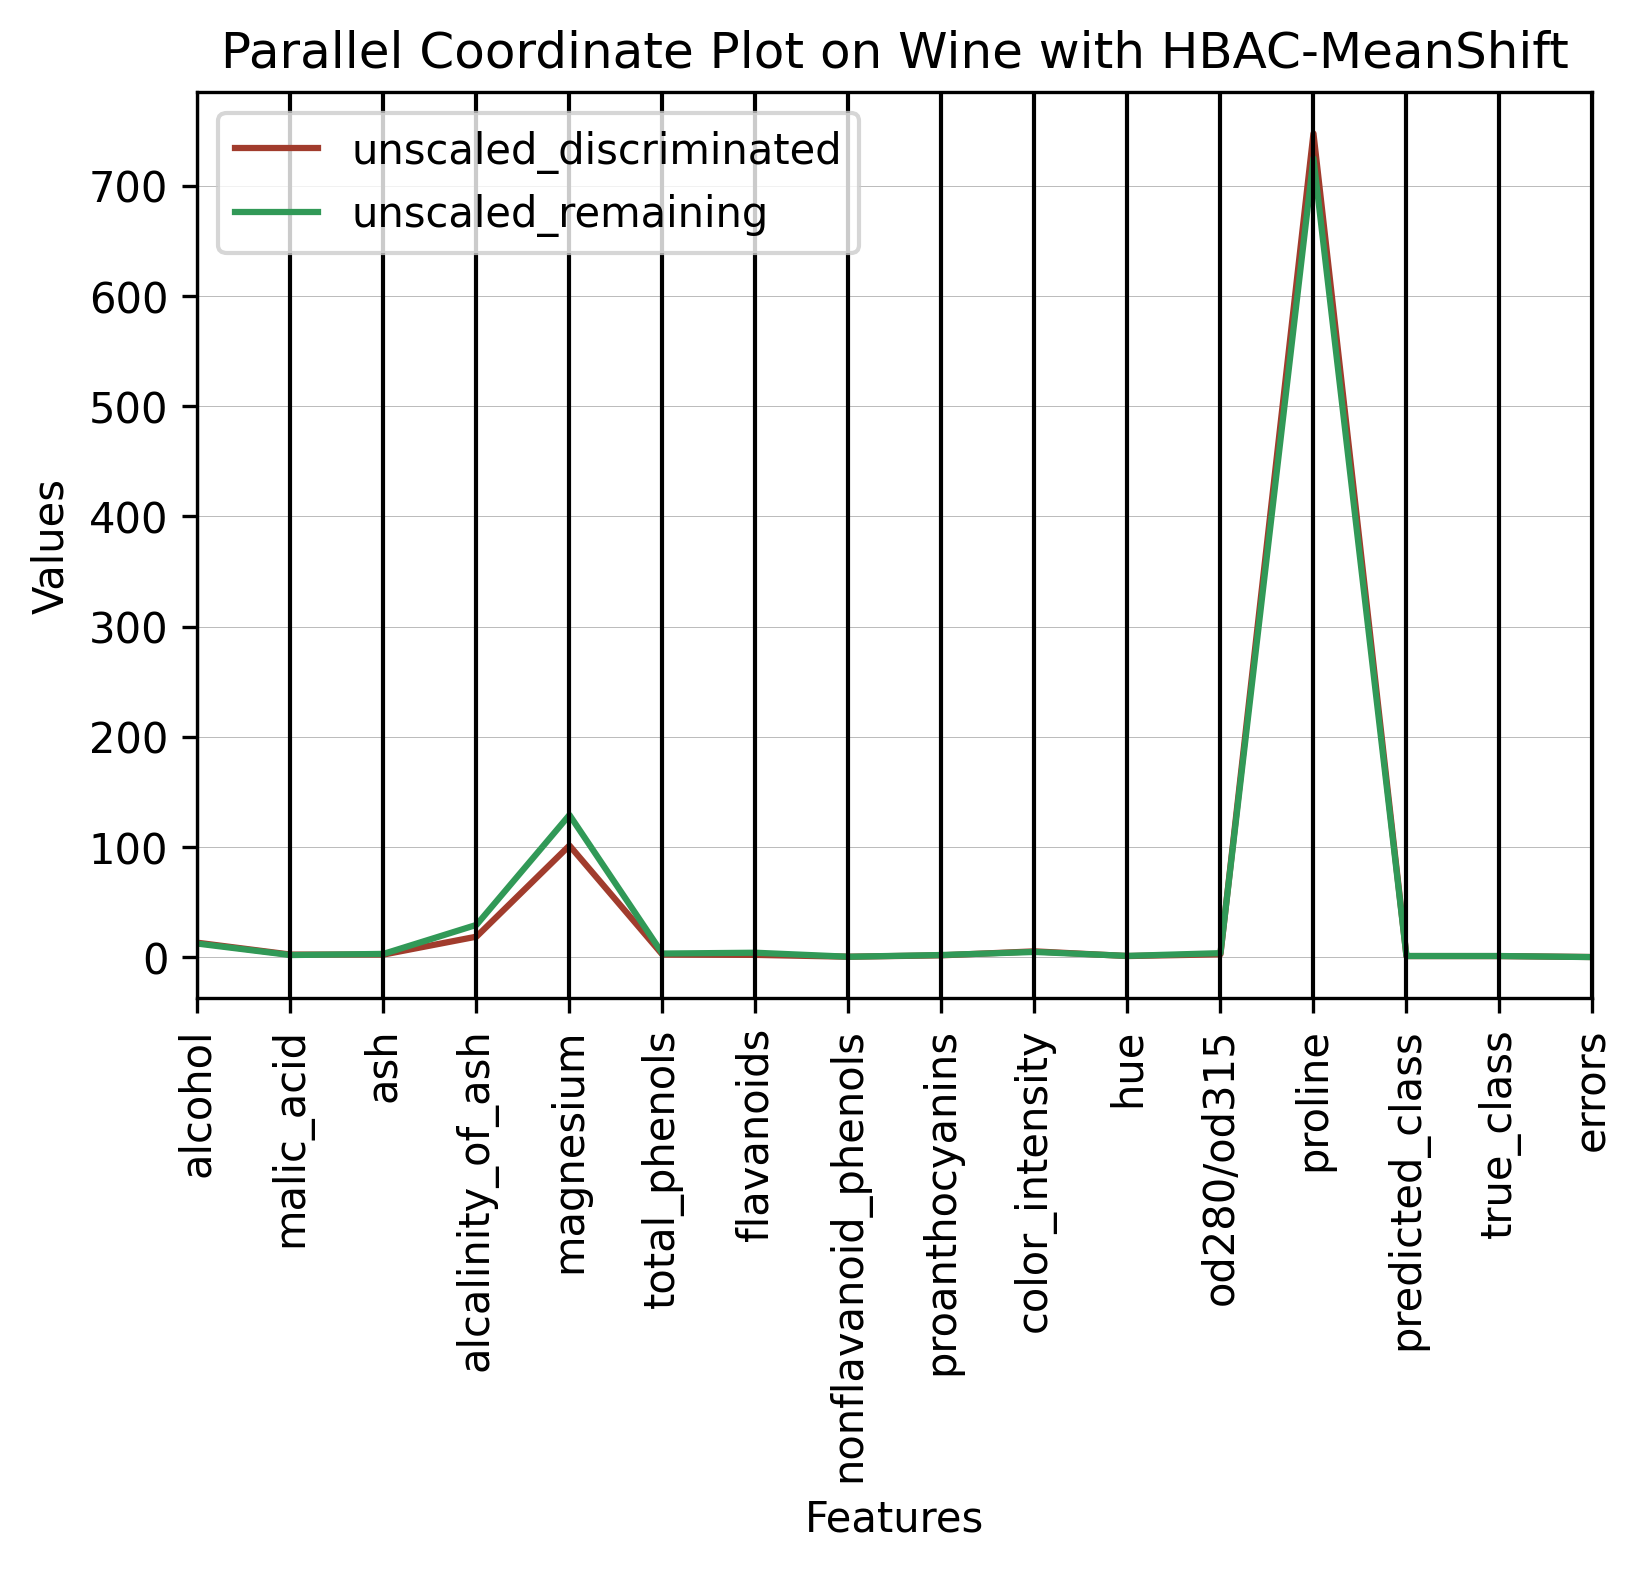

In [185]:
# results 
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)
# unscaling the discriminated cluster
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the p-value:', welch_i.pvalue)


research_dbscan = pd.DataFrame()
research_dbscan['unscaled_discriminated'] = unscaled_discriminated.mean()
research_dbscan['unscaled_remaining'] = unscaled_remaining.mean()
research_dbscan['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()

display(research_dbscan)


mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
# mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
mean_clusters_transpose = mean_clusters.T
# mean_clusters_transpose.rename(columns={'od280':'od280/od315'}, inplace=True)

mean_clusters_transpose['index'] = mean_clusters_transpose.index
mean_clusters_transpose.head()


def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(mean_clusters_transpose, "Parallel Coordinate Plot on Wine with HBAC-MeanShift")

<AxesSubplot:ylabel='variance incl errors'>

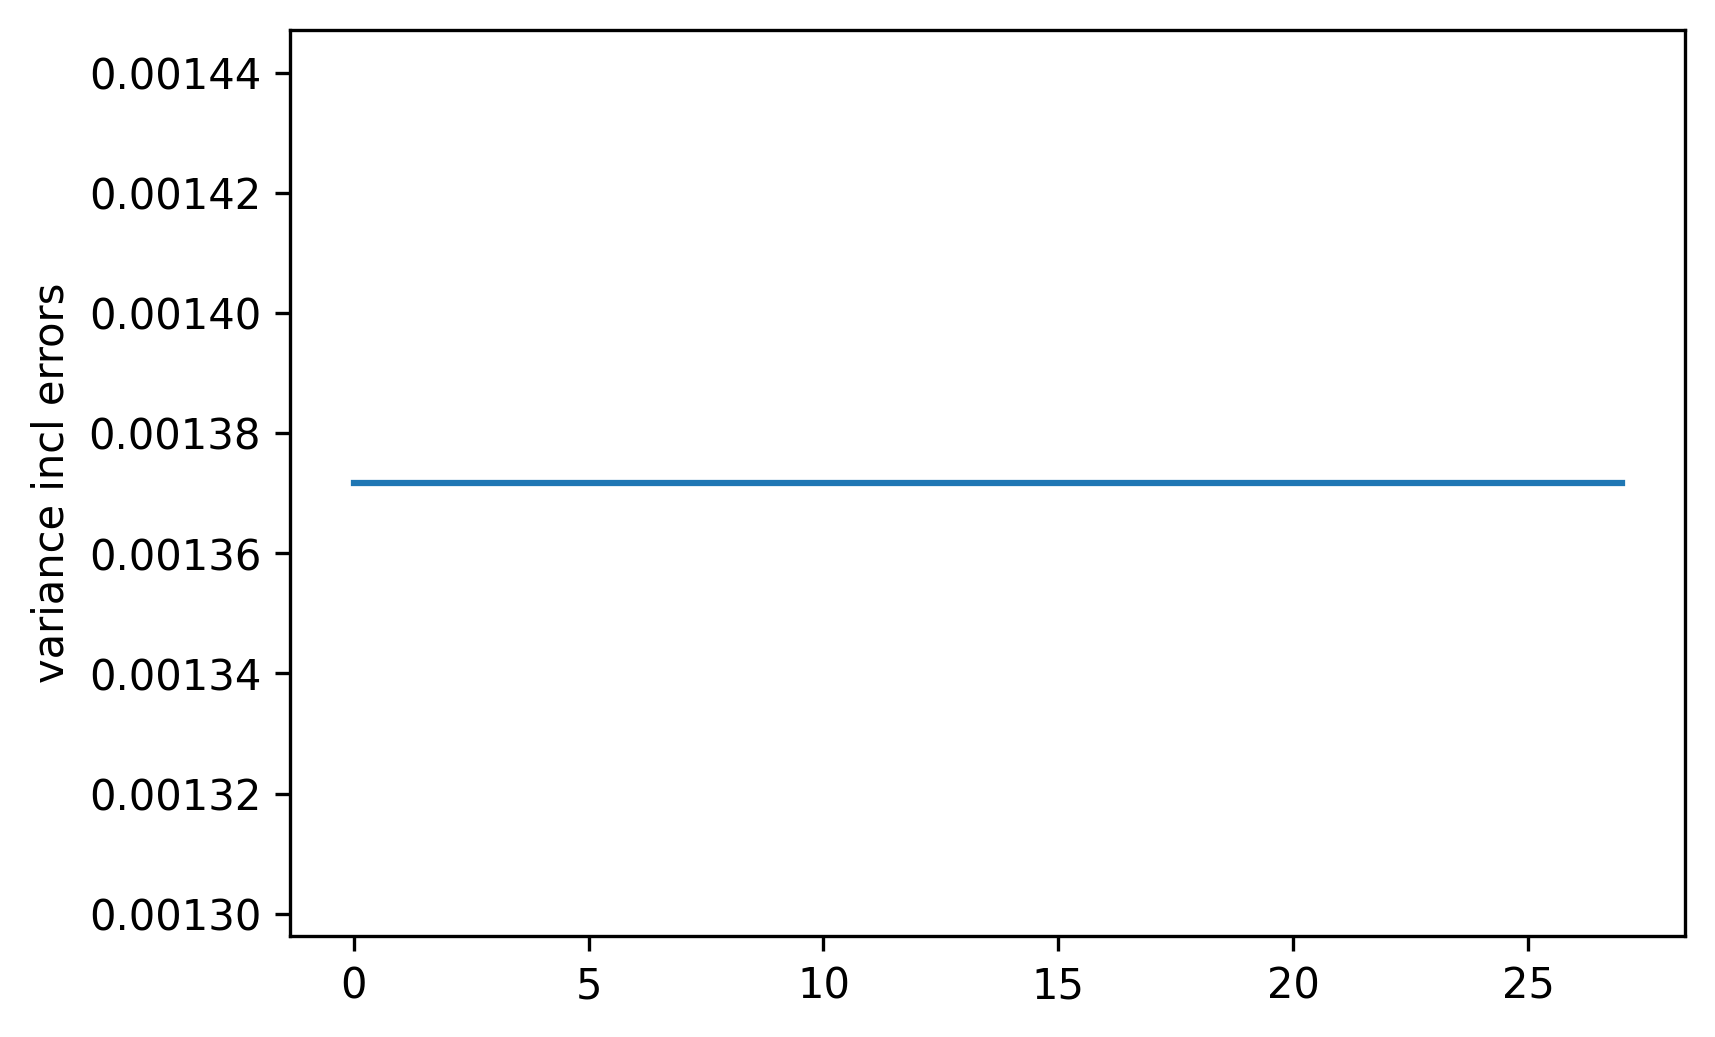

In [165]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance incl errors")

## Baseline Mean Shift

In [276]:
full_data = initialize_dataset(raw_data)
# bandwidth_features = full_data.iloc[: , : 25]
bandwidth_features = full_data.iloc[: , : 14]
bw1 = estimate_bandwidth(bandwidth_features)

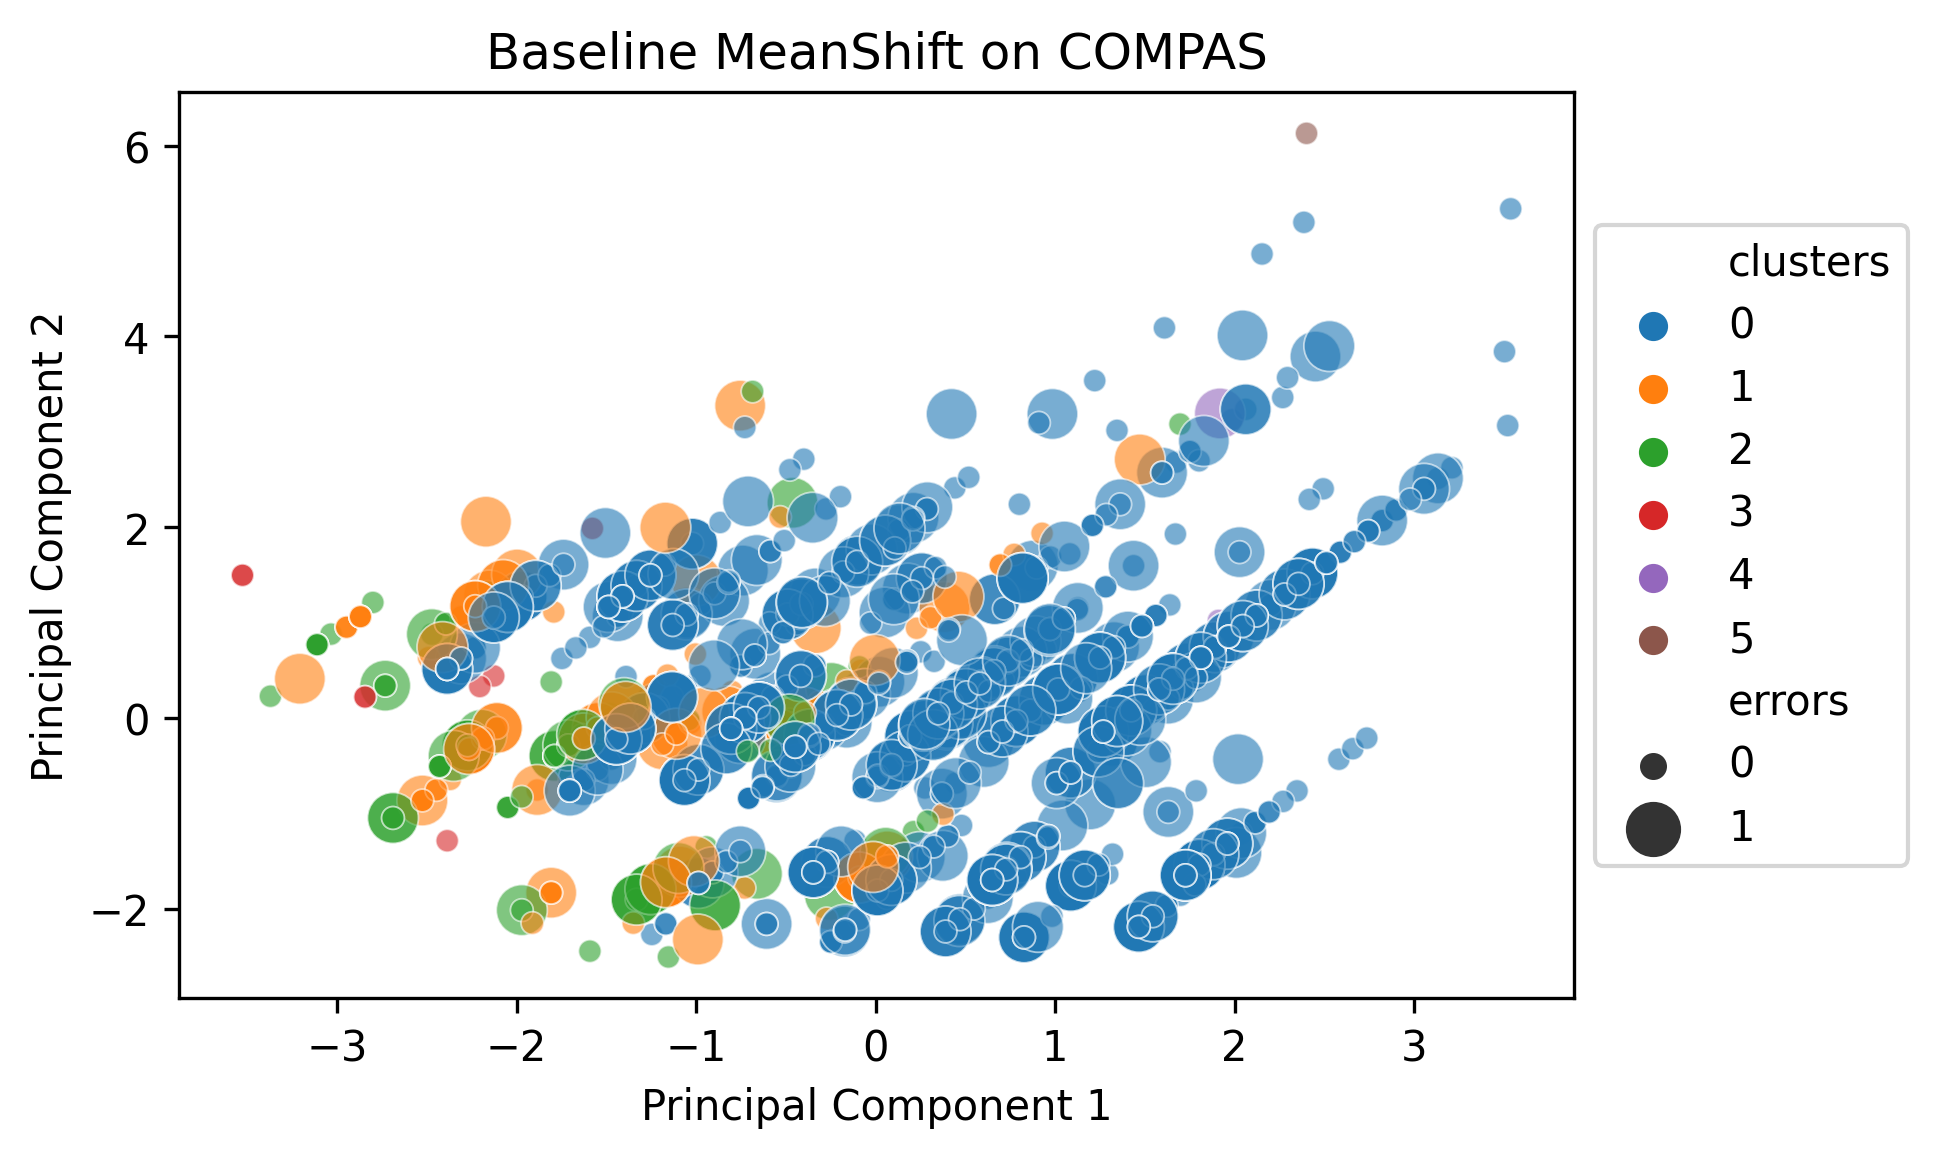

In [281]:
full_data['clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=full_data.index)
pca_plot(full_data, 'Baseline MeanShift on COMPAS', 0.6)

In [282]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinemeanshift = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinemeanshift)

0 has bias 0.03388312129290483
2 has bias -0.025125263234333062
1 has bias -0.05568154329946784
3 has bias 0.3286334056399133
4 has bias -0.17297297297297298
5 has bias 0.32739059967585094
cluster with the highest discriminating bias: 4
cluster 4 has the highest negative bias
[0 2 1 3 4 5]
Overall accuracy: 0.6727861771058316
Highest found negative bias: -0.17297297297297298


Number of instances in discriminated cluster: 2
Number of errors in discriminated clusters:  1
found discriminated cluster:


Number_of_Priors  score_factor  Age_Above_FourtyFive  \
5033         -0.467293      1.125535             -0.497974   
987           0.765800      1.125535             -0.497974   

      Age_Below_TwentyFive  African_American     Asian  Hispanic  \
5033              1.899201         -1.031824 -0.065866 -0.303284   
987              -0.526537         -1.031824 -0.065866 -0.303284   

      Native_American     Other    Female  Misdemeanor  scaled_errors  \
5033        24.826062 -0.231235 -0.476763    -0.751125            0.0   
987         24.826062 -0.231235 -0.476763    -0.751125            0.8   

      predicted_class  true_class  errors  clusters  new_clusters  
5033                1           1       0         4            -1  
987                 1           0       1         4            -1

Number_of_Priors
this is the p-value: 0.8486548136092417
score_factor
this is the p-value: 0.0
Age_Above_FourtyFive
this is the p-value: 3.6900852142464404e-91
Age_Below_TwentyFive
this is the p-value: 0.6718724772244571
African_American
this is the p-value: 7.445788510440032e-294
Asian
this is the p-value: 0.004649796260275556
Hispanic
this is the p-value: 2.7108523273917274e-37
Native_American
this is the p-value: 0.0
Other
this is the p-value: 9.414671042432703e-23
Female
this is the p-value: 1.9895998135657584e-84
Misdemeanor
this is the p-value: 4.2052372156306244e-182
predicted_class
this is the p-value: 0.0
true_class
this is the p-value: 0.943032168524587
errors
this is the p-value: 0.7879726042888906


unscaled_discriminated  unscaled_remaining  difference
Number_of_Priors                         4.0            3.272973    0.727027
score_factor                             1.0            0.440541    0.559459
Age_Above_FourtyFive                     0.0            0.198919   -0.198919
Age_Below_TwentyFive                     0.5            0.216757    0.283243
African_American                         0.0            0.516216   -0.516216
Asian                                    0.0            0.004324   -0.004324
Hispanic                                 0.0            0.084324   -0.084324
Native_American                          1.0            0.000541    0.999459
Other                                    0.0            0.050811   -0.050811
Female                                   0.0            0.185405   -0.185405
Misdemeanor                              0.0            0.361081   -0.361081
predicted_class                          1.0            0.413514    0.586486
true_class                               0.5            0.455135    0.044865
errors                                   0.5            0.327027    0.172973

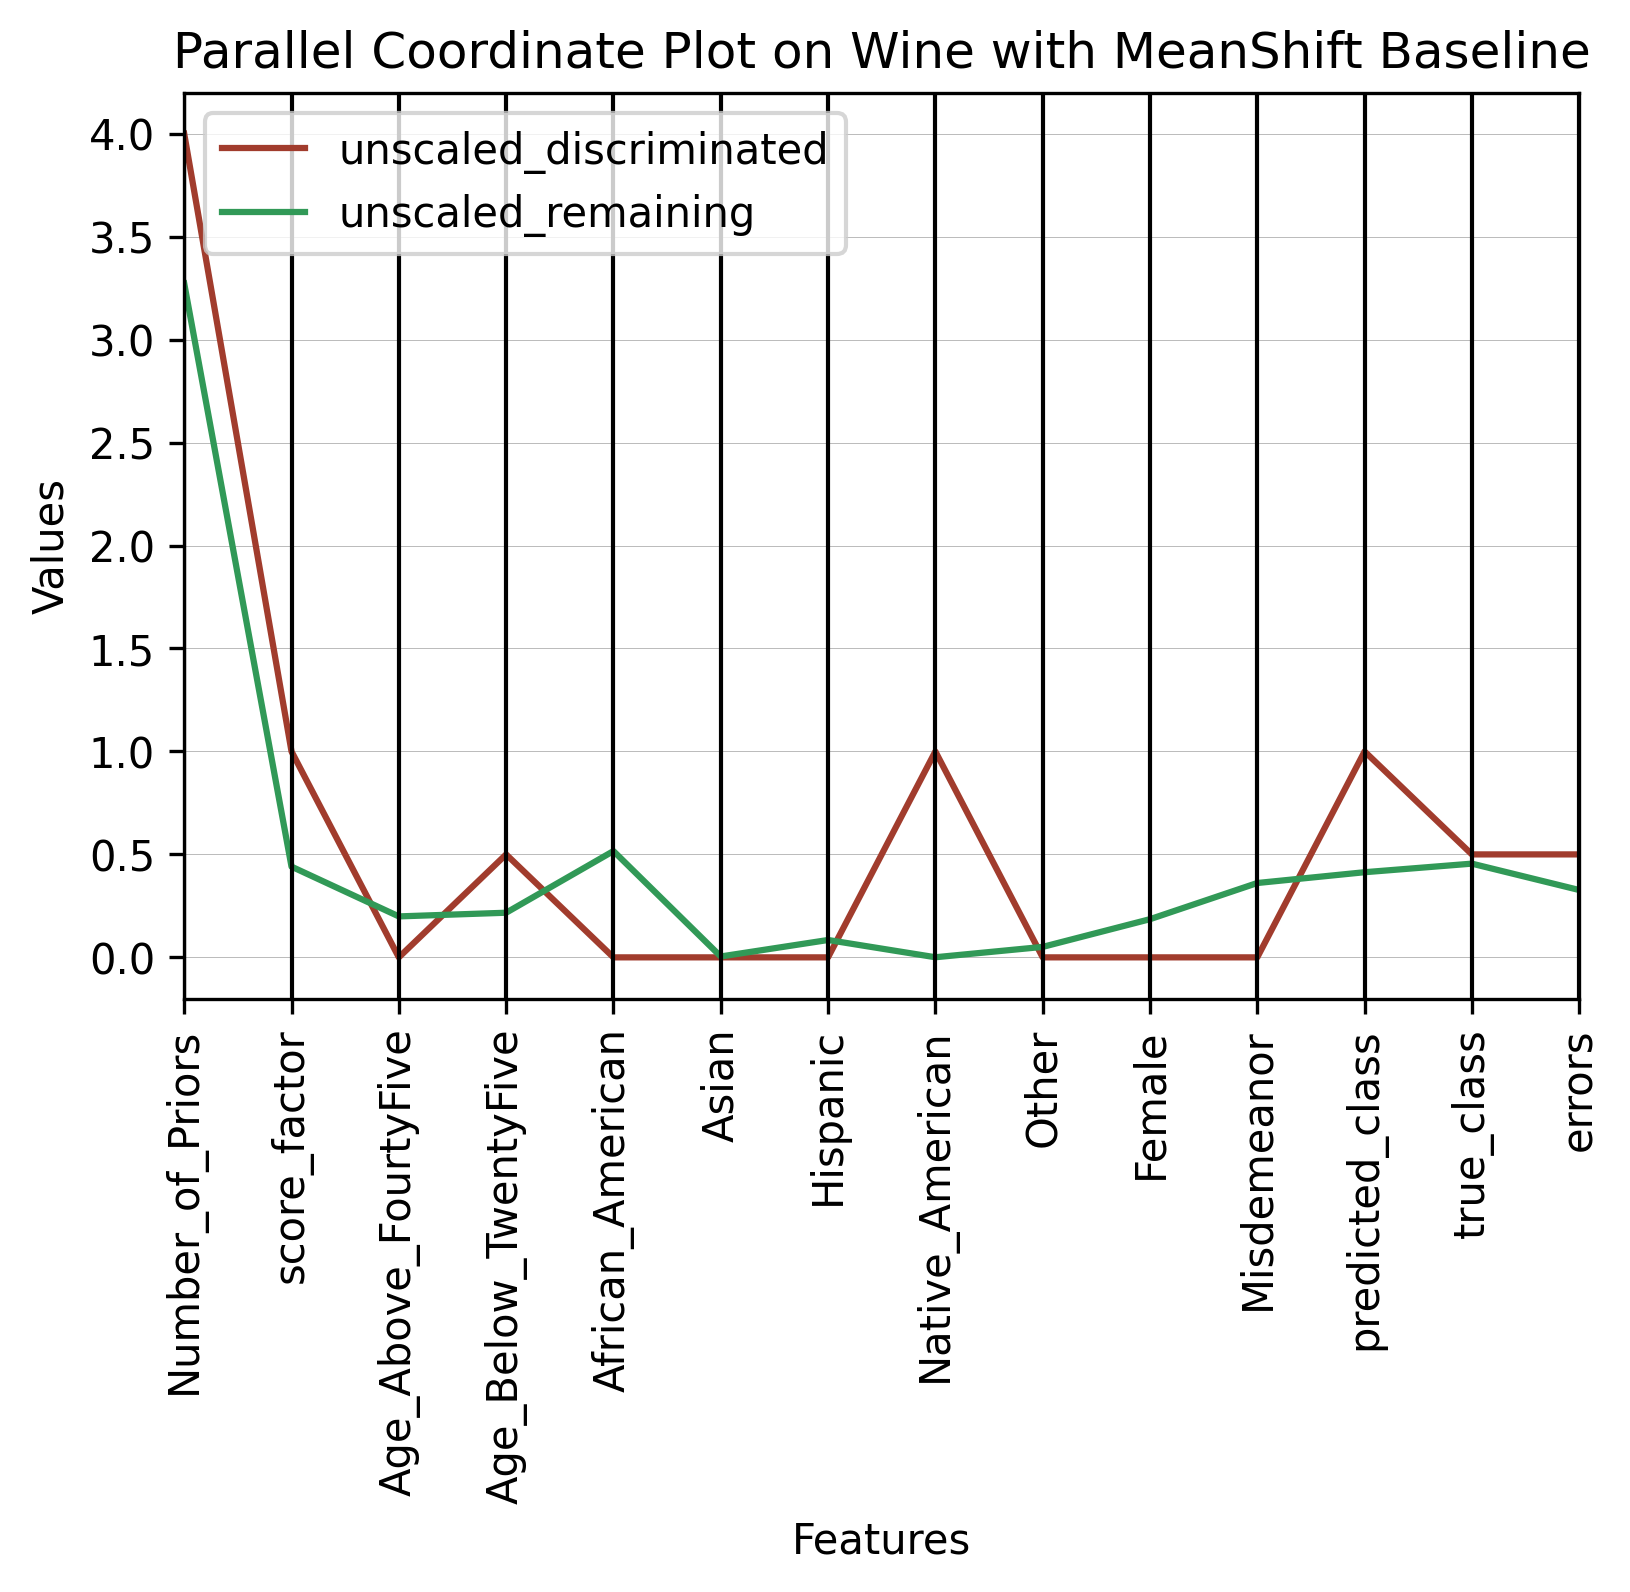

In [283]:
# results 
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)
# unscaling the discriminated cluster
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the p-value:', welch_i.pvalue)


research_dbscan = pd.DataFrame()
research_dbscan['unscaled_discriminated'] = unscaled_discriminated.mean()
research_dbscan['unscaled_remaining'] = unscaled_remaining.mean()
research_dbscan['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()

display(research_dbscan)


mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
# mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
mean_clusters_transpose = mean_clusters.T
# mean_clusters_transpose.rename(columns={'od280':'od280/od315'}, inplace=True)

mean_clusters_transpose['index'] = mean_clusters_transpose.index
mean_clusters_transpose.head()


def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(mean_clusters_transpose, "Parallel Coordinate Plot on Wine with MeanShift Baseline")

## Goal 1: Comparing Bias-Aware KMeans/DBSCAN/MeanShift with finding the highest negatively biased cluster

In [194]:
results_array = []

# the minus is to make the values positive, as that makes it easier to find the highest negative biased cluster
results_array.append(-most_biased_cluster_kmeans_aware)
results_array.append(-most_biased_cluster_dbscan_aware)
results_array.append(-most_biased_cluster_meanshift_aware)
results_array.append(-most_biased_cluster_baselinekm)
results_array.append(-most_biased_cluster_baselinemeanshift)


plt.bar(['KMeans', 'DBSCAN', 'MeanShift', 'BaselineKM', 'BaselineMeanShift'], results_array)


NameError: name 'most_biased_cluster_baselinekm' is not defined